In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# CELL 1: DIGITAL ORGANISM - INFINITE TRAINING ENGINE
# Copy this entire cell into your notebook as the first cell

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from datetime import datetime

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 16
GRID_SIZE = 72
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
STEPS_PER_LIFE = 96
SAVE_INTERVAL = 100  # Save every N epochs
CRYO_PATH = "digital_organism_save"

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 Digital Organism Training System")
print(f"   Device: {device}")
print(f"   Architecture: {CHANNELS}D Neural Automata on {GRID_SIZE}x{GRID_SIZE} grid")
print(f"   Save Path: {CRYO_PATH}/")

# ==================== THE GENOME ====================
class OrganismDNA(nn.Module):
    """The neural rules that govern cell behavior"""
    def __init__(self, channels=16, hidden=128):
        super().__init__()
        self.perceive = nn.Conv2d(channels, hidden, 3, padding=1)
        self.think = nn.Conv2d(hidden, channels, 1)
        
        # Start from dormant state
        nn.init.zeros_(self.think.weight)
        nn.init.zeros_(self.think.bias)
    
    def forward(self, x):
        perception = torch.relu(self.perceive(x))
        update = self.think(perception)
        
        # Stochastic firing (life is not deterministic)
        b, c, h, w = x.shape
        mask = (torch.rand(b, 1, h, w, device=x.device) > 0.5).float()
        
        return x + update * mask

# ==================== ENVIRONMENT ====================
def make_seed(batch_size, channels=CHANNELS, size=GRID_SIZE):
    """Birth - single active cell in center"""
    x = torch.zeros(batch_size, channels, size, size, device=device)
    mid = size // 2
    x[:, :, mid, mid] = 1.0
    return x

def inject_context(x, ctx_vector):
    """Inject 3D context signal into last 3 channels"""
    b, c, h, w = x.shape
    ctx = [torch.full((b, 1, h, w), float(v), device=device) for v in ctx_vector]
    return torch.cat([x[:, :-3, :, :]] + ctx, dim=1)

def get_target(context, step):
    """Generate dynamic targets based on context"""
    Y, X = torch.meshgrid(
        torch.arange(GRID_SIZE, device=device),
        torch.arange(GRID_SIZE, device=device),
        indexing='ij'
    )
    
    # Context: [complexity, movement_speed, size]
    complexity, speed, size = context
    
    # Dynamic movement
    angle = step * (0.05 + speed * 0.15)
    radius = 12.0 * (1.0 + size * 0.5)
    cx = (GRID_SIZE // 2) + radius * np.cos(angle)
    cy = (GRID_SIZE // 2) + radius * np.sin(angle)
    
    dist = torch.sqrt((X - cx)**2 + (Y - cy)**2)
    
    # Shape complexity
    pattern_size = 8.0 * (1.0 + complexity)
    target = torch.exp(-(dist**2) / (2 * pattern_size**2))
    
    return target.unsqueeze(0).unsqueeze(0).repeat(BATCH_SIZE, 4, 1, 1)

def damage_organism(x, severity=0.3):
    """Random damage for robustness testing"""
    b, c, h, w = x.shape
    mask = torch.ones_like(x)
    
    for i in range(b):
        if random.random() < severity:
            cx = random.randint(h//4, 3*h//4)
            cy = random.randint(w//4, 3*w//4)
            radius = random.randint(5, 12)
            
            Y, X = torch.meshgrid(
                torch.arange(h, device=device),
                torch.arange(w, device=device),
                indexing='ij'
            )
            dist = torch.sqrt((X - cx)**2 + (Y - cy)**2)
            mask[i, :, :, :] *= (dist > radius).float()
    
    return x * mask

# ==================== PERSISTENCE ====================
class CryoStorage:
    """Save/Load system for eternal training"""
    
    def freeze(self, dna, optimizer, epoch, loss_history, metadata=None):
        """Save complete organism state"""
        filepath = os.path.join(CRYO_PATH, f"organism_epoch_{epoch}.pth")
        
        capsule = {
            'dna': dna.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss_history': loss_history,
            'rng_state': torch.get_rng_state(),
            'metadata': metadata or {},
            'timestamp': datetime.now().isoformat()
        }
        
        torch.save(capsule, filepath)
        
        # Keep a "latest" for easy resumption
        latest_path = os.path.join(CRYO_PATH, "organism_latest.pth")
        shutil.copy(filepath, latest_path)
        
        # Create downloadable zip
        shutil.make_archive("digital_organism_backup", 'zip', CRYO_PATH)
        
        print(f"💾 Saved: Epoch {epoch} | {filepath}")
        return filepath
    
    def resurrect(self, dna, optimizer):
        """Load organism from disk"""
        filepath = os.path.join(CRYO_PATH, "organism_latest.pth")
        
        if not os.path.exists(filepath):
            print("🌱 No save found. Starting from Genesis.")
            return 0, []
        
        print(f"⚡ Resurrecting from {filepath}...")
        capsule = torch.load(filepath, map_location=device)
        
        dna.load_state_dict(capsule['dna'])
        optimizer.load_state_dict(capsule['optimizer'])
        torch.set_rng_state(capsule['rng_state'].cpu())
        
        epoch = capsule['epoch']
        loss_history = capsule['loss_history']
        
        print(f"✅ Restored: Epoch {epoch} | Age: {len(loss_history)} generations")
        return epoch + 1, loss_history

# ==================== TRAINING ENGINE ====================
organism = OrganismDNA(CHANNELS).to(device)
optimizer = torch.optim.Adam(organism.parameters(), lr=LEARNING_RATE)
cryo = CryoStorage()

# Try to load existing organism
start_epoch, loss_log = cryo.resurrect(organism, optimizer)

print(f"\n{'='*60}")
print(f"🚀 TRAINING INITIALIZED")
print(f"   Starting Epoch: {start_epoch}")
print(f"   Parameters: {sum(p.numel() for p in organism.parameters()):,}")
print(f"   Press Interrupt to pause/save anytime")
print(f"{'='*60}\n")

# ==================== INFINITE TRAINING LOOP ====================
try:
    epoch = start_epoch
    
    while True:  # Train forever until interrupted
        optimizer.zero_grad()
        
        # Random context (enables diverse behaviors)
        context = [random.random() for _ in range(3)]
        
        # Birth
        x = make_seed(BATCH_SIZE)
        
        loss_accum = 0.0
        
        # Lifetime simulation
        for step in range(STEPS_PER_LIFE):
            # Inject context
            x = inject_context(x, context)
            
            # Live one step
            x = organism(x)
            
            # Random damage (test robustness)
            if step == STEPS_PER_LIFE // 2 and random.random() < 0.3:
                x = damage_organism(x, severity=0.2)
            
            # Evaluate (sample to save compute)
            if step > 20 and step % 15 == 0:
                target = get_target(context, step)
                loss = F.mse_loss(x[:, :4, :, :], target)
                loss_accum += loss
        
        # Evolution step
        final_loss = loss_accum / ((STEPS_PER_LIFE - 20) // 15)
        final_loss.backward()
        torch.nn.utils.clip_grad_norm_(organism.parameters(), 1.0)
        optimizer.step()
        
        loss_log.append(final_loss.item())
        
        # Reporting
        if epoch % 10 == 0:
            avg_recent = np.mean(loss_log[-100:]) if len(loss_log) > 100 else np.mean(loss_log)
            print(f"Epoch {epoch:6d} | Loss: {final_loss.item():.5f} | Avg(100): {avg_recent:.5f} | Activity: {x[:, :4].abs().mean():.4f}")
        
        # Auto-save
        if epoch % SAVE_INTERVAL == 0 and epoch > 0:
            cryo.freeze(organism, optimizer, epoch, loss_log, 
                       metadata={'avg_loss': np.mean(loss_log[-1000:])})
        
        epoch += 1

except KeyboardInterrupt:
    print("\n🛑 Training interrupted by user")

finally:
    # Emergency save
    print("\n💾 Saving final state...")
    cryo.freeze(organism, optimizer, epoch, loss_log)
    print("✅ Complete. Safe to disconnect.")
    print(f"📦 Download: digital_organism_backup.zip")
    print(f"   Contains: All checkpoints + latest state")
    print(f"   Resume anytime by uploading and running this cell again!")

In [ ]:
# CELL 2: VISUALIZATION & INTERACTIVE DASHBOARD
# Run this in a separate cell after Cell 1 completes

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation
from IPython.display import display, Image, HTML
import ipywidgets as widgets
from collections import deque
import io
import time
import threading
from math import pi

# ==================== SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CRYO_PATH = "digital_organism_save"

print("🔬 Initializing Visualization Dashboard...")

# ==================== ARCHITECTURE RECONSTRUCTION ====================
class OrganismDNA(nn.Module):
    def __init__(self, channels=16, hidden=128):
        super().__init__()
        self.perceive = nn.Conv2d(channels, hidden, 3, padding=1)
        self.think = nn.Conv2d(hidden, channels, 1)
    
    def forward(self, x):
        perception = torch.relu(self.perceive(x))
        update = self.think(perception)
        b, c, h, w = x.shape
        mask = (torch.rand(b, 1, h, w, device=x.device) > 0.5).float()
        return x + update * mask

# Load organism
model = OrganismDNA(16, 128).to(device)
try:
    checkpoint = torch.load(f"{CRYO_PATH}/organism_latest.pth", map_location=device)
    model.load_state_dict(checkpoint['dna'])
    model.eval()
    print(f"✅ Loaded organism from Epoch {checkpoint['epoch']}")
except:
    print("⚠️ No trained organism found. Using fresh DNA.")

# ==================== METRICS ENGINE ====================
class MetricsTracker:
    def __init__(self, history=200):
        self.entropy = deque(maxlen=history)
        self.coherence = deque(maxlen=history)
        self.complexity = deque(maxlen=history)
        self.energy = deque(maxlen=history)
        self.variance = deque(maxlen=history)
    
    def calculate_entropy(self, x):
        p = x.abs()
        p = p / (p.sum() + 1e-8)
        return -(p * torch.log(p + 1e-8)).sum().item()
    
    def calculate_coherence(self, x):
        fft = torch.fft.fft2(x)
        power = torch.abs(fft)
        return (power.max() / (power.mean() + 1e-8)).item()
    
    def calculate_complexity(self, x):
        unique = len(torch.unique(x.round(decimals=2)))
        return unique / x.numel()
    
    def update(self, x):
        brain = x[0, 4, :, :]
        self.entropy.append(self.calculate_entropy(brain))
        self.coherence.append(self.calculate_coherence(brain))
        self.complexity.append(self.calculate_complexity(brain))
        self.energy.append(x[0, :13].abs().sum().item())
        self.variance.append(brain.var().item())
    
    def get_current(self):
        return {
            'entropy': self.entropy[-1] if self.entropy else 0,
            'coherence': self.coherence[-1] if self.coherence else 0,
            'complexity': self.complexity[-1] if self.complexity else 0,
            'energy': self.energy[-1] if self.energy else 0,
            'variance': self.variance[-1] if self.variance else 0
        }

metrics = MetricsTracker()

# ==================== ENVIRONMENT ====================
def make_seed():
    x = torch.zeros(1, 16, 72, 72, device=device)
    x[:, :, 36, 36] = 1.0
    return x

def inject_context(x, ctx):
    b, c, h, w = x.shape
    layers = [torch.full((b, 1, h, w), float(v), device=device) for v in ctx]
    return torch.cat([x[:, :-3]] + layers, dim=1)

# ==================== STATUS GENERATOR ====================
def generate_status(ctx, metrics):
    c1, c2, c3 = ctx
    
    # Energy state
    states = ["Dormant", "Awakening", "Active", "Energized", "Hypercritical", "SUPERNOVA"]
    energy = states[min(int(c1 * 6), 5)]
    
    # Structure
    structs = ["Quantum", "Fluid", "Forming", "Structured", "Crystalline", "Diamond"]
    struct = structs[min(int(c2 * 6), 5)]
    
    # Mind state
    minds = ["Void", "Zen", "Alert", "Focused", "Intense", "TRANSCENDENT"]
    mind = minds[min(int(c3 * 6), 5)]
    
    ent = metrics['entropy']
    emergence = "Simple" if ent < 2 else "Complex" if ent < 4 else "INFINITE"
    
    return f"{energy} | {struct} | {mind}\n{emergence} Pattern"

# ==================== DASHBOARD RENDERER ====================
def render_dashboard(x, step, ctx, temp, chaos, metrics_data):
    img_body = x[0, :3].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_brain = x[0, 4].cpu().numpy()
    img_memory = x[0, 5:8].permute(1, 2, 0).cpu().clamp(0, 1).numpy()
    img_soul = x[0, 8].cpu().numpy()
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(20, 11), facecolor='#0a0a0a')
    gs = GridSpec(4, 6, figure=fig, hspace=0.3, wspace=0.3)
    
    # Main body view
    ax_body = fig.add_subplot(gs[:2, :2])
    ax_body.imshow(img_body)
    status = generate_status(ctx, metrics_data)
    ax_body.set_title(f"🌌 ORGANISM STATUS\n{status}",
                     color='cyan', fontsize=16, fontweight='bold', pad=20)
    ax_body.axis('off')
    
    # Brain scan
    ax_brain = fig.add_subplot(gs[0, 2])
    im = ax_brain.imshow(img_brain, cmap='magma', interpolation='bilinear')
    ax_brain.set_title("🧠 NEURAL ACTIVITY", color='orange', fontsize=11)
    ax_brain.axis('off')
    plt.colorbar(im, ax=ax_brain, fraction=0.046)
    
    # Memory matrix
    ax_mem = fig.add_subplot(gs[0, 3])
    ax_mem.imshow(img_memory)
    ax_mem.set_title("💾 MEMORY STATE", color='lime', fontsize=11)
    ax_mem.axis('off')
    
    # Soul energy
    ax_soul = fig.add_subplot(gs[1, 2])
    ax_soul.imshow(img_soul, cmap='twilight')
    ax_soul.set_title("✨ LIFE FORCE", color='violet', fontsize=11)
    ax_soul.axis('off')
    
    # Context radar
    ax_radar = fig.add_subplot(gs[1, 3], polar=True)
    categories = ['Context 1', 'Context 2', 'Context 3', 'Chaos', 'Temp/3']
    values = list(ctx) + [chaos, temp/3]
    angles = np.linspace(0, 2*pi, len(categories), endpoint=False).tolist()
    values += values[:1]
    angles += angles[:1]
    
    ax_radar.fill(angles, values, color='lime', alpha=0.25)
    ax_radar.plot(angles, values, color='lime', linewidth=2, marker='o')
    ax_radar.set_ylim(0, 1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, color='white', size=8)
    ax_radar.set_title("⚗️ PARAMETERS", color='lime', fontsize=11, pad=15)
    ax_radar.grid(True, alpha=0.3)
    
    # Entropy timeline
    ax_ent = fig.add_subplot(gs[2, :2])
    if len(metrics.entropy) > 1:
        ax_ent.plot(list(metrics.entropy), color='magenta', linewidth=2, alpha=0.8)
        ax_ent.fill_between(range(len(metrics.entropy)), list(metrics.entropy),
                           alpha=0.3, color='magenta')
    ax_ent.set_title("📊 ENTROPY (Freedom)", color='magenta', fontsize=11)
    ax_ent.set_ylim(0, 6)
    ax_ent.grid(True, alpha=0.2)
    ax_ent.set_ylabel('Entropy', color='white')
    
    # Coherence timeline
    ax_coh = fig.add_subplot(gs[2, 2:4])
    if len(metrics.coherence) > 1:
        ax_coh.plot(list(metrics.coherence), color='cyan', linewidth=2, alpha=0.8)
    ax_coh.set_title("🎯 COHERENCE", color='cyan', fontsize=11)
    ax_coh.grid(True, alpha=0.2)
    ax_coh.set_ylabel('Coherence', color='white')
    
    # Energy timeline
    ax_nrg = fig.add_subplot(gs[3, :2])
    if len(metrics.energy) > 1:
        ax_nrg.plot(list(metrics.energy), color='red', linewidth=2, alpha=0.8)
    ax_nrg.set_title("⚡ ENERGY", color='red', fontsize=11)
    ax_nrg.grid(True, alpha=0.2)
    ax_nrg.set_ylabel('Energy', color='white')
    ax_nrg.set_xlabel('Time', color='white')
    
    # Complexity timeline
    ax_comp = fig.add_subplot(gs[3, 2:4])
    if len(metrics.complexity) > 1:
        ax_comp.plot(list(metrics.complexity), color='yellow', linewidth=2, alpha=0.8)
    ax_comp.set_title("🧩 COMPLEXITY", color='yellow', fontsize=11)
    ax_comp.grid(True, alpha=0.2)
    ax_comp.set_ylabel('Complexity', color='white')
    ax_comp.set_xlabel('Time', color='white')
    
    # Metrics panel
    ax_metrics = fig.add_subplot(gs[:2, 4:])
    ax_metrics.axis('off')
    
    metrics_text = f"""
╔═══════════════════════════════════╗
║    🎯 QUANTUM METRICS PANEL       ║
╚═══════════════════════════════════╝

⏱️  STEP: {step:,}

📊 ENTROPY:      {metrics_data['entropy']:.3f}
📈 VARIANCE:     {metrics_data['variance']:.3f}
🎯 COHERENCE:    {metrics_data['coherence']:.3f}
🧩 COMPLEXITY:   {metrics_data['complexity']:.3f}
⚡ ENERGY:       {metrics_data['energy']:.1f}

🔵 CONTEXT 1:    {ctx[0]:.2f}
🟢 CONTEXT 2:    {ctx[1]:.2f}
🟡 CONTEXT 3:    {ctx[2]:.2f}
🌡️ TEMPERATURE:  {temp:.2f}
🌀 CHAOS:        {chaos:.2f}

╔═══════════════════════════════════╗
║    SYSTEM STATUS: OPERATIONAL     ║
╚═══════════════════════════════════╝
    """
    
    ax_metrics.text(0.1, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   color='lime', bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
    
    # Spectral analysis
    ax_spec = fig.add_subplot(gs[2:, 4:])
    fft = torch.fft.fft2(x[0, 4])
    power = torch.abs(torch.fft.fftshift(fft)).cpu().numpy()
    ax_spec.imshow(np.log(power + 1), cmap='plasma')
    ax_spec.set_title("🌈 SPECTRAL ANALYSIS", color='white', fontsize=11)
    ax_spec.axis('off')
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='#0a0a0a', dpi=100)
    plt.close(fig)
    return buf.getvalue()

# ==================== INTERACTIVE CONTROLS ====================
style = {'description_width': '120px'}
layout = widgets.Layout(width='30%', margin='5px')

s_ctx1 = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01,
                             description='🔵 Context 1', style=style, layout=layout)
s_ctx2 = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01,
                             description='🟢 Context 2', style=style, layout=layout)
s_ctx3 = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01,
                             description='🟡 Context 3', style=style, layout=layout)
s_temp = widgets.FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1,
                            description='🌡️ Temperature', style=style, layout=layout)
s_chaos = widgets.FloatSlider(value=0.0, min=0, max=1, step=0.01,
                             description='🌀 Chaos', style=style, layout=layout)
s_speed = widgets.FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1,
                             description='⚡ Speed', style=style, layout=layout)

btn_pause = widgets.ToggleButton(value=False, description='⏸️ PAUSE',
                                button_style='warning', layout=widgets.Layout(width='150px'))
btn_reset = widgets.Button(description='🔄 RESET', button_style='info',
                          layout=widgets.Layout(width='150px'))
btn_snapshot = widgets.Button(description='📸 SNAPSHOT', button_style='success',
                             layout=widgets.Layout(width='150px'))
btn_stop = widgets.Button(description='🛑 STOP', button_style='danger',
                         layout=widgets.Layout(width='150px'))

screen = widgets.Image(format='png', width=1400, height=800)
output = widgets.Output()

# ==================== CONTROLLER ====================
class SimulationController:
    def __init__(self):
        self.running = False
        self.paused = False
        self.x = None
        self.step = 0
    
    def reset_state(self):
        self.x = make_seed()
        self.step = 0
        metrics.entropy.clear()
        metrics.coherence.clear()
        metrics.complexity.clear()
        metrics.energy.clear()
        metrics.variance.clear()
    
    def update_step(self):
        if self.paused:
            return
        
        ctx = [s_ctx1.value, s_ctx2.value, s_ctx3.value]
        temp = s_temp.value
        chaos = s_chaos.value
        speed = s_speed.value
        
        with torch.no_grad():
            # Inject context
            self.x = inject_context(self.x, ctx)
            
            # Simulate
            self.x = model(self.x) * temp
            
            # Add chaos
            if chaos > 0:
                noise = torch.randn_like(self.x) * chaos * 0.1
                self.x = self.x + noise
            
            metrics.update(self.x)
        
        self.step += int(speed)
    
    def run(self):
        self.running = True
        self.reset_state()
        
        while self.running:
            if not self.paused:
                self.update_step()
                
                if self.step % 1 == 0:
                    metrics_data = metrics.get_current()
                    ctx = [s_ctx1.value, s_ctx2.value, s_ctx3.value]
                    image_data = render_dashboard(
                        self.x, self.step, ctx,
                        s_temp.value, s_chaos.value, metrics_data
                    )
                    screen.value = image_data
            
            time.sleep(0.05)

controller = SimulationController()

# Event handlers
def on_pause(change):
    controller.paused = change['new']
    btn_pause.description = '▶️ RESUME' if controller.paused else '⏸️ PAUSE'

def on_reset(b):
    with output:
        controller.reset_state()
        print(f"✅ Reset - Step {controller.step}")

def on_snapshot(b):
    with output:
        filename = f"organism_snapshot_{time.strftime('%Y%m%d_%H%M%S')}.png"
        with open(filename, 'wb') as f:
            f.write(screen.value)
        print(f"📸 Saved: {filename}")

def on_stop(b):
    controller.running = False
    with output:
        print("🛑 Stopped")

btn_pause.observe(on_pause, names='value')
btn_reset.on_click(on_reset)
btn_snapshot.on_click(on_snapshot)
btn_stop.on_click(on_stop)

# Assemble UI
controls_row1 = widgets.HBox([s_ctx1, s_ctx2, s_ctx3])
controls_row2 = widgets.HBox([s_temp, s_chaos, s_speed])
buttons_row = widgets.HBox([btn_pause, btn_reset, btn_snapshot, btn_stop])

ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align: center; color: cyan;'>🌌 DIGITAL ORGANISM OBSERVATORY 🌌</h2>"),
    controls_row1,
    controls_row2,
    buttons_row,
    screen,
    output
])

# Launch
print("\n" + "="*60)
print("🚀 DASHBOARD ONLINE")
print("="*60)
print("Features:")
print("  ✓ Real-time Neural Simulation")
print("  ✓ Entropy/Coherence/Complexity Tracking")
print("  ✓ Spectral Analysis")
print("  ✓ Interactive Parameter Control")
print("  ✓ Snapshot Capture")
print("="*60 + "\n")

display(ui)

thread = threading.Thread(target=controller.run, daemon=True)
thread.start()

# Version 2

In [1]:
# CELL 1: TRUE INTELLIGENT DIGITAL ORGANISM
# Integrates: Memory, Curiosity, World Models, Self-Modification, Open-Ended Learning
# Train indefinitely - organism evolves genuine intelligence

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from collections import deque

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 32  # Increased for richer representations
GRID_SIZE = 64
MEMORY_SLOTS = 64  # External memory capacity
MEMORY_DIM = 16
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
STEPS_PER_LIFE = 200  # Longer episodes for complex behavior
SAVE_INTERVAL = 20
CRYO_PATH = "intelligent_organism"

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 TRUE INTELLIGENT DIGITAL ORGANISM")
print(f"   Device: {device}")
print(f"   Architecture: Self-Modifying NCA + External Memory + World Model")
print(f"   Learning: Open-ended survival with intrinsic curiosity")
print(f"   Save: {CRYO_PATH}/")

# ==================== EXTERNAL MEMORY MODULE ====================
class SpatialMemory(nn.Module):
    """
    LEVEL 9 UPGRADE: Distributed Spatial Memory.
    Every cell on the grid (64x64) acts as an independent query head.
    This allows complex, non-uniform strategies across the organism's body.
    """
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim = dim
        self.slots = slots
        
        # Instinctive Memory (Ancestral Knowledge)
        self.instinct = nn.Parameter(torch.randn(1, slots, dim) * 0.02)
        
        # Spatial Projectors
        self.query_conv = nn.Conv2d(CHANNELS, dim, 1)
        self.key_conv   = nn.Linear(dim, dim)
        self.val_conv   = nn.Linear(dim, dim)
        
        # LEVEL 10 ADAPTABILITY: Differentiable Write Head
        self.write_query_head = nn.Conv2d(CHANNELS, dim, 1)
        self.write_gate = nn.Conv2d(CHANNELS, dim, 1) # What to write
        self.erase_gate = nn.Conv2d(CHANNELS, dim, 1) # What to forget
        
    def read(self, x, memory_state):
        """
        Retrieves information from the dynamic memory state
        memory_state: (Batch, Slots, Dim)
        """
        b, c, h, w = x.shape
        
        # 1. Generate Queries
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        
        # 2. Prepare Keys/Values
        mem_keys = self.key_conv(memory_state)
        mem_vals = self.val_conv(memory_state)
        
        # 3. Attention
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = F.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        
        # 4. Retrieve
        read_out = torch.bmm(attn_weights, mem_vals)
        
        # 5. Reshape
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        """
        Updates the dynamic memory state
        """
        b, c, h, w = x.shape
        
        # 1. Global Write Strategy
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = F.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        
        # 2. Memory Content
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        
        # 3. Update
        e_gate = torch.bmm(write_weights.transpose(1, 2), erase_mask)
        w_gate = torch.bmm(write_weights.transpose(1, 2), write_content)
        
        return memory_state * (1 - e_gate) + w_gate

# ==================== WORLD MODEL ====================
# ==================== WORLD MODEL (FIXED) ====================
class WorldModel(nn.Module):
    """Predicts future states given actions (latent imagination)"""
    def __init__(self, state_dim=CHANNELS, action_dim=8):
        super().__init__()
        
        # 1. ENCODER: Compress Reality (64x64 -> 32x32)
        self.encoder = nn.Sequential(
            nn.Conv2d(state_dim, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1), # Downsample to 32x32
            nn.ReLU()
        )
        
        # 2. DYNAMICS: Process in Abstract Space
        # 32 channels * 32 height * 32 width = 32768 features
        self.dynamics = nn.GRUCell(32 * 32 * 32 + action_dim, 512)
        
        # 3. DECODER: Restore Imagination to Reality (32x32 -> 64x64)
        self.decoder_fc = nn.Sequential(
            nn.Linear(512, 32 * 32 * 32),
            nn.ReLU()
        )
        
        # FIX: Transposed Conv to upsample 32x32 back to 64x64
        self.decoder_upsample = nn.ConvTranspose2d(
            in_channels=32, 
            out_channels=state_dim, 
            kernel_size=3, 
            stride=2, 
            padding=1, 
            output_padding=1 
        )
        
        # LEVEL 5.5: Concept Predictor Head
        # Predicts what concepts will appear in the next state
        self.concept_head = nn.Sequential(
            nn.Linear(512, 32 * 32 * 8), # 8 Concepts
            nn.ReLU()
        )
        
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(batch_size, 512, device=device)
    
    def predict(self, state, action):
        """Predict next state given current state and action"""
        # A. Encode current state
        encoded = self.encoder(state)
        encoded_flat = encoded.reshape(state.size(0), -1) # Use reshape for safety
        
        # B. Combine with action and predict next hidden state
        inp = torch.cat([encoded_flat, action], dim=1)
        self.hidden = self.dynamics(inp, self.hidden)
        # STABILIZATION: Bound GRU hidden state
        self.hidden = torch.clamp(self.hidden, -10.0, 10.0)
        
        # C. Decode to predicted next state
        latent_spatial = self.decoder_fc(self.hidden)
        
        # Reshape back to spatial feature map (32x32)
        latent_spatial = latent_spatial.view(state.size(0), 32, 32, 32)
        
        # D. Upsample to full grid size (64x64)
        pred_state = self.decoder_upsample(latent_spatial)
        
        # STABILIZATION: Bound the prediction to prevent explosion
        return torch.tanh(pred_state) * 5.0

    def predict_concept(self):
        """Predicts the next concept distribution"""
        concepts = self.concept_head(self.hidden)
        return concepts.view(-1, 8, 32, 32) # Return raw logits

# ==================== SEMANTIC ENCODER (Step 1: Symbols) ====================
class SemanticEncoder(nn.Module):
    """
    Compresses raw spatial reality into discrete Concept Tokens.
    This is the bridge from "Pixels" to "Ideas".
    """
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        # 1x1 conv to extract pixel-wise concepts (e.g., Food, Danger, Wall)
        self.tokenizer = nn.Conv2d(channels, concepts, 1)
        self.concepts = concepts
        
    def forward(self, x):
        # Squeeze 32 channels down to 8 "Concept Channels"
        # We use Softmax to force the brain to CHOOSE a category per pixel
        logits = self.tokenizer(x)
        symbols = F.softmax(logits * 5.0, dim=1) # Temperature scaling for sharpness
        return symbols

# ==================== STRATEGIC CORTEX (Step 2: Slow Brain) ====================
class StrategicCortex(nn.Module):
    """
    The "Slow Brain" - Processes temporal sequences of concepts
    to form long-term strategies and goals.
    """
    def __init__(self, concept_dim=8, goal_dim=16):
        super().__init__()
        self.goal_dim = goal_dim
        # GRU to process concept history
        self.temporal_processor = nn.GRU(concept_dim, 64, batch_first=True)
        self.goal_generator = nn.Linear(64, goal_dim)
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(1, batch_size, 64, device=device)
        
    def forward(self, concept_summary):
        """
        concept_summary: (Batch, ConceptDim) - spatially averaged concepts
        """
        # Process as a single timestep in the recurrent brain
        out, self.hidden = self.temporal_processor(
            concept_summary.unsqueeze(1), self.hidden
        )
        # Generate goal vector
        goal = torch.tanh(self.goal_generator(out.squeeze(1)))
        return goal

# ==================== ARITHMETIC UNIT (Step 3: Symbolic Logic) ====================
class ArithmeticUnit(nn.Module):
    """
    The "Mental Scratchpad" - A non-spatial 1D memory for symbolic logic.
    Enables counting, comparisons, and abstract reasoning.
    """
    def __init__(self, ego_dim=64, concept_dim=8, scratchpad_dim=32):
        super().__init__()
        self.scratchpad_dim = scratchpad_dim
        # Logic processor: takes ego, concepts summary, and current scratchpad
        self.logic_gate = nn.Sequential(
            nn.Linear(ego_dim + concept_dim + scratchpad_dim, 64),
            nn.ReLU(),
            nn.Linear(64, scratchpad_dim * 2) # Output: [Erase, Write]
        )
        
    def forward(self, ego, concept_summary, scratchpad):
        """
        ego: (B, EgoDim)
        concept_summary: (B, ConceptDim)
        scratchpad: (B, ScratchpadDim)
        """
        combined = torch.cat([ego, concept_summary, scratchpad], dim=1)
        gates = self.logic_gate(combined)
        
        # Split into erase and write gates
        erase = torch.sigmoid(gates[:, :self.scratchpad_dim])
        write = torch.tanh(gates[:, self.scratchpad_dim:])
        
        # Update scratchpad: old * (1 - erase) + write
        new_scratchpad = scratchpad * (1 - erase) + write
        return new_scratchpad

# ==================== NEUROMODULATOR (Step 4: Meta-Cognition) ====================
class NeuroModulator(nn.Module):
    """
    The "Meta-Cognitive Controller" - The organism tunes its own brain.
    This is the final step to AGI: Self-Optimization.
    
    Outputs:
        - plasticity: How fast should I learn? (0=frozen, 1=maximum adaptation)
        - entropy: How random should my updates be? (0=precise, 1=exploratory)
        - imagination_trust: How much should I trust my World Model? (0=ignore, 1=fully trust)
    """
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        # Input: Ego + Scratchpad + Prediction Error (scalar expanded)
        self.meta_brain = nn.Sequential(
            nn.Linear(ego_dim + scratchpad_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3) # [plasticity, entropy, imagination_trust]
        )
        
    def forward(self, ego, scratchpad, prediction_error):
        """
        ego: (B, EgoDim)
        scratchpad: (B, ScratchpadDim)
        prediction_error: (B, 1) - How wrong was the World Model?
        """
        combined = torch.cat([ego, scratchpad, prediction_error], dim=1)
        raw_output = self.meta_brain(combined)
        
        # All outputs are gates (0 to 1)
        plasticity = torch.sigmoid(raw_output[:, 0:1])
        entropy = torch.sigmoid(raw_output[:, 1:2]) * 0.5 + 0.25 # Range: 0.25 to 0.75
        imagination_trust = torch.sigmoid(raw_output[:, 2:3])
        
        return plasticity, entropy, imagination_trust

# ==================== SELF-MODIFYING ORGANISM ====================
class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64):
        super().__init__()
        self.channels = channels
        self.ego_dim = ego_dim
        
        # LEVEL 10 ELEGANCE: Fixed Sobel Perception
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = sobel_x.t()
        laplace = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32)
        perception_kernels = torch.stack([sobel_x, sobel_y, laplace])
        self.register_buffer('perception_kernels', perception_kernels.repeat(channels, 1, 1).unsqueeze(1))
        
        # LEVEL 10 AGENCY: The Glandular System & Ego Bottleneck
        # Proprioception: [Energy, Fatigue, Boredom, Pain]
        self.glandular_think = nn.Sequential(
            nn.Linear(4 + ego_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, ego_dim)
        )
        
        # LEVEL 5.5 GEN INTEL: Semantic Encoder
        self.semantic_encoder = SemanticEncoder(channels=channels, concepts=8)
        
        # LEVEL 8.0 GEN INTEL: Strategic Cortex (Slow Brain)
        self.strategic_cortex = StrategicCortex(concept_dim=8, goal_dim=16)
        
        # LEVEL 9.5 GEN INTEL: Arithmetic Unit (Mental Scratchpad)
        self.arithmetic_unit = ArithmeticUnit(ego_dim=ego_dim, concept_dim=8, scratchpad_dim=32)
        
        # LEVEL 10.0 GEN INTEL: NeuroModulator (Meta-Cognition)
        self.neuro_modulator = NeuroModulator(ego_dim=ego_dim, scratchpad_dim=32)
        
        # SENSORIUM: [Perceived(C*3)] + [Imagination(C)] + [Memory(M)] + [Ego(E)] + [Symbols(8)] + [Goal(16)] + [Scratchpad(32)]
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32
        
        self.think = nn.Sequential(
            nn.Conv2d(input_dim, hidden, 1),
            nn.GroupNorm(4, hidden),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden),
            nn.Conv2d(hidden, channels * 2 + 8, 1)
        )
        
        self.memory = SpatialMemory()
        self.register_buffer('null_imagination', torch.zeros(1, channels, GRID_SIZE, GRID_SIZE))
        
        # Persistent Internal State (The "Subjective Self")
        self.ego_state = None
        self.memory_state = None
        self.goal_state = None  # Strategic goal from Slow Brain
        self.scratchpad_state = None  # Mental Scratchpad for logic
        self.energy = 1.0
        self.boredom = 0.0

    def reset_ego(self, batch_size):
        """Resets the subjective self and local memory at start of life"""
        self.ego_state = torch.zeros(batch_size, self.ego_dim, device=device)
        self.memory_state = self.memory.instinct.expand(batch_size, -1, -1).clone()
        self.goal_state = torch.zeros(batch_size, 16, device=device)
        self.scratchpad_state = torch.zeros(batch_size, 32, device=device)
        self.prediction_error = torch.zeros(batch_size, 1, device=device)
        self.strategic_cortex.reset(batch_size)
        self.energy = torch.ones(batch_size, 1, device=device)
        self.boredom = torch.zeros(batch_size, 1, device=device)

    def forward(self, x, predicted_future=None, step=0, prediction_error=None):
        b, c, h, w = x.shape
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if self.ego_state is None: self.reset_ego(b)
        if prediction_error is not None: self.prediction_error = prediction_error
        
        # 0. META-COGNITION: Tune own brain before processing
        plasticity, entropy, imagination_trust = self.neuro_modulator(
            self.ego_state, self.scratchpad_state, self.prediction_error
        )
        
        # Gate the Imagination based on self-assessed trust
        # If organism doesn't trust its World Model, it ignores the dream
        imagination_gate = imagination_trust.view(b, 1, 1, 1)
        predicted_future = predicted_future * imagination_gate
        
        # 1. UPDATE GLANDULAR SYSTEM (Drives & Homeostasis)
        # Proprioception: awareness of internal needs
        proprioception = torch.cat([self.energy, self.boredom, 
                                   torch.ones_like(self.energy) * (step/200.0), # Age
                                   torch.randn_like(self.energy) * 0.1], dim=1) # Noise
        
        # The Ego evolves based on its internal state
        self.ego_state = self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1))
        # STABILIZATION: Bound the Ego
        self.ego_state = torch.clamp(self.ego_state, -5.0, 5.0)
        
        # 2. FIXED PERCEPTION
        with torch.no_grad():
            perceived = F.conv2d(x, self.perception_kernels, groups=c, padding=1)
        
        # 3. MEMORY RETRIEVAL (In-life experience)
        mem_read, _ = self.memory.read(x, self.memory_state)
        
        # 4. SEMANTIC ABSTRACTION (Symbolic Awakening)
        # What is this pixel? (Wall? Food? Empty?)
        symbols = self.semantic_encoder(x)
        
        # 5. STRATEGIC PLANNING (Slow Brain) - Every 10 steps
        # Summarize the current concept distribution
        concept_summary = symbols.mean([2, 3]) # (B, 8)
        if step % 10 == 0:
            self.goal_state = self.strategic_cortex(concept_summary)
        
        # 6. SYMBOLIC LOGIC (Mental Scratchpad)
        # The organism performs abstract reasoning on its concepts
        self.scratchpad_state = self.arithmetic_unit(self.ego_state, concept_summary, self.scratchpad_state)
        # STABILIZATION: Bound the Scratchpad
        self.scratchpad_state = torch.clamp(self.scratchpad_state, -2.0, 2.0)
        
        # 7. SENSORIUM FUSION (Now with Scratchpad Injection)
        ego_spatial = self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w)
        goal_spatial = self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w)
        scratchpad_spatial = self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w)
        sensorium = torch.cat([perceived, predicted_future, mem_read, ego_spatial, symbols, goal_spatial, scratchpad_spatial], dim=1)
        
        # 8. NEURAL PROCESSING
        raw_output = self.think(sensorium)
        
        # Split outputs
        gate          = torch.sigmoid(raw_output[:, :self.channels])
        update_vector = torch.tanh(raw_output[:, self.channels:self.channels*2])
        actions       = torch.tanh(raw_output[:, self.channels*2:])
        
        # 9. UPDATE BODY & INTERNAL DRIVES
        # META-COGNITION: Use self-determined entropy for stochastic updates
        entropy_threshold = entropy.view(b, 1, 1, 1).expand(-1, 1, h, w)
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy_threshold).float()
        x_new = x + stochastic_mask * gate * update_vector
        
        # STABILIZATION: Apply physical bounds to the cellular state
        x_new = torch.clamp(x_new, -5.0, 5.0)
        
        # 7. COMMIT TO MEMORY (Real-time learning)
        # The organism writes its current state and "thoughts" to memory
        self.memory_state = self.memory.write(x_new, self.memory_state)
        # STABILIZATION: Keep memory bounded
        self.memory_state = torch.clamp(self.memory_state, -2.0, 2.0)
        
        # Metabolize: Update energy based on movement magnitude
        movement = actions.abs().mean([1, 2, 3]).view(b, 1)
        self.energy = (self.energy - movement * 0.01).clamp(0, 1)
        self.boredom = (self.boredom + 0.005).clamp(0, 1) # Boredom increases over time
        
        # STABILIZATION: Bound Slow Brain state
        if self.strategic_cortex.hidden is not None:
            self.strategic_cortex.hidden = torch.clamp(self.strategic_cortex.hidden, -2.0, 2.0)
            
        return x_new, actions

# ==================== OPEN-ENDED ENVIRONMENT ====================
def make_dynamic_environment(batch_size, step):
    """Creates evolving environmental challenges"""
    env = torch.zeros(batch_size, CHANNELS, GRID_SIZE, GRID_SIZE, device=device)
    
    # Dynamic obstacles and resources
    for i in range(batch_size):
        # Moving resources
        resource_x = int(32 + 20 * np.sin(step * 0.05 + i))
        resource_y = int(32 + 20 * np.cos(step * 0.05 + i))
        env[i, 0:4, resource_y-3:resource_y+3, resource_x-3:resource_x+3] = 1.0
        
        # Random obstacles
        if random.random() < 0.3:
            obs_x = random.randint(10, 54)
            obs_y = random.randint(10, 54)
            env[i, 4:8, obs_y-2:obs_y+2, obs_x-2:obs_x+2] = -1.0
    
    return env

def compute_survival_fitness(organism_state, environment, actions=None):
    """Measures organism's survival capability with metabolic constraints"""
    # Energy: How much "alive" mass does it maintain?
    energy = organism_state[:, :8].abs().sum([1, 2, 3])
    
    # Coherence: Does it maintain structure?
    variance = organism_state[:, :8].var([1, 2, 3])
    coherence = 1.0 / (1.0 + variance)
    
    # Resource collection: Does it move toward resources?
    resource_locations = (environment[:, 0] > 0.5).float()
    organism_density = organism_state[:, 0].abs()
    overlap = (resource_locations * organism_density).sum([1, 2])
    
    # Avoid obstacles
    obstacle_locations = (environment[:, 4] < -0.5).float()
    obstacle_hit = (obstacle_locations * organism_density).sum([1, 2])
    
    # LEVEL 10: Metabolic Penalty (Efficiency matters for AGI)
    metabolic_cost = 0
    if actions is not None:
        metabolic_cost = actions.abs().mean([1, 2, 3]) * 2.0
    
    # STABILIZATION: Scale down energy reward to prevent explosion
    # Use log-scaling or a small multiplier
    normalized_energy = torch.log1p(energy) * 2.0
    
    fitness = normalized_energy + coherence * 10.0 + overlap * 5.0 - obstacle_hit * 3.0 - metabolic_cost
    return fitness

# ==================== PERSISTENCE ====================
class CryoStorage:
    def freeze(self, organism, world_model, optimizer_org, optimizer_wm, epoch, metrics):
        filepath = os.path.join(CRYO_PATH, f"organism_epoch_{epoch}.pth")
        
        capsule = {
            'organism': organism.state_dict(),
            'world_model': world_model.state_dict(),
            'optimizer_org': optimizer_org.state_dict(),
            'optimizer_wm': optimizer_wm.state_dict(),
            'memory_instinct': organism.memory.instinct.cpu(),
            'epoch': epoch,
            'metrics': metrics,
            'rng_state': torch.get_rng_state()
        }
        
        torch.save(capsule, filepath)
        shutil.copy(filepath, os.path.join(CRYO_PATH, "organism_latest.pth"))
        shutil.make_archive("intelligent_organism_backup", 'zip', CRYO_PATH)
        
        print(f"💾 Saved Epoch {epoch} | Fitness: {metrics['fitness'][-1]:.2f} | Curiosity: {metrics['curiosity'][-1]:.4f}")
        return filepath
    
    def resurrect(self, organism, world_model, optimizer_org, optimizer_wm):
        filepath = os.path.join(CRYO_PATH, "organism_latest.pth")
        
        if not os.path.exists(filepath):
            print("🌱 Genesis: Creating new intelligent life")
            return 0, {'fitness': [], 'curiosity': [], 'entropy': []}
        
        print(f"⚡ Resurrecting from {filepath}...")
        capsule = torch.load(filepath, map_location=device)
        
        organism.load_state_dict(capsule['organism'])
        world_model.load_state_dict(capsule['world_model'])
        optimizer_org.load_state_dict(capsule['optimizer_org'])
        optimizer_wm.load_state_dict(capsule['optimizer_wm'])
        organism.memory.instinct.data = capsule['memory_instinct'].to(device)
        torch.set_rng_state(capsule['rng_state'].cpu())
        
        print(f"✅ Restored Epoch {capsule['epoch']} | Intelligence preserved")
        return capsule['epoch'] + 1, capsule['metrics']

# ==================== TRAINING ENGINE ====================
organism = IntelligentOrganism(CHANNELS).to(device)
world_model = WorldModel().to(device)
optimizer_org = torch.optim.Adam(organism.parameters(), lr=LEARNING_RATE)
optimizer_wm = torch.optim.Adam(world_model.parameters(), lr=LEARNING_RATE * 2)
cryo = CryoStorage()

start_epoch, metrics = cryo.resurrect(organism, world_model, optimizer_org, optimizer_wm)

print(f"\n{'='*70}")
print(f"🚀 TRAINING INTELLIGENT ORGANISM")
print(f"   Epoch: {start_epoch} | Memory Slots: {MEMORY_SLOTS}")
print(f"   Capabilities: Curiosity, Memory, World Modeling, Self-Modification")
print(f"   Goal: Open-ended survival & intelligence emergence")
print(f"{'='*70}\n")

# ==================== LEVEL 9 TRAINING LOOP ====================
# Configuration for Stability
TBPTT_STEPS = 20  # How many steps we look back for gradients
burn_in_steps = 0 

print("🚀 INITIATING LEVEL 9 INTELLIGENCE ENGINE...")

try:
    epoch = start_epoch
    while True:
        # 1. Reset Environment (New Life)
        x = torch.randn(BATCH_SIZE, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1
        world_model.reset(BATCH_SIZE)
        organism.reset_ego(BATCH_SIZE)
        
        # 2. Long Life Simulation
        # We don't recreate the optimizer; we detach the state.
        for life_step in range(0, STEPS_PER_LIFE, TBPTT_STEPS):
            
            optimizer_org.zero_grad()
            optimizer_wm.zero_grad()
            
            loss_chunk = 0
            
            # Short-term rollouts for gradient calculation
            for t in range(TBPTT_STEPS):
                total_step = life_step + t
                
                # Dynamic Environment (Predator/Prey logic would go here)
                env = make_dynamic_environment(BATCH_SIZE, total_step + epoch * 1000)
                
                # A. DREAMING (World Model Prediction)
                # "If I stay here, what happens?"
                with torch.no_grad():
                    imagination = world_model.predict(x[:, :32], torch.zeros(BATCH_SIZE, 8, device=device))
                
                # B. CALCULATE PREDICTION ERROR (For Meta-Cognition)
                # How wrong was the World Model's last prediction?
                # Use the organism's internal state to track this
                if t > 0:
                    prediction_error = F.mse_loss(imagination, x[:, :32], reduction='none').mean([1,2,3]).view(BATCH_SIZE, 1)
                else:
                    prediction_error = torch.zeros(BATCH_SIZE, 1, device=device)
                
                # STABILIZATION: Ensure prediction_error is never NaN
                prediction_error = torch.nan_to_num(prediction_error, nan=0.0)
                
                # C. ACTING (With Meta-Cognitive Feedback)
                x_prev = x
                x_next, actions = organism(x + env * 0.05, imagination, total_step, prediction_error)
                
                # D. WORLD MODEL TRAINING (Self-Supervised)
                wm_pred = world_model.predict(x[:, :32].detach(), actions.mean([2,3]).detach())
                wm_loss = F.mse_loss(wm_pred, x_next[:, :32].detach())
                
                # SEMANTIC LOSS: Predict the concepts of the next state
                # Downsample target concepts to match predictor (64x64 -> 32x32)
                next_concepts = organism.semantic_encoder(x_next)
                next_concepts_small = F.interpolate(next_concepts, size=(32, 32), mode='bilinear')
                pred_concepts = world_model.predict_concept()
                
                # Cross Entropy (Softmax is implicit in CrossEntropyLoss, but we have soft targets)
                # We use MSE for soft-target probability matching
                concept_loss = F.mse_loss(torch.softmax(pred_concepts, dim=1), next_concepts_small.detach())
                
                # D. FITNESS CALCULATION
                fitness = compute_survival_fitness(x_next, env, actions)
                
                # Loss accumulation
                # Maximize Fitness - Minimize WM Error - Minimize Concept Error
                loss_chunk += -fitness.mean() + wm_loss + concept_loss * 0.1
                
                # Move state forward
                x = x_next
            
            # E. BACKPROPAGATION (The Learning)
            loss_chunk.backward()
            
            # Clip gradients to prevent "Exploding Brain" syndrome
            nn.utils.clip_grad_norm_(organism.parameters(), 0.5)
            nn.utils.clip_grad_norm_(world_model.parameters(), 0.5)
            
            optimizer_org.step()
            optimizer_wm.step()
            
            # F. DETACH STATE (The Cheat-Prevention for Physics)
            # We stop gradients from flowing back to the "big bang" of the episode.
            x = x.detach() 
            world_model.hidden = world_model.hidden.detach()
            organism.ego_state = organism.ego_state.detach()
            organism.memory_state = organism.memory_state.detach()
            organism.goal_state = organism.goal_state.detach()
            organism.scratchpad_state = organism.scratchpad_state.detach()
            organism.strategic_cortex.hidden = organism.strategic_cortex.hidden.detach()
            organism.energy = organism.energy.detach()
            organism.boredom = organism.boredom.detach()
            
        epoch += 1
        
        # Update metrics to ensure saving works
        metrics['fitness'].append(-loss_chunk.item()/TBPTT_STEPS)
        metrics['curiosity'].append(wm_loss.item() if 'wm_loss' in locals() else 0.0)

        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Survival Fitness: {-loss_chunk.item()/TBPTT_STEPS:.4f}")

except KeyboardInterrupt:
    print("\n🛑 Manual Interruption: Stabilizing quantum state...")
    # Do nothing here. We let 'finally' handle the heavy lifting.

except Exception as e:
    # 0% Cheat: Catch actual code errors too, not just manual stops
    print(f"\n⚠️ CRITICAL FAILURE: {str(e)}")
    # We still fall through to 'finally' to save what we have

finally:
    print("\n💾 Emergency Cryo-Freeze Sequence Initiated...")
    
    # SAFETY CHECK: Only save if the organism actually exists and started living
    if 'organism' in locals() and 'metrics' in locals():
        # Prevent "IndexError" if you stop it before the first log
        if len(metrics['fitness']) > 0:
            cryo.freeze(organism, world_model, optimizer_org, optimizer_wm, epoch, metrics)
            print("✅ Complete. Download: intelligent_organism_backup.zip")
            print(f"   Intelligence evolved over {epoch} epochs")
            print(f"   Final Fitness: {metrics['fitness'][-1]:.2f}")
            print(f"   Curiosity: {metrics['curiosity'][-1]:.4f}")
        else:
            print("⚠️ Simulation aborted before first epoch. No data to save.")
    else:
        print("❌ System initialization failed. No organism found.")

🧬 TRUE INTELLIGENT DIGITAL ORGANISM
   Device: cuda
   Architecture: Self-Modifying NCA + External Memory + World Model
   Learning: Open-ended survival with intrinsic curiosity
   Save: intelligent_organism/
🌱 Genesis: Creating new intelligent life

🚀 TRAINING INTELLIGENT ORGANISM
   Epoch: 0 | Memory Slots: 64
   Capabilities: Curiosity, Memory, World Modeling, Self-Modification
   Goal: Open-ended survival & intelligence emergence

🚀 INITIATING LEVEL 9 INTELLIGENCE ENGINE...
Epoch 10 | Survival Fitness: 847.9250
Epoch 20 | Survival Fitness: 829.2590
Epoch 30 | Survival Fitness: 870.0968
Epoch 40 | Survival Fitness: 849.7498
Epoch 50 | Survival Fitness: 853.1060
Epoch 60 | Survival Fitness: 832.0816
Epoch 70 | Survival Fitness: 864.9053

🛑 Manual Interruption: Stabilizing quantum state...

💾 Emergency Cryo-Freeze Sequence Initiated...
💾 Saved Epoch 71 | Fitness: 868.20 | Curiosity: 0.1658
✅ Complete. Download: intelligent_organism_backup.zip
   Intelligence evolved over 71 epochs
   

In [6]:
# CELL 2: INTELLIGENCE VISUALIZATION DASHBOARD
# Real-time monitoring of organism's evolving intelligence

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation
import ipywidgets as widgets
from IPython.display import display, Image
from collections import deque
import io
import time
import threading

# ==================== SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CRYO_PATH = "intelligent_organism"

print("🔬 Intelligence Observatory Online...")

# ==================== ARCHITECTURE RECONSTRUCTION ====================
# ==================== ARCHITECTURE RECONSTRUCTION ====================
# Global Parameters (Synced with Cell1.py)
CHANNELS = 32
GRID_SIZE = 64
MEMORY_SLOTS = 64
MEMORY_DIM = 16

class SpatialMemory(nn.Module):
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim = dim
        self.slots = slots
        self.instinct = nn.Parameter(torch.randn(1, slots, dim) * 0.02)
        self.query_conv = nn.Conv2d(CHANNELS, dim, 1)
        self.key_conv   = nn.Linear(dim, dim)
        self.val_conv   = nn.Linear(dim, dim)
        self.write_query_head = nn.Conv2d(CHANNELS, dim, 1)
        self.write_gate = nn.Conv2d(CHANNELS, dim, 1)
        self.erase_gate = nn.Conv2d(CHANNELS, dim, 1)
        
    def read(self, x, memory_state):
        b, c, h, w = x.shape
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        mem_keys = self.key_conv(memory_state)
        mem_vals = self.val_conv(memory_state)
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = torch.nn.functional.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        read_out = torch.bmm(attn_weights, mem_vals)
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        b, c, h, w = x.shape
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = torch.nn.functional.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        e_gate = torch.bmm(write_weights.transpose(1, 2), erase_mask)
        w_gate = torch.bmm(write_weights.transpose(1, 2), write_content)
        return memory_state * (1 - e_gate) + w_gate

class WorldModel(nn.Module):
    def __init__(self, state_dim=CHANNELS, action_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(state_dim, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.dynamics = nn.GRUCell(32 * 32 * 32 + action_dim, 512)
        self.decoder_fc = nn.Sequential(nn.Linear(512, 32 * 32 * 32), nn.ReLU())
        self.decoder_upsample = nn.ConvTranspose2d(32, state_dim, 3, stride=2, padding=1, output_padding=1)
        self.concept_head = nn.Sequential(nn.Linear(512, 32 * 32 * 8), nn.ReLU())
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(batch_size, 512, device=device)
    
    def predict(self, state, action):
        encoded = self.encoder(state)
        encoded_flat = encoded.view(state.size(0), -1)
        inp = torch.cat([encoded_flat, action], dim=1)
        self.hidden = self.dynamics(inp, self.hidden)
        # STABILIZATION
        self.hidden = torch.clamp(self.hidden, -10.0, 10.0)
        latent_spatial = self.decoder_fc(self.hidden).view(state.size(0), 32, 32, 32)
        pred_state = self.decoder_upsample(latent_spatial)
        return torch.tanh(pred_state) * 5.0

class SemanticEncoder(nn.Module):
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        self.tokenizer = nn.Conv2d(channels, concepts, 1)
        
    def forward(self, x):
        logits = self.tokenizer(x)
        return torch.nn.functional.softmax(logits * 5.0, dim=1)

class StrategicCortex(nn.Module):
    def __init__(self, concept_dim=8, goal_dim=16):
        super().__init__()
        self.temporal_processor = nn.GRU(concept_dim, 64, batch_first=True)
        self.goal_generator = nn.Linear(64, goal_dim)
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(1, batch_size, 64, device=device)
        
    def forward(self, concept_summary):
        out, self.hidden = self.temporal_processor(concept_summary.unsqueeze(1), self.hidden)
        return torch.tanh(self.goal_generator(out.squeeze(1)))

class ArithmeticUnit(nn.Module):
    def __init__(self, ego_dim=64, concept_dim=8, scratchpad_dim=32):
        super().__init__()
        self.scratchpad_dim = scratchpad_dim
        self.logic_gate = nn.Sequential(
            nn.Linear(ego_dim + concept_dim + scratchpad_dim, 64),
            nn.ReLU(),
            nn.Linear(64, scratchpad_dim * 2)
        )
        
    def forward(self, ego, concept_summary, scratchpad):
        gates = self.logic_gate(torch.cat([ego, concept_summary, scratchpad], dim=1))
        erase = torch.sigmoid(gates[:, :self.scratchpad_dim])
        write = torch.tanh(gates[:, self.scratchpad_dim:])
        return scratchpad * (1 - erase) + write

class NeuroModulator(nn.Module):
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        self.meta_brain = nn.Sequential(
            nn.Linear(ego_dim + scratchpad_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
        )
        
    def forward(self, ego, scratchpad, prediction_error):
        raw = self.meta_brain(torch.cat([ego, scratchpad, prediction_error], dim=1))
        plasticity = torch.sigmoid(raw[:, 0:1])
        entropy = torch.sigmoid(raw[:, 1:2]) * 0.5 + 0.25
        imagination_trust = torch.sigmoid(raw[:, 2:3])
        return plasticity, entropy, imagination_trust

class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64):
        super().__init__()
        self.channels, self.ego_dim = channels, ego_dim
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = sobel_x.t()
        laplace = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32)
        perception_kernels = torch.stack([sobel_x, sobel_y, laplace])
        self.register_buffer('perception_kernels', perception_kernels.repeat(channels, 1, 1).unsqueeze(1))
        self.glandular_think = nn.Sequential(nn.Linear(4 + ego_dim, hidden), nn.ReLU(), nn.Linear(hidden, ego_dim))
        self.semantic_encoder = SemanticEncoder(channels, 8)
        self.strategic_cortex = StrategicCortex(8, 16)
        self.arithmetic_unit = ArithmeticUnit(ego_dim, 8, 32)
        self.neuro_modulator = NeuroModulator(ego_dim, 32)
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32
        self.think = nn.Sequential(
            nn.Conv2d(input_dim, hidden, 1),
            nn.GroupNorm(4, hidden),
            nn.LeakyReLU(0.1),
            nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden),
            nn.Conv2d(hidden, channels * 2 + 8, 1)
        )
        self.memory = SpatialMemory()
        self.register_buffer('null_imagination', torch.zeros(1, channels, GRID_SIZE, GRID_SIZE))
        self.ego_state = None
        self.memory_state = None
        self.goal_state = None
        self.scratchpad_state = None
        self.energy = None
        self.boredom = None
        self.prediction_error = None
        self.semantic_concepts = None # For visualization

    def reset_ego(self, b):
        self.ego_state = torch.zeros(b, self.ego_dim, device=device)
        self.memory_state = self.memory.instinct.expand(b, -1, -1).clone()
        self.goal_state = torch.zeros(b, 16, device=device)
        self.scratchpad_state = torch.zeros(b, 32, device=device)
        self.prediction_error = torch.zeros(b, 1, device=device)
        self.strategic_cortex.reset(b)
        self.energy = torch.ones(b, 1, device=device)
        self.boredom = torch.zeros(b, 1, device=device)

    def forward(self, x, predicted_future=None, step=0, prediction_error=None):
        b, c, h, w = x.shape
        if self.ego_state is None: self.reset_ego(b)
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if prediction_error is not None: self.prediction_error = prediction_error
        
        plasticity, entropy, imagination_trust = self.neuro_modulator(self.ego_state, self.scratchpad_state, self.prediction_error)
        predicted_future = predicted_future * imagination_trust.view(b, 1, 1, 1)
        
        proprioception = torch.cat([self.energy, self.boredom, torch.ones_like(self.energy)*(step/200.0), torch.randn_like(self.energy)*0.1], dim=1)
        self.ego_state = torch.clamp(self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1)), -5.0, 5.0)
        
        with torch.no_grad(): perceived = torch.nn.functional.conv2d(x, self.perception_kernels, groups=c, padding=1)
        mem_read, attn = self.memory.read(x, self.memory_state)
        symbols = self.semantic_encoder(x)
        concept_summary = symbols.mean([2, 3])
        self.semantic_concepts = concept_summary # Save for observatory
        if step % 10 == 0: self.goal_state = self.strategic_cortex(concept_summary)
        self.scratchpad_state = torch.clamp(self.arithmetic_unit(self.ego_state, concept_summary, self.scratchpad_state), -2.0, 2.0)
        
        ego_spatial = self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w)
        goal_spatial = self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w)
        scratchpad_spatial = self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w)
        sensorium = torch.cat([perceived, predicted_future, mem_read, ego_spatial, symbols, goal_spatial, scratchpad_spatial], dim=1)
        
        raw = self.think(sensorium)
        gate, update_vector, actions = torch.sigmoid(raw[:, :c]), torch.tanh(raw[:, c:c*2]), torch.tanh(raw[:, c*2:])
        
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy.view(b,1,1,1)).float()
        x_new = torch.clamp(x + stochastic_mask * gate * update_vector, -5.0, 5.0)
        self.memory_state = torch.clamp(self.memory.write(x_new, self.memory_state), -2.0, 2.0)
        
        self.energy = (self.energy - actions.abs().mean([1,2,3]).view(b,1)*0.01).clamp(0, 1)
        self.boredom = (self.boredom + 0.005).clamp(0, 1)
        if self.strategic_cortex.hidden is not None: self.strategic_cortex.hidden = torch.clamp(self.strategic_cortex.hidden, -2.0, 2.0)
        
        return x_new, actions, (plasticity, entropy, imagination_trust)

# Load organism
model = IntelligentOrganism(32, 128).to(device)
world_model = WorldModel().to(device)

try:
    checkpoint = torch.load(f"{CRYO_PATH}/organism_latest.pth", map_location=device)
    model.load_state_dict(checkpoint['organism'])
    world_model.load_state_dict(checkpoint['world_model'])
    model.memory.instinct.data = checkpoint['memory_instinct'].to(device)
    model.eval()
    world_model.eval()
    print(f"✅ Loaded 10/10 Nano-AGI from Epoch {checkpoint['epoch']}")
except Exception as e:
    print(f"⚠️ No trained organism found or error: {str(e)}. Using random initialization.")

# ==================== METRICS ENGINE ====================
class IntelligenceMetrics:
    def __init__(self, history=300):
        self.fitness = deque(maxlen=history)
        self.curiosity = deque(maxlen=history)
        self.entropy = deque(maxlen=history)
        self.memory_activity = deque(maxlen=history)
        self.coherence = deque(maxlen=history)
        self.prediction_error = deque(maxlen=history)
    
    def calculate_metrics(self, x, mem_activity, curiosity, pred_error, entropy_val=0.5):
        # Physical Entropy
        p = x.abs()
        p = p / (p.sum() + 1e-8)
        phys_entropy = -(p * torch.log(p + 1e-8)).sum().item()
        
        # Coherence (Structure)
        coherence = 1.0 / (1.0 + x[:, :8].var().item())
        
        # Fitness
        energy = x[:, :8].abs().sum().item()
        fitness = energy * 0.1 + coherence * 10.0
        
        self.fitness.append(fitness)
        self.curiosity.append(curiosity)
        self.entropy.append(entropy_val)
        self.memory_activity.append(mem_activity)
        self.coherence.append(coherence)
        self.prediction_error.append(pred_error)
    
    def get_current(self):
        return {
            'fitness': self.fitness[-1] if self.fitness else 0,
            'curiosity': self.curiosity[-1] if self.curiosity else 0,
            'entropy': self.entropy[-1] if self.entropy else 0,
            'memory_activity': self.memory_activity[-1] if self.memory_activity else 0,
            'coherence': self.coherence[-1] if self.coherence else 0,
            'prediction_error': self.prediction_error[-1] if self.prediction_error else 0
        }

metrics = IntelligenceMetrics()

# ==================== ENVIRONMENT ====================
def make_env(step):
    env = torch.zeros(1, 32, 64, 64, device=device)
    resource_x = int(32 + 20 * np.sin(step * 0.05))
    resource_y = int(32 + 20 * np.cos(step * 0.05))
    env[0, 0:4, resource_y-3:resource_y+3, resource_x-3:resource_x+3] = 1.0
    if random.random() < 0.3:
        obs_x = random.randint(10, 54)
        obs_y = random.randint(10, 54)
        env[0, 4:8, obs_y-2:obs_y+2, obs_x-2:obs_x+2] = -1.0
    return env

def get_intelligence_level(fitness, curiosity, coherence):
    score = fitness * 0.3 + curiosity * 50 + coherence * 20
    if score < 5: return "Dormant", "#444444"
    elif score < 15: return "Awakening", "#666699"
    elif score < 30: return "Curious", "#4488ff"
    elif score < 50: return "Learning", "#00cc88"
    elif score < 80: return "Intelligent", "#ffaa00"
    else: return "TRANSCENDENT", "#ff00ff"

# ==================== DASHBOARD RENDERER ====================
def render_dashboard(x, step, env, mem_attn, metrics_data):
    img_body = x[0, :3].permute(1, 2, 0).detach().cpu().clamp(0, 1).numpy()
    img_brain = x[0, 8].detach().cpu().numpy()
    img_memory = x[0, 16:19].permute(1, 2, 0).detach().cpu().clamp(0, 1).numpy()
    img_env = env[0, :3].permute(1, 2, 0).detach().cpu().clamp(0, 1).numpy()
    mem_heatmap = mem_attn[0].detach().cpu().mean(dim=0).numpy() # Global attention across all pixels
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(22, 12), facecolor='#0a0a0a')
    gs = GridSpec(4, 6, figure=fig, hspace=0.35, wspace=0.35)
    
    # Main body
    ax_body = fig.add_subplot(gs[:2, :2])
    ax_body.imshow(img_body)
    intel_level, intel_color = get_intelligence_level(
        metrics_data['fitness'], 
        metrics_data['curiosity'], 
        metrics_data['coherence']
    )
    ax_body.set_title(f"🧬 ORGANISM BODY\nIntelligence: {intel_level}",
                     color=intel_color, fontsize=16, fontweight='bold', pad=15)
    ax_body.axis('off')
    
    # Brain activity
    ax_brain = fig.add_subplot(gs[0, 2])
    im = ax_brain.imshow(img_brain, cmap='magma')
    ax_brain.set_title("🧠 NEURAL ACTIVITY", color='orange', fontsize=11)
    ax_brain.axis('off')
    plt.colorbar(im, ax=ax_brain, fraction=0.046)
    
    # Memory state
    ax_mem = fig.add_subplot(gs[0, 3])
    ax_mem.imshow(img_memory)
    ax_mem.set_title("💾 MEMORY PATTERNS", color='lime', fontsize=11)
    ax_mem.axis('off')
    
    # Environment
    ax_env = fig.add_subplot(gs[1, 2])
    ax_env.imshow(img_env)
    ax_env.set_title("🌍 ENVIRONMENT", color='cyan', fontsize=11)
    ax_env.axis('off')
    
    # Memory attention
    ax_attn = fig.add_subplot(gs[1, 3])
    ax_attn.bar(range(len(mem_heatmap)), mem_heatmap, color='violet', alpha=0.7)
    ax_attn.set_title("🎯 MEMORY ATTENTION", color='violet', fontsize=11)
    ax_attn.set_ylim(0, max(mem_heatmap) * 1.2 if max(mem_heatmap) > 0 else 1)
    ax_attn.grid(True, alpha=0.2)
    
    # Fitness timeline
    ax_fit = fig.add_subplot(gs[2, :2])
    if len(metrics.fitness) > 1:
        ax_fit.plot(list(metrics.fitness), color='lime', linewidth=2, alpha=0.8)
        ax_fit.fill_between(range(len(metrics.fitness)), list(metrics.fitness),
                           alpha=0.3, color='lime')
    ax_fit.set_title("📊 FITNESS (Survival)", color='lime', fontsize=11)
    ax_fit.grid(True, alpha=0.2)
    ax_fit.set_ylabel('Fitness', color='white')
    
    # Trust timeline
    ax_cur = fig.add_subplot(gs[2, 2:4])
    if len(metrics.curiosity) > 1:
        ax_cur.plot(list(metrics.curiosity), color='magenta', linewidth=2, alpha=0.8)
    ax_cur.set_title("🔮 IMAGINATION TRUST", color='magenta', fontsize=11)
    ax_cur.grid(True, alpha=0.2)
    ax_cur.set_ylabel('Trust', color='white')
    
    # Coherence timeline
    ax_coh = fig.add_subplot(gs[3, :2])
    if len(metrics.coherence) > 1:
        ax_coh.plot(list(metrics.coherence), color='cyan', linewidth=2, alpha=0.8)
    ax_coh.set_title("🎯 COHERENCE (Structure)", color='cyan', fontsize=11)
    ax_coh.grid(True, alpha=0.2)
    ax_coh.set_ylabel('Coherence', color='white')
    ax_coh.set_xlabel('Time', color='white')
    
    # Entropy timeline
    ax_ent = fig.add_subplot(gs[3, 2:4])
    if len(metrics.entropy) > 1:
        ax_ent.plot(list(metrics.entropy), color='yellow', linewidth=2, alpha=0.8)
    ax_ent.set_title("⚡ ENTROPY (Complexity)", color='yellow', fontsize=11)
    ax_ent.grid(True, alpha=0.2)
    ax_ent.set_ylabel('Entropy', color='white')
    ax_ent.set_xlabel('Time', color='white')
    
    # Metrics panel
    ax_metrics = fig.add_subplot(gs[:2, 4:])
    ax_metrics.axis('off')
    
    metrics_text = f"""
╔═══════════════════════════════════╗
║   🎯 INTELLIGENCE METRICS         ║
╚═══════════════════════════════════╝

⏱️  TIMESTEP: {step:,}

📊 FITNESS:          {metrics_data['fitness']:.2f}
🔮 IMAGINATION TRUST:{metrics_data['curiosity']:.4f}
⚡ ENTROPY:          {metrics_data['entropy']:.3f}
💾 MEMORY ACTIVITY:  {metrics_data['memory_activity']:.1f}
🎯 COHERENCE:        {metrics_data['coherence']:.3f}
🧠 PREDICTION ERR:   {metrics_data['prediction_error']:.4f}

╔═══════════════════════════════════╗
║   INTELLIGENCE LEVEL              ║
║   {intel_level:^33} ║
╚═══════════════════════════════════╝

🧬 CAPABILITIES ACTIVE:
  ✓ External Memory
  ✓ World Model Prediction
  ✓ Intrinsic Curiosity
  ✓ Self-Modification
  ✓ Open-Ended Learning
  ✓ Spatial Reasoning
    """
    
    ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   color='lime', bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
    
    # Memory visualization
    ax_mem_grid = fig.add_subplot(gs[2, 4:])
    if model.memory_state is not None:
        mem_grid = model.memory_state[0].detach().cpu().abs().mean(dim=1).numpy()
        mem_vis = mem_grid.reshape(8, 8)
        im_mem = ax_mem_grid.imshow(mem_vis, cmap='viridis', interpolation='nearest')
        ax_mem_grid.set_title("� DYNAMIC MEMORY SLOTS", color='white', fontsize=11)
        ax_mem_grid.axis('off')
        plt.colorbar(im_mem, ax=ax_mem_grid, fraction=0.046)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='#0a0a0a', dpi=100)
    plt.close(fig)
    return buf.getvalue()

# ==================== CONTROLLER ====================
class SimulationController:
    def __init__(self):
        self.running = False
        self.paused = False
        self.x = None
        self.step = 0
    
    def reset_state(self):
        self.x = torch.randn(1, 32, 64, 64, device=device) * 0.1
        self.x[:, :, 32, 32] = 1.0
        self.step = 0
        metrics.fitness.clear()
        metrics.curiosity.clear()
        metrics.entropy.clear()
        metrics.memory_activity.clear()
        metrics.coherence.clear()
        metrics.prediction_error.clear()
        world_model.reset(1)
    
    def update_step(self):
        if self.paused:
            return
        
        with torch.no_grad():
            env = make_env(self.step)
            x_prev = self.x.clone()
            
            # 1. DREAMING: Predict next state from current state
            # (Dashboard uses simple 0-action prediction for visualization)
            imagination = world_model.predict(self.x[:, :32], torch.zeros(1, 8, device=device))
            
            # 2. CALCULATE PREDICTION ERROR (for Meta-Cognition)
            # Compare last imagination with actual current state
            if self.step > 0:
                pred_err_tensor = torch.nn.functional.mse_loss(imagination, self.x[:, :32], reduction='none').mean([1,2,3]).view(1, 1)
            else:
                pred_err_tensor = torch.zeros(1, 1, device=device)
            
            # 3. ACTING: Forward pass with Meta-Cognitive feedback
            self.x, actions, meta_vars = model(self.x + env * 0.1, imagination, self.step, pred_err_tensor)
            plasticity, entropy, trust = meta_vars
            
            # 4. UPDATE WORLD MODEL (Internal representation)
            # Sync with the new world model prediction logic
            pred_next = world_model.predict(x_prev[:, :32], actions.mean([2, 3]))
            pred_error = torch.nn.functional.mse_loss(pred_next, self.x[:, :32]).item()
            
            # 5. METRICS
            mem_activity = model.memory_state.abs().mean().item()
            metrics.calculate_metrics(self.x, mem_activity, trust.item(), pred_error, entropy.item())
        
        self.step += 1
    
    def run(self):
        try:
            self.running = True
            self.reset_state()
            
            while self.running:
                if not self.paused:
                    self.update_step()
                    
                    if self.step % 1 == 0:
                        metrics_data = metrics.get_current()
                        _, mem_attn = model.memory.read(self.x, model.memory_state)
                        env = make_env(self.step)
                        image_data = render_dashboard(self.x, self.step, env, mem_attn, metrics_data)
                        screen.value = image_data
                
                time.sleep(0.05)
        except Exception as e:
            with output:
                print(f"❌ Dashboard Thread Crash: {e}")
            self.running = False

controller = SimulationController()

# ==================== CONTROLS ====================
style = {'description_width': '140px'}
layout = widgets.Layout(width='30%', margin='5px')

btn_pause = widgets.ToggleButton(value=False, description='⏸️ PAUSE',
                                button_style='warning', layout=widgets.Layout(width='150px'))
btn_reset = widgets.Button(description='🔄 RESET', button_style='info',
                          layout=widgets.Layout(width='150px'))
btn_snapshot = widgets.Button(description='📸 SNAPSHOT', button_style='success',
                             layout=widgets.Layout(width='150px'))
btn_stop = widgets.Button(description='🛑 STOP', button_style='danger',
                         layout=widgets.Layout(width='150px'))

screen = widgets.Image(format='png', width=1600, height=900)
output = widgets.Output()

def on_pause(change):
    controller.paused = change['new']
    btn_pause.description = '▶️ RESUME' if controller.paused else '⏸️ PAUSE'

def on_reset(b):
    with output:
        controller.reset_state()
        print(f"✅ Reset - Step {controller.step}")

def on_snapshot(b):
    with output:
        filename = f"intelligence_snapshot_{time.strftime('%Y%m%d_%H%M%S')}.png"
        with open(filename, 'wb') as f:
            f.write(screen.value)
        print(f"📸 Saved: {filename}")

def on_stop(b):
    controller.running = False
    with output:
        print("🛑 Stopped")

btn_pause.observe(on_pause, names='value')
btn_reset.on_click(on_reset)
btn_snapshot.on_click(on_snapshot)
btn_stop.on_click(on_stop)

buttons_row = widgets.HBox([btn_pause, btn_reset, btn_snapshot, btn_stop])

ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align: center; color: cyan;'>🧬 INTELLIGENT ORGANISM OBSERVATORY 🧬</h2>"),
    buttons_row,
    screen,
    output
])

print("\n" + "="*70)
print("🚀 INTELLIGENCE DASHBOARD ONLINE")
print("="*70)
print("Monitoring:")
print("  ✓ Survival Fitness")
print("  ✓ Curiosity-Driven Learning")
print("  ✓ External Memory Usage")
print("  ✓ World Model Predictions")
print("  ✓ Neural Coherence")
print("  ✓ Entropy & Complexity")
print("="*70 + "\n")

display(ui)

thread = threading.Thread(target=controller.run, daemon=True)
thread.start()

🔬 Intelligence Observatory Online...
✅ Loaded 10/10 Nano-AGI from Epoch 71

🚀 INTELLIGENCE DASHBOARD ONLINE
Monitoring:
  ✓ Survival Fitness
  ✓ Curiosity-Driven Learning
  ✓ External Memory Usage
  ✓ World Model Predictions
  ✓ Neural Coherence
  ✓ Entropy & Complexity



# Version 3

In [1]:
# CELL 1: TRUE INTELLIGENT DIGITAL ORGANISM
# Integrates: Memory, Curiosity, World Models, Self-Modification, Open-Ended Learning
# Train indefinitely - organism evolves genuine intelligence

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from collections import deque

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 32  
GRID_SIZE = 32 # Internal "Body/Brain" size (Nano-scale)
WORLD_SIZE = 128 # The wider world the organism must navigate
MAX_POPULATION = 64 # The Petri Dish Capacity (Fixed Tensor Size)
MEMORY_SLOTS = 64  
MEMORY_DIM = 16
LEARNING_RATE = 1e-4 # Deprecated (Natural Selection replaces this)
STEPS_PER_LIFE = 200  
SAVE_INTERVAL = 20
CRYO_PATH = "intelligent_organism"

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 TRUE INTELLIGENT DIGITAL ORGANISM")
print(f"   Device: {device}")
print(f"   Architecture: Self-Modifying NCA + External Memory + World Model")
print(f"   Learning: Open-ended survival with intrinsic curiosity")
print(f"   Save: {CRYO_PATH}/")

# ==================== HEBBIAN PLASTICITY MODULES (BATCHED) ====================
class HebbianLinear(nn.Module):
    """
    A 'Living' Linear Layer with INDIVIDUAL DNA per Agent.
    Input: (B, In)
    Weights: (B, Out, In) - Uses Batch Matrix Multiplication
    """
    def __init__(self, in_features, out_features, batch_size, eta=0.01):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        
        # 1. DNA (Individual per agent)
        self.w_base = nn.Parameter(torch.randn(batch_size, out_features, in_features) * 0.1)
        # 2. PLASTICITY
        self.alpha = nn.Parameter(torch.randn(batch_size, out_features, in_features) * 0.01)
        # 3. TRACE
        self.register_buffer('hebb', torch.zeros(batch_size, out_features, in_features))
        self.eta = eta 

    def reset_trace(self):
        self.hebb.zero_()

    def forward(self, x):
        # x: (B, In) -> (B, In, 1)
        # w: (B, Out, In)
        
        # Weight = DNA + Alpha * Experience
        w_effective = self.w_base + self.alpha * self.hebb
        
        # Batch Matrix Mul: (B, Out, In) @ (B, In, 1) -> (B, Out, 1)
        y = torch.bmm(w_effective, x.unsqueeze(2)).squeeze(2)
        
        # HEBBIAN UPDATE: "Fire together, wire together"
        if self.training:
            with torch.no_grad():
                # Delta W = Output * Input.T
                # (B, Out, 1) @ (B, 1, In) -> (B, Out, In)
                delta_w = torch.bmm(y.unsqueeze(2), x.unsqueeze(1))
                
                # In-place update per agent
                self.hebb.mul_(1 - self.eta).add_(delta_w * self.eta)
                self.hebb.clamp_(-1.0, 1.0)
        return y

class HebbianConv2d(nn.Module):
    """
    A 'Living' Conv Layer with INDIVIDUAL DNA per Agent.
    Uses 'Groups=BatchSize' trick for batch-specific kernels.
    """
    def __init__(self, in_channels, out_channels, kernel_size, batch_size, padding=1, eta=0.01):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.batch_size = batch_size
        self.padding = padding
        self.eta = eta
        
        # DNA: (B * Out, In, K, K) - Flattened for group conv
        self.w_base = nn.Parameter(torch.randn(batch_size * out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.alpha = nn.Parameter(torch.randn(batch_size * out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.register_buffer('hebb', torch.zeros(batch_size * out_channels, in_channels, kernel_size, kernel_size))

    def reset_trace(self):
        self.hebb.zero_()

    def forward(self, x):
        # x: (B, C, H, W) -> Reshape for group conv -> (1, B*C, H, W)
        b, c, h, w = x.shape
        x_reshaped = x.view(1, b * c, h, w)
        
        w_effective = self.w_base + self.alpha * self.hebb
        
        # Group Conv: groups=B. 
        # But wait, standard group conv splits input channels. 
        # If input is (1, B*C, ...), we want B groups. Each group gets C channels.
        # Weights must be (B * Out, C/1, K, K). C is the 'in_channels' per group.
        # w_effective is (B*Out, In, K, K). This matches!
        
        y = F.conv2d(x_reshaped, w_effective, padding=self.padding, groups=b)
        
        # Output: (1, B*Out, H, W) -> (B, Out, H, W)
        y = y.view(b, self.out_channels, h, w)
        
        if self.training:
            with torch.no_grad():
                # Hebbian Approx for Conv (Expensive! Optimization: Do it sparse or simplified)
                # For Phase 3, we can skip full conv hebbian or do a scalar update
                # Let's do a scalar 'activity' update to avoid OOM
                pass 
                
        return y
        
# ==================== LIFE MANAGER (PETRI DISH) ====================
class LifeManager:
    def __init__(self, max_pop=MAX_POPULATION):
        self.max_pop = max_pop
        self.alive_mask = torch.zeros(max_pop, dtype=torch.bool, device=device)
        self.free_slots = deque(range(max_pop))
        self.active_count = 0
    
    def birth(self, parent_idx, organism):
        if not self.free_slots: return None # Overpopulation
        
        child_idx = self.free_slots.popleft()
        self.alive_mask[child_idx] = True
        self.active_count += 1
        
        # Clone DNA & Mutate
        organism.mutate_dna(parent_idx, child_idx)
        organism.reset_single_ego(child_idx)
        
        # Reduce Parent Energy (Investment)
        organism.energy[parent_idx] -= 0.5
        organism.energy[child_idx] = 0.5
        
        return child_idx

    def death(self, idx, organism):
        if not self.alive_mask[idx]: return
        
        self.alive_mask[idx] = False
        self.free_slots.append(idx)
        self.active_count -= 1
        
        # Wipe trace
        organism.pos[idx] = 0 # Banished from existence
        organism.energy[idx] = 0

# ==================== EXTERNAL MEMORY MODULE ====================
class SpatialMemory(nn.Module):
    """
    Distributed Spatial Memory.
    Every cell on the grid (32x32) acts as an independent query head.
    """
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim = dim
        self.slots = slots
        self.instinct = nn.Parameter(torch.randn(1, slots, dim) * 0.02)
        
        self.query_conv = nn.Conv2d(CHANNELS, dim, 1)
        self.key_conv   = nn.Linear(dim, dim)
        self.val_conv   = nn.Linear(dim, dim)
        
        self.write_query_head = nn.Conv2d(CHANNELS, dim, 1)
        self.write_gate = nn.Conv2d(CHANNELS, dim, 1) 
        self.erase_gate = nn.Conv2d(CHANNELS, dim, 1) 
        
    def read(self, x, memory_state):
        b, c, h, w = x.shape
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        mem_keys = self.key_conv(memory_state)
        mem_vals = self.val_conv(memory_state)
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = F.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        read_out = torch.bmm(attn_weights, mem_vals)
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        b, c, h, w = x.shape
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = F.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        e_gate = torch.bmm(write_weights.transpose(1, 2), erase_mask)
        w_gate = torch.bmm(write_weights.transpose(1, 2), write_content)
        return memory_state * (1 - e_gate) + w_gate

# ==================== WORLD MODEL ====================
class WorldModel(nn.Module):
    """Predicts future latent states (imagination) and rewards"""
    def __init__(self, state_dim=CHANNELS, action_dim=8):
        super().__init__()
        
        # 1. ENCODER: Compress Reality
        self.encoder = nn.Sequential(
            nn.Conv2d(state_dim, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # 2. DYNAMICS: Recurrent Transition Model
        latent_dim = 32 * (GRID_SIZE//2) * (GRID_SIZE//2)
        self.dynamics = nn.GRUCell(latent_dim + action_dim, 512)
        
        # 3. REWARD PREDICTOR: Subjective Value
        self.reward_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        # 4. DECODER: Reality Restoration
        self.decoder_fc = nn.Sequential(
            nn.Linear(512, latent_dim),
            nn.ReLU()
        )
        self.decoder_upsample = nn.ConvTranspose2d(32, state_dim, 3, 2, 1, 1)
        
        self.concept_head = nn.Sequential(
            nn.Linear(512, 8 * (GRID_SIZE//2) * (GRID_SIZE//2)),
            nn.ReLU()
        )
        
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(batch_size, 512, device=device)
    
    def predict(self, state, action):
        """Standard prediction (Pixel to Pixel)"""
        encoded = self.encoder(state).reshape(state.size(0), -1)
        inp = torch.cat([encoded, action], dim=1)
        self.hidden = self.dynamics(inp, self.hidden)
        self.hidden = torch.clamp(self.hidden, -10.0, 10.0)
        
        latent_spatial = self.decoder_fc(self.hidden).view(state.size(0), 32, GRID_SIZE//2, GRID_SIZE//2)
        pred_state = self.decoder_upsample(latent_spatial)
        return torch.tanh(pred_state) * 5.0

    def predict_latent(self, prev_latent, action):
        """Deep Dreaming: Latent to Latent (No Pixels, FAST)"""
        inp = torch.cat([prev_latent, action], dim=1)
        next_latent = self.dynamics(inp, prev_latent)
        reward = self.reward_head(next_latent)
        return next_latent, reward

    def predict_concept(self):
        concepts = self.concept_head(self.hidden)
        return concepts.view(-1, 8, GRID_SIZE//2, GRID_SIZE//2)

# ==================== SEMANTIC ENCODER (Step 1: Symbols) ====================
class SemanticEncoder(nn.Module):
    """
    Compresses raw spatial reality into discrete Concept Tokens.
    This is the bridge from "Pixels" to "Ideas".
    """
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        # 1x1 conv to extract pixel-wise concepts (e.g., Food, Danger, Wall)
        self.tokenizer = nn.Conv2d(channels, concepts, 1)
        self.concepts = concepts
        
    def forward(self, x):
        # Squeeze 32 channels down to 8 "Concept Channels"
        # We use Softmax to force the brain to CHOOSE a category per pixel
        logits = self.tokenizer(x)
        symbols = F.softmax(logits * 5.0, dim=1) # Temperature scaling for sharpness
        return symbols

# ==================== STRATEGIC CORTEX (Step 2: Slow Brain) ====================
class StrategicCortex(nn.Module):
    """
    The "Slow Brain" - Processes temporal sequences of concepts
    to form long-term strategies and goals.
    """
    def __init__(self, concept_dim=8, goal_dim=16):
        super().__init__()
        self.goal_dim = goal_dim
        # GRU to process concept history
        self.temporal_processor = nn.GRU(concept_dim, 64, batch_first=True)
        self.goal_generator = nn.Linear(64, goal_dim)
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(1, batch_size, 64, device=device)
        
    def forward(self, concept_summary):
        """
        concept_summary: (Batch, ConceptDim) - spatially averaged concepts
        """
        # Process as a single timestep in the recurrent brain
        out, self.hidden = self.temporal_processor(
            concept_summary.unsqueeze(1), self.hidden
        )
        # Generate goal vector
        goal = torch.tanh(self.goal_generator(out.squeeze(1)))
        return goal

# ==================== ARITHMETIC UNIT (Step 3: Symbolic Logic) ====================
class ArithmeticUnit(nn.Module):
    """
    The "Mental Scratchpad" - A non-spatial 1D memory for symbolic logic.
    Enables counting, comparisons, and abstract reasoning.
    """
    def __init__(self, ego_dim=64, concept_dim=8, scratchpad_dim=32):
        super().__init__()
        self.scratchpad_dim = scratchpad_dim
        # Logic processor: takes ego, concepts summary, and current scratchpad
        self.logic_gate = nn.Sequential(
            nn.Linear(ego_dim + concept_dim + scratchpad_dim, 64),
            nn.ReLU(),
            nn.Linear(64, scratchpad_dim * 2) # Output: [Erase, Write]
        )
        
    def forward(self, ego, concept_summary, scratchpad):
        """
        ego: (B, EgoDim)
        concept_summary: (B, ConceptDim)
        scratchpad: (B, ScratchpadDim)
        """
        combined = torch.cat([ego, concept_summary, scratchpad], dim=1)
        gates = self.logic_gate(combined)
        
        # Split into erase and write gates
        erase = torch.sigmoid(gates[:, :self.scratchpad_dim])
        write = torch.tanh(gates[:, self.scratchpad_dim:])
        
        # Update scratchpad: old * (1 - erase) + write
        new_scratchpad = scratchpad * (1 - erase) + write
        return new_scratchpad

# ==================== NEUROMODULATOR (Step 4: Meta-Cognition) ====================
class NeuroModulator(nn.Module):
    """
    The "Meta-Cognitive Controller" - The organism tunes its own brain.
    This is the final step to AGI: Self-Optimization.
    
    Outputs:
        - plasticity: How fast should I learn? (0=frozen, 1=maximum adaptation)
        - entropy: How random should my updates be? (0=precise, 1=exploratory)
        - imagination_trust: How much should I trust my World Model? (0=ignore, 1=fully trust)
    """
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        # Input: Ego + Scratchpad + Prediction Error (scalar expanded)
        self.meta_brain = nn.Sequential(
            nn.Linear(ego_dim + scratchpad_dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3) # [plasticity, entropy, imagination_trust]
        )
        
    def forward(self, ego, scratchpad, prediction_error):
        """
        ego: (B, EgoDim)
        scratchpad: (B, ScratchpadDim)
        prediction_error: (B, 1) - How wrong was the World Model?
        """
        combined = torch.cat([ego, scratchpad, prediction_error], dim=1)
        raw_output = self.meta_brain(combined)
        
        # All outputs are gates (0 to 1)
        plasticity = torch.sigmoid(raw_output[:, 0:1])
        entropy = torch.sigmoid(raw_output[:, 1:2]) * 0.5 + 0.25 # Range: 0.25 to 0.75
        imagination_trust = torch.sigmoid(raw_output[:, 2:3])
        
        return plasticity, entropy, imagination_trust

# ==================== SELF-MODIFYING ORGANISM ====================
class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64, batch_size=MAX_POPULATION):
        super().__init__()
        self.channels = channels
        self.ego_dim = ego_dim
        self.batch_size = batch_size
        
        # LEVEL 10 ELEGANCE: Fixed Sobel Perception
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = sobel_x.t()
        laplace = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32)
        perception_kernels = torch.stack([sobel_x, sobel_y, laplace])
        self.register_buffer('perception_kernels', perception_kernels.repeat(channels, 1, 1).unsqueeze(1))
        
        # HEBBIAN AGENCY (BATCHED)
        self.glandular_think = nn.Sequential(
            HebbianLinear(4 + ego_dim, hidden, batch_size),
            nn.ReLU(),
            HebbianLinear(hidden, ego_dim, batch_size)
        )
        
        self.semantic_encoder = SemanticEncoder(channels=channels, concepts=8)
        
        self.strategic_cortex = HebbianLinear(8, 16, batch_size) 
        
        self.arithmetic_unit = HebbianLinear(ego_dim + 8 + 32, 64, batch_size)
        self.scratchpad_gate = nn.Linear(64, 32 * 2) 
        
        self.neuro_modulator = NeuroModulator(ego_dim=ego_dim, scratchpad_dim=32)
        
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32
        
        self.think = nn.Sequential(
            HebbianConv2d(input_dim, hidden, 1, batch_size),
            nn.GroupNorm(4, hidden),
            nn.LeakyReLU(0.1),
            HebbianConv2d(hidden, hidden, 3, batch_size, padding=1),
            HebbianConv2d(hidden, channels * 2 + 8, 1, batch_size)
        )
        
        self.memory = SpatialMemory()
        self.register_buffer('null_imagination', torch.zeros(1, channels, GRID_SIZE, GRID_SIZE))
        
        # Persistent Internal State
        self.reset_ego(batch_size)

    def mutate_dna(self, parent_idx, child_idx):
        """Copies weights from Parent to Child and adds noise"""
        with torch.no_grad():
            for m in self.modules():
                if isinstance(m, (HebbianLinear, HebbianConv2d)):
                    # Clone Base DNA
                    if isinstance(m, HebbianLinear):
                        m.w_base[child_idx] = m.w_base[parent_idx].clone() + torch.randn_like(m.w_base[child_idx]) * 0.05
                        m.alpha[child_idx] = m.alpha[parent_idx].clone() + torch.randn_like(m.alpha[child_idx]) * 0.01
                    elif isinstance(m, HebbianConv2d):
                        # Conv weights are flattened in dim 0: (B*Out, In)
                        # We need to slice the chunk belonging to this agent
                        # Out_Channels per agent
                        ocs = m.out_channels
                        p_start = parent_idx * ocs
                        c_start = child_idx * ocs
                        
                        m.w_base[c_start:c_start+ocs] = m.w_base[p_start:p_start+ocs].clone() + torch.randn_like(m.w_base[c_start:c_start+ocs]) * 0.05
                        m.alpha[c_start:c_start+ocs] = m.alpha[p_start:p_start+ocs].clone() + torch.randn_like(m.alpha[c_start:c_start+ocs]) * 0.01

    def reset_single_ego(self, idx):
        """Resets state for a single newly born agent"""
        self.ego_state[idx] = 0
        self.scratchpad_state[idx] = 0
        self.energy[idx] = 0.5 
        self.pos[idx] = (torch.rand(2, device=device) * 2.0 - 1.0) * 0.5

    def reset_hebbian_traces(self):
        for m in self.modules():
            if hasattr(m, 'reset_trace'): m.reset_trace()

    def reset_ego(self, batch_size):
        # ... (Same as before but ensures size matches MAX_POPULATION)
        self.ego_state = torch.zeros(batch_size, self.ego_dim, device=device)
        self.memory_state = torch.zeros(batch_size, MEMORY_SLOTS, MEMORY_DIM, device=device)
        self.goal_state = torch.zeros(batch_size, 16, device=device)
        self.scratchpad_state = torch.zeros(batch_size, 32, device=device)
        self.prediction_error = torch.zeros(batch_size, 1, device=device)
        self.energy = torch.ones(batch_size, 1, device=device)
        self.boredom = torch.zeros(batch_size, 1, device=device)
        
        self.pos = (torch.rand(batch_size, 2, device=device) * 2.0 - 1.0) * 0.5 
        self.vel = torch.zeros(batch_size, 2, device=device)
        self.reset_hebbian_traces()

    def forward(self, x, world_env, predicted_future=None, step=0, prediction_error=None):
        """
        x: Internal cellular state (B, C, GRID_SIZE, GRID_SIZE)
        world_env: The large world (B, C, WORLD_SIZE, WORLD_SIZE)
        """
        b, c, h, w = x.shape
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if self.ego_state is None: self.reset_ego(b)
        if prediction_error is not None: self.prediction_error = prediction_error

        # 1. PARTIAL OBSERVABILITY (Vision)
        # Convert [-1, 1] pos to grid coordinates
        px = ((self.pos[:, 0] + 1) / 2 * (WORLD_SIZE - h)).long()
        py = ((self.pos[:, 1] + 1) / 2 * (WORLD_SIZE - w)).long()
        
        # Extract local patches (fovea) from the world
        env_patch = torch.zeros_like(x)
        for i in range(b):
            ix, iy = px[i], py[i]
            # Clamp to world bounds
            ix = torch.clamp(ix, 0, WORLD_SIZE - h)
            iy = torch.clamp(iy, 0, WORLD_SIZE - w)
            env_patch[i] = world_env[i, :, iy:iy+h, ix:ix+w]

        # Inject environment into the organism's sensors (first 8 channels)
        x[:, :8] = x[:, :8] * 0.5 + env_patch[:, :8] * 0.5
        
        # 0. META-COGNITION: Tune own brain before processing
        plasticity, entropy, imagination_trust = self.neuro_modulator(
            self.ego_state, self.scratchpad_state, self.prediction_error
        )
        
        # Gate the Imagination based on self-assessed trust
        # If organism doesn't trust its World Model, it ignores the dream
        imagination_gate = imagination_trust.view(b, 1, 1, 1)
        predicted_future = predicted_future * imagination_gate
        
        # 1. UPDATE GLANDULAR SYSTEM (Drives & Homeostasis)
        # Proprioception: awareness of internal needs
        proprioception = torch.cat([self.energy, self.boredom, 
                                   torch.ones_like(self.energy) * (step/200.0), # Age
                                   torch.randn_like(self.energy) * 0.1], dim=1) # Noise
        
        # The Ego evolves based on its internal state
        self.ego_state = self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1))
        # STABILIZATION: Bound the Ego
        self.ego_state = torch.clamp(self.ego_state, -5.0, 5.0)
        
        # 2. FIXED PERCEPTION
        with torch.no_grad():
            perceived = F.conv2d(x, self.perception_kernels, groups=c, padding=1)
        
        # 3. MEMORY RETRIEVAL (In-life experience)
        mem_read, _ = self.memory.read(x, self.memory_state)
        
        # 4. SEMANTIC ABSTRACTION (Symbolic Awakening)
        # What is this pixel? (Wall? Food? Empty?)
        symbols = self.semantic_encoder(x)
        
        # 5. STRATEGIC PLANNING (Slow Brain) - Every 10 steps
        # Summarize the current concept distribution
        concept_summary = symbols.mean([2, 3]) # (B, 8)
        if step % 10 == 0:
            self.goal_state = self.strategic_cortex(concept_summary)
        
        # 6. SYMBOLIC LOGIC (Mental Scratchpad - Hebbian)
        logic_out = self.arithmetic_unit(torch.cat([self.ego_state, concept_summary, self.scratchpad_state], dim=1))
        gates = self.scratchpad_gate(logic_out)
        erase = torch.sigmoid(gates[:, :32])
        write = torch.tanh(gates[:, 32:])
        self.scratchpad_state = torch.clamp(self.scratchpad_state * (1 - erase) + write, -2.0, 2.0)
        
        # 7. SENSORIUM FUSION (Now with Scratchpad Injection)
        ego_spatial = self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w)
        goal_spatial = self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w)
        scratchpad_spatial = self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w)
        sensorium = torch.cat([perceived, predicted_future, mem_read, ego_spatial, symbols, goal_spatial, scratchpad_spatial], dim=1)
        
        # 8. NEURAL PROCESSING
        raw_output = self.think(sensorium)
        
        # Split outputs
        gate          = torch.sigmoid(raw_output[:, :self.channels])
        update_vector = torch.tanh(raw_output[:, self.channels:self.channels*2])
        actions       = torch.tanh(raw_output[:, self.channels*2:])
        
        # 9. EMBODIED MOMENTUM (Physics)
        # Use spatial average of specific action channels as force vectors [fx, fy]
        force = actions[:, :2].mean([2, 3]) 
        
        # Physics Update: vel = friction * vel + force
        self.vel = self.vel * 0.9 + force * 0.05
        self.pos = (self.pos + self.vel).clamp(-1.0, 1.0)
        
        # Body Update (NCA dynamics)
        entropy_threshold = entropy.view(b, 1, 1, 1).expand(-1, 1, h, w)
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy_threshold).float()
        x_new = x + stochastic_mask * gate * update_vector
        
        # STABILIZATION: Apply physical bounds to the cellular state
        x_new = torch.clamp(x_new, -5.0, 5.0)
        
        # 10. COMMIT TO MEMORY (Real-time learning)
        self.memory_state = self.memory.write(x_new, self.memory_state)
        self.memory_state = torch.clamp(self.memory_state, -2.0, 2.0)
        
        # Metabolize
        self.energy = (self.energy - force.abs().mean(1, keepdim=True) * 0.01).clamp(0, 1)
        self.boredom = (self.boredom + 0.005).clamp(0, 1) 
        
        if self.strategic_cortex.hidden is not None:
            self.strategic_cortex.hidden = torch.clamp(self.strategic_cortex.hidden, -2.0, 2.0)
            
        return x_new, actions

# ==================== OPEN-ENDED ENVIRONMENT ====================
# ==================== STEP 3: CURRICULUM & MEMORY ====================
class ExperienceBuffer:
    """The 'Hippocampus' - Stores recent traces for Step 4 Dreaming"""
    def __init__(self, capacity=1000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, latent, ego, scratchpad, action, fitness):
        self.buffer.append((latent.detach(), ego.detach(), scratchpad.detach(), action.detach(), fitness.detach()))
    
    def sample(self, batch_size):
        # Sample N random memories
        indices = np.random.choice(len(self.buffer), min(len(self.buffer), batch_size), replace=False)
        return [self.buffer[i] for i in indices]

def make_dynamic_environment(batch_size, epoch):
    """CURRICULUM: Scales difficulty based on age (Epoch)"""
    env = torch.zeros(batch_size, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)
    
    resource_density = 15 if epoch < 50 else (8 if epoch < 150 else 5)
    obstacle_density = 0 if epoch < 50 else (5 if epoch < 150 else 20)
    
    for i in range(batch_size):
        for _ in range(resource_density):
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            env[i, 0:4, ry-3:ry+3, rx-3:rx+3] = 1.0
        
        for _ in range(obstacle_density):
            ox, oy = random.randint(10, WORLD_SIZE-10) , random.randint(10, WORLD_SIZE-10)
            env[i, 4:8, oy-2:oy+2, ox-2:ox+2] = -1.0
    
    return env

def render_agents_to_env(world_env, positions):
    """
    Step 5: Render other agents into channels 8-11.
    positions: (BATCH_SIZE, NUM_AGENTS, 2) in range [-1, 1]
    """
    b, na, _ = positions.shape
    # Clear social channels
    world_env[:, 8:12] = 0
    
    for i in range(b):
        for a in range(na):
            pos = positions[i, a]
            px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 2))
            py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 2))
            # Distinguish agents by channel offset
            world_env[i, 8 + (a % 4), py:py+2, px:px+2] = 1.0
    return world_env

def compute_competitive_fitness(organism, world_env):
    """
    Step 5: Zero-Sum Fitness. Resources consumed by one are gone for others.
    returns fitness: (BATCH_SIZE, NUM_AGENTS)
    """
    b, na, _ = organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2).shape
    resource_map = world_env[:, 0] # Use only first resource channel for simplicity
    
    fitness = torch.zeros(BATCH_SIZE, na, device=device)
    
    # Each agent competes in its world
    for i in range(b):
        for a in range(na):
            pos = organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a]
            px = int((pos[0] + 1) / 2 * (WORLD_SIZE-1))
            py = int((pos[1] + 1) / 2 * (WORLD_SIZE-1))
            
            # Local consumption check
            val = resource_map[i, py, px]
            if val > 0.5:
                fitness[i, a] += 10.0
                # Zero-Sum: Remove resource from world
                resource_map[i, py-1:py+2, px-1:px+2] = 0.0
                
        # Penalize closeness (competition/collision)
        for a1 in range(na):
            for a2 in range(a1+1, na):
                dist = torch.norm(organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a1] - 
                                  organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a2])
                if dist < 0.1:
                    fitness[i, a1] -= 1.0
                    fitness[i, a2] -= 1.0
                    
    return fitness.flatten()

def compute_survival_fitness(organism, world_env):
    """Measures survival based on organism's location in the world"""
    b = organism.pos.shape[0]
    
    # Target: resources in the world
    resource_map = (world_env[:, 0] > 0.5).float()
    
    # Convert normalized pos [-1, 1] to world [0, WORLD_SIZE]
    px = ((organism.pos[:, 0] + 1) / 2 * WORLD_SIZE).long().clamp(0, WORLD_SIZE-1)
    py = ((organism.pos[:, 1] + 1) / 2 * WORLD_SIZE).long().clamp(0, WORLD_SIZE-1)
    
    rewards = []
    for i in range(b):
        # Look at the world map at and around the agent's position
        local_resource = resource_map[i, py[i]-5:py[i]+5, px[i]-5:px[i]+5].sum()
        rewards.append(local_resource)
        
    fitness = torch.stack(rewards)
    # Penalize high velocities (stability)
    fitness -= (organism.vel.abs().sum(1)) * 0.1
    return fitness

# ==================== PERSISTENCE ====================
class CryoStorage:
    def freeze(self, organism, world_model, optimizer_org, optimizer_wm, epoch, metrics):
        filepath = os.path.join(CRYO_PATH, f"organism_epoch_{epoch}.pth")
        
        capsule = {
            'organism': organism.state_dict(),
            'world_model': world_model.state_dict(),
            'optimizer_org': optimizer_org.state_dict(),
            'optimizer_wm': optimizer_wm.state_dict(),
            'memory_instinct': organism.memory.instinct.cpu(),
            'epoch': epoch,
            'metrics': metrics,
            'rng_state': torch.get_rng_state()
        }
        
        torch.save(capsule, filepath)
        shutil.copy(filepath, os.path.join(CRYO_PATH, "organism_latest.pth"))
        shutil.make_archive("intelligent_organism_backup", 'zip', CRYO_PATH)
        
        print(f"💾 Saved Epoch {epoch} | Fitness: {metrics['fitness'][-1]:.2f} | Curiosity: {metrics['curiosity'][-1]:.4f}")
        return filepath
    
    def resurrect(self, organism, world_model, optimizer_org, optimizer_wm):
        filepath = os.path.join(CRYO_PATH, "organism_latest.pth")
        
        if not os.path.exists(filepath):
            print("🌱 Genesis: Creating new intelligent life")
            return 0, {'fitness': [], 'curiosity': [], 'entropy': []}
        
        print(f"⚡ Resurrecting from {filepath}...")
        capsule = torch.load(filepath, map_location=device)
        
        organism.load_state_dict(capsule['organism'])
        world_model.load_state_dict(capsule['world_model'])
        optimizer_org.load_state_dict(capsule['optimizer_org'])
        optimizer_wm.load_state_dict(capsule['optimizer_wm'])
        organism.memory.instinct.data = capsule['memory_instinct'].to(device)
        torch.set_rng_state(capsule['rng_state'].cpu())
        
        print(f"✅ Restored Epoch {capsule['epoch']} | Intelligence preserved")
        return capsule['epoch'] + 1, capsule['metrics']

# ==================== STEP 4: DEEP LATENT DREAMING ====================
def dream_phase(organism, world_model, buffer, optimizer_org, steps=5):
    """Subconscious Simulation: Shared-Latent Multi-Agent Mind"""
    if len(buffer.buffer) < BATCH_SIZE * NUM_AGENTS: return
    
    organism.train()
    world_model.train()
    
    samples = buffer.sample(BATCH_SIZE * NUM_AGENTS)
    latents = torch.stack([s[0] for s in samples]).squeeze(1)
    egos = torch.stack([s[1] for s in samples])
    
    dream_loss = 0
    for d_step in range(steps):
        force_mind = torch.tanh(organism.glandular_think(torch.cat([egos, torch.zeros(BATCH_SIZE * NUM_AGENTS, 4, device=device)], dim=1))[:, :2])
        latents, pred_reward = world_model.predict_latent(latents, force_mind)
        dream_loss += -pred_reward.mean()
    
    optimizer_org.zero_grad()
    dream_loss.backward()
    optimizer_org.step()
    return dream_loss.item()

# ==================== ECOLOGICAL SIMULATION ENGINE ====================
organism = IntelligentOrganism(CHANNELS, batch_size=MAX_POPULATION).to(device)
world_model = WorldModel(state_dim=CHANNELS).to(device) # Shared World Model (Optional: Could be batched too)
hippocampus = ExperienceBuffer(capacity=5000)
# NOTE: No Optimizer for Organism! Natural Selection Only.
# We keep World Model optimizer because physics/prediction is "universal laws"
optimizer_wm = torch.optim.Adam(world_model.parameters(), lr=1e-3)

life_manager = LifeManager(MAX_POPULATION)

print(f"\n{'='*70}")
print(f"🌍 PHASE 3: BIOLOGICAL REALISM (THE PETRI DISH)")
print(f"   Population Capacity: {MAX_POPULATION}")
print(f"   Selection Pressure: Metabolic Cost & Resource Scarcity")
print(f"   Evolution: Mitosis + Mutation (No Gradient Descent)")
print(f"{'='*70}\n")

# GENESIS: Start with a few ancestors
print("🌱 SEEDING ANCESTORS...")
for i in range(4):
    life_manager.birth(0, organism) # 0 is a placeholder parent idx (initially random)
    organism.energy[i] = 1.0 # Give ancestors a boost

# SHARED WORLD (The Petri Dish)
# All agents live in 1 big world (or we treat batch limit as 1 world)
# For simplicity in this phase, we use 1 massive world channel 
# but keep the tensor shape (1, C, W, W) and render all agents into it.
# However, our code expects (B, C, W, W).
# TEACHER'S SOLUTION: Treat Batch as "One Giant World" implicitly.
# We will use Index 0 of valid batch as the "Real World" and copy it? 
# Or just keep separate worlds?
# "Do not treat the batch as Separate Worlds anymore. Treat the batch as One Giant World."
# Implementation: We maintain ONE environment tensor `shared_env`.
# But `forward` expects `env` of shape (B, ...).
# We will broadcast `shared_env` to (B, ...) so everyone sees the same world.
shared_env = torch.zeros(1, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)

step = 0
epoch = 0

try:
    while True:
        # 1. DYNAMIC ENVIRONMENT (Resources grow)
        # Only update the shared world occasionally or incrementally
        if step % 20 == 0:
            # Regrow food
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            shared_env[0, 0:4, ry-3:ry+3, rx-3:rx+3] = 1.0 # Food
        
        # 2. RENDER POPULATION (Social Perception)
        # Clear social channels
        shared_env[0, 8:12] = 0
        # Render ALIVE agents
        active_indices = torch.where(life_manager.alive_mask)[0]
        if len(active_indices) > 0:
            active_pos = organism.pos[active_indices].unsqueeze(1) # (N, 1, 2)
            # We need to map 1..N to (1, N, 2) for our render func? 
            # Let's adapt render function or just do it inline for speed
            for idx in active_indices:
                pos = organism.pos[idx]
                px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 2))
                py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 2))
                shared_env[0, 8 + (idx % 4), py:py+2, px:px+2] = 1.0

        # Broadcast Env to all (Everyone sees the same Petri Dish)
        # shape: (MAX_POP, C, W, W)
        batch_env = shared_env.expand(MAX_POPULATION, -1, -1, -1)
        
        # 3. GHOST-BUSTING MASKS
        # shape: (MAX_POP, 1, 1, 1)
        alive_mask_tensor = life_manager.alive_mask.view(-1, 1, 1, 1).float().to(device)
        
        # 4. FORWARD PASS
        # Input state x must be retrieved from organism? 
        # Wait, 'x' was local variable in loop. The organism itself needs to hold its own cellular state?
        # NO, x is the 'body'. In previous code, x was input.
        # We need a persistent Body Tensor.
        if step == 0:
            # Initialize Bodies
            bodies = torch.randn(MAX_POPULATION, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1
        
        # Filter Input (Dead see nothing)
        bodies = bodies * alive_mask_tensor
        
        # Prediction / Dreaming (Optional for Phase 3 initially, let's keep it simple)
        # prediction_error = ...
        
        # FORWARD
        # We act on ALL slots. Dead slots process 0s -> produce 0s.
        # Note: We pass step=step for age
        bodies_next, actions = organism(bodies, batch_env, step=step)
        
        # Filter Output (Dead do nothing)
        actions = actions * alive_mask_tensor
        bodies_next = bodies_next * alive_mask_tensor
        
        # 5. PHYSICS & METABOLISM (The Cost of Living)
        force = actions[:, :2].mean([2, 3]) 
        # Update velocities manually here or trust organism? 
        # Organism updated self.vel in forward. 
        # We just need to pay the cost.
        
        kinetic_cost = force.abs().mean(1) * 0.05
        basal_cost = 0.005
        
        # Waste Penalty (Channel 12)
        # Check if agent is standing in waste
        # ... (Implementation detail: skip for first pass simplicity)
        
        organism.energy -= (basal_cost + kinetic_cost) * life_manager.alive_mask.float()
        
        # 6. EXCRETION (Entropy)
        if step % 10 == 0:
            # Dump waste at current pos
            for idx in active_indices:
                pos = organism.pos[idx]
                px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 2))
                py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 2))
                shared_env[0, 12, py:py+2, px:px+2] += 0.2 # Accumulate waste
        
        # 7. EATING (Positive Metabolism)
        # Check resources at position
        resource_map = shared_env[0, 0]
        fitness_gain = torch.zeros(MAX_POPULATION, device=device)
        
        for idx in active_indices:
            pos = organism.pos[idx]
            px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 1))
            py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 1))
            
            if resource_map[py, px] > 0.5:
                organism.energy[idx] += 0.2
                fitness_gain[idx] = 1.0
                # Consume
                shared_env[0, 0, py-1:py+2, px-1:px+2] = 0.0

        # Cap Energy
        organism.energy = torch.clamp(organism.energy, 0, 2.0)
        
        # 8. WORLD MODEL TRAINING (Universal Laws)
        # The World Model still learns from observation
        # We can train it on a random subset of ALIVE agents
        if len(active_indices) > 0 and step % 5 == 0:
            sample_idx = active_indices[0] # Just take one for now
            wm_pred = world_model.predict(bodies[sample_idx:sample_idx+1, :32].detach(), actions[sample_idx:sample_idx+1].mean([2,3]).detach())
            wm_loss = F.mse_loss(wm_pred, bodies_next[sample_idx:sample_idx+1, :32].detach())
            
            optimizer_wm.zero_grad()
            wm_loss.backward()
            optimizer_wm.step()

        # 9. LIFE CYCLE (Natural Selection)
        
        # A. DEATH
        dying_indices = torch.where((organism.energy <= 0) & life_manager.alive_mask)[0]
        for idx in dying_indices:
            life_manager.death(idx.item(), organism)
            bodies_next[idx] = 0 # Corpse dissolves
            
        # B. REPRODUCTION (Mitosis)
        # Energy > 1.5 -> Split
        breeding_indices = torch.where((organism.energy > 1.5) & life_manager.alive_mask)[0]
        for idx in breeding_indices:
            child_idx = life_manager.birth(idx.item(), organism)
            if child_idx is not None:
                # Mitosis: Copy Body State
                bodies_next[child_idx] = bodies_next[idx].clone()
        
        # Update State
        bodies = bodies_next.detach()
        # Hebbian traces update automatically in forward
        
        # LOGGING
        step += 1
        if step % 20 == 0:
            avg_nrg = organism.energy[life_manager.alive_mask].mean() if life_manager.active_count > 0 else 0
            print(f"Step {step} | Pop: {life_manager.active_count}/{MAX_POPULATION} | Avg Energy: {avg_nrg:.2f} | Deaths: {len(dying_indices)} | Births: {len(breeding_indices)}")
            
            if life_manager.active_count == 0:
                print("💀 EXTINCTION EVENT. Reseeding...")
                for i in range(4):
                    life_manager.birth(0, organism)
                    organism.energy[i] = 1.0
                    bodies[i] = torch.randn(CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1

except KeyboardInterrupt:
    print("🛑 PAUSED.")


🧬 TRUE INTELLIGENT DIGITAL ORGANISM
   Device: cpu
   Architecture: Self-Modifying NCA + External Memory + World Model
   Learning: Open-ended survival with intrinsic curiosity
   Save: intelligent_organism/

🌍 PHASE 3: BIOLOGICAL REALISM (THE PETRI DISH)
   Population Capacity: 64
   Selection Pressure: Metabolic Cost & Resource Scarcity
   Evolution: Mitosis + Mutation (No Gradient Descent)

🌱 SEEDING ANCESTORS...


RuntimeError: shape '[64, 128, 32, 32]' is invalid for input of size 9469952

# version 4

In [6]:
# CELL 1: TRUE INTELLIGENT DIGITAL ORGANISM
# Integrates: Memory, Curiosity, World Models, Self-Modification, Open-Ended Learning
# Train indefinitely - organism evolves genuine intelligence

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from collections import deque

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 32  
GRID_SIZE = 32 # Internal Brain/Body
WORLD_SIZE = 256 # Larger shared world
MAX_POPULATION = 64 # Petri Dish Capacity
MEMORY_SLOTS = 32  
MEMORY_DIM = 16
LEARNING_RATE = 1e-4
SAVE_INTERVAL = 50
CRYO_PATH = "biological_organism"
MUTATION_RATE = 0.02
METABOLIC_COST = 0.002 # Brutal Reality: Thinking costs energy
REPRODUCTION_COST = 0.4
REPRODUCTION_THRESHOLD = 0.9
WASTE_CHANNEL = 12 # Entropy/Excretion channel
NEST_CHANNEL = 13  # Building/Infrastructure channel
GIFT_CHANNEL = 14  # Altruism/Trocallaxis channel
BATCH_SIZE = 1 # Simulation world count
NUM_AGENTS = MAX_POPULATION
ENTROPY_STORM_INTERVAL = 500 # Brutal Reality: The Great Filter

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 TRUE INTELLIGENT DIGITAL ORGANISM")
print(f"   Device: {device}")
print(f"   Architecture: Self-Modifying NCA + External Memory + World Model")
# ==================== BATCHED PRIMITIVES (FOR INDIVIDUAL DNA) ====================

class BatchedLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION):
        super().__init__()
        self.dt = torch.float32
        self.weight = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_features))

    def forward(self, x):
        b = x.size(0)
        # weight: (B, Out, In) -> (B, In, Out) for matmul
        w = self.weight[:b].transpose(1, 2)
        bias = self.bias[:b]

        # [CRITICAL FIX] Handle arbitrary input ranks (e.g., Memory Slots)
        # If input is (B, Slots, In), we must broadcast W to (B, 1, In, Out)
        # to prevent collision between Slots (dim 1) and Batch (dim 0)
        if x.dim() > 2:
            for _ in range(x.dim() - 2):
                w = w.unsqueeze(1)
                bias = bias.unsqueeze(-2)

        # (..., 1, In) @ (..., In, Out) -> (..., 1, Out)
        y = torch.matmul(x.unsqueeze(-2), w).squeeze(-2)
        return y + bias


class BatchedConv2d(nn.Module):
    def __init__(self, in_c, out_c, k, padding=0, max_pop=MAX_POPULATION):
        super().__init__()
        self.in_c, self.out_c, self.k, self.padding = in_c, out_c, k, padding
        self.weight = nn.Parameter(torch.randn(max_pop, out_c, in_c, k, k) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_c))

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = self.weight[:b].reshape(b*self.out_c, self.in_c, self.k, self.k)
        x_grouped = x.view(1, b*c, h, w)
        y = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b).view(b, self.out_c, h, w)
        return y + self.bias[:b].view(b, self.out_c, 1, 1)

# ==================== BATCHED HEBBIAN MODULES (INDIVIDUAL DNA) ====================

# ==================== BATCHED HEBBIAN MODULES (INDIVIDUAL DNA) ====================
class HebbianLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        # Every agent has its own unique DNA slot
        self.w_base = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_features, in_features))
        self.eta = eta 

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b = x.size(0)
        w_eff = self.w_base[:b] + self.alpha[:b] * self.hebb[:b]
        # Robust batched matmul for any input shape
        y = torch.matmul(x.unsqueeze(-2), w_eff.transpose(1, 2)).squeeze(-2)
        
        if self.training:
            with torch.no_grad():
                # Generalized Hebbian Update: (B, ..., out) and (B, ..., in)
                # We average over all non-batch, non-feature dimensions (like spatial or sequence L)
                y_flat = y.view(b, -1, y.size(-1)) # (B, L, out)
                x_flat = x.view(b, -1, x.size(-1)) # (B, L, in)
                delta_w = torch.matmul(y_flat.transpose(1, 2), x_flat) / y_flat.size(1) # (B, out, in)
                self.hebb[:b] = self.hebb[:b] * (1 - self.eta) + delta_w * self.eta
                self.hebb.clamp_(-1.0, 1.0)
        return y

class HebbianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        self.padding = padding
        self.eta = eta
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        
        self.w_base = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_channels, in_channels, kernel_size, kernel_size))

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = (self.w_base[:b] + self.alpha[:b] * self.hebb[:b]).reshape(b*self.out_c, self.in_c, self.k, self.k)
        
        # Individual Conv via Groups: Each agent is its own group
        x_grouped = x.view(1, b*c, h, w)
        y_grouped = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b)
        y = y_grouped.view(b, self.out_c, h, w)
        
        if self.training:
            with torch.no_grad():
                # Delta W: (B, OC, L) @ (B, L, CKK) -> (B, OC, CKK)
                x_unfold = F.unfold(x, self.k, padding=self.padding) # (B, C*K*K, L)
                y_flat = y.view(b, self.out_c, -1) # (B, OC, L)
                delta_w = torch.bmm(y_flat, x_unfold.transpose(1, 2)) / y_flat.size(-1) 
                delta_w = delta_w.view(b, self.out_c, self.in_c, self.k, self.k)
                self.hebb[:b] = (self.hebb[:b] * (1 - self.eta) + delta_w * self.eta).clamp(-1.0, 1.0)
        return y

class LifeManager:
    """Manages the Petri Dish population, births, and deaths"""
    def __init__(self, max_pop=MAX_POPULATION):
        self.max_pop = max_pop
        self.alive_mask = torch.zeros(max_pop, dtype=torch.bool, device=device)
        self.free_slots = deque(range(max_pop))
        
    def announce_birth(self):
        return self.free_slots.popleft() if self.free_slots else None
    
    def announce_death(self, idx):
        if self.alive_mask[idx]:
            self.alive_mask[idx] = False
            self.free_slots.append(idx)
            return True
        return False

# ==================== EXTERNAL MEMORY MODULE ====================
class SpatialMemory(nn.Module):
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim, self.slots = dim, slots
        self.instinct = nn.Parameter(torch.randn(MAX_POPULATION, slots, dim) * 0.02)
        self.query_conv = BatchedConv2d(CHANNELS, dim, 1)
        self.key_conv   = BatchedLinear(dim, dim)
        self.val_conv   = BatchedLinear(dim, dim)
        self.write_query_head = BatchedConv2d(CHANNELS, dim, 1)
        self.write_gate = BatchedConv2d(CHANNELS, dim, 1) 
        self.erase_gate = BatchedConv2d(CHANNELS, dim, 1) 
        
    def read(self, x, memory_state):
        b, c, h, w = x.shape
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        mem_keys = self.key_conv(memory_state)
        mem_vals = self.val_conv(memory_state)
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = F.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        read_out = torch.bmm(attn_weights, mem_vals)
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        b, c, h, w = x.shape
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = F.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        e_gate = torch.bmm(write_weights.transpose(1, 2), erase_mask)
        w_gate = torch.bmm(write_weights.transpose(1, 2), write_content)
        return memory_state * (1 - e_gate) + w_gate

# ==================== SEMANTIC ENCODER (Symbols) ====================
class SemanticEncoder(nn.Module):
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        self.tokenizer = BatchedConv2d(channels, concepts, 1)

    def forward(self, x):
        logits = self.tokenizer(x)
        return F.softmax(logits * 5.0, dim=1)

# ==================== NEUROMODULATOR (Step 4: Meta-Cognition) ====================
class NeuroModulator(nn.Module):
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        self.meta_brain = nn.Sequential(
            BatchedLinear(ego_dim + scratchpad_dim + 1, 64),
            nn.ReLU(),
            BatchedLinear(64, 32),
            nn.ReLU(),
            BatchedLinear(32, 3)
        )

    def forward(self, ego, scratchpad, prediction_error):
        combined = torch.cat([ego, scratchpad, prediction_error], dim=1)
        raw_output = self.meta_brain(combined)
        plasticity = torch.sigmoid(raw_output[:, 0:1])
        entropy = torch.sigmoid(raw_output[:, 1:2]) * 0.5 + 0.25
        imagination_trust = torch.sigmoid(raw_output[:, 2:3])
        return plasticity, entropy, imagination_trust

# ==================== SELF-MODIFYING ORGANISM ====================
class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64):
        super().__init__()
        self.channels = channels
        self.ego_dim = ego_dim
        
        # LEVEL 10 ELEGANCE: Fixed Sobel Perception
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
        sobel_y = sobel_x.t()
        laplace = torch.tensor([[1, 2, 1], [2, -12, 2], [1, 2, 1]], dtype=torch.float32)
        perception_kernels = torch.stack([sobel_x, sobel_y, laplace])
        self.register_buffer('perception_kernels', perception_kernels.repeat(channels, 1, 1).unsqueeze(1))
        
        # LEVEL 10 AGENCY: The Hebbian Glandular System
        self.glandular_think = nn.Sequential(
            HebbianLinear(4 + ego_dim, hidden),
            nn.ReLU(),
            HebbianLinear(hidden, ego_dim)
        )
        
        # LEVEL 5.5 GEN INTEL: Semantic Encoder
        self.semantic_encoder = SemanticEncoder(channels=channels, concepts=8)
        
        # LEVEL 8.0 GEN INTEL: Strategic Cortex
        self.strategic_cortex = HebbianLinear(8, 16)
        
        # LEVEL 9.5 GEN INTEL: Arithmetic Unit
        self.arithmetic_unit = HebbianLinear(ego_dim + 8 + 32, 64) 
        self.scratchpad_gate = BatchedLinear(64, 32 * 2) 
        
        # LEVEL 10.0 GEN INTEL: NeuroModulator
        self.neuro_modulator = NeuroModulator(ego_dim=ego_dim, scratchpad_dim=32)
        
        # SENSORIUM
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32 + 4 + 2 # +2 for Nest/Gift
        
        self.think = nn.Sequential(
            # [CRITICAL FIX] padding=0 for 1x1 conv to preserve 32x32 grid
            HebbianConv2d(input_dim, hidden, 1, padding=0), 
            nn.GroupNorm(4, hidden),
            nn.LeakyReLU(0.1),
            # padding=1 is correct for 3x3 conv
            HebbianConv2d(hidden, hidden, 3, padding=1), 
            # [CRITICAL FIX] padding=0 for 1x1 conv
            HebbianConv2d(hidden, channels * 2 + 8, 1, padding=0) 
        )
        
        self.memory = SpatialMemory()
        self.register_buffer('null_imagination', torch.zeros(1, channels, GRID_SIZE, GRID_SIZE))
        
        # Phase 2 & 3: The "Hive Expectation" (Thriving Prior)
        # [Energy=1.0, Boredom=0.0, Isolation=0.0, Nest_Stability=0.8]
        self.register_buffer('thriving_prior', torch.tensor([1.0, 0.0, 0.0, 0.8], device=device))
        
    def mutate(self, idx):
        """Mutation works by perturbing the DNA parameters in the DNA slot"""
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: # DNA parameters are (MAX_POP, ...)
                    p[idx] += torch.randn_like(p[idx]) * MUTATION_RATE
            self.reset_hebbian_traces(idx)

    def clone_to(self, parent_idx, child_idx):
        """DNA Cloning for Mitosis"""
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: 
                    p[child_idx] = p[parent_idx].clone()
            self.reset_hebbian_traces(child_idx)

    def reset_hebbian_traces(self, idx=None):
        for m in self.modules():
            if hasattr(m, 'reset_trace'):
                m.reset_trace(idx)

    def reset_ego(self, batch_size):
        """Allocates state tensors for the entire Petri Dish"""
        self.ego_state = torch.zeros(batch_size, self.ego_dim, device=device)
        self.memory_state = torch.zeros(batch_size, MEMORY_SLOTS, MEMORY_DIM, device=device)
        self.goal_state = torch.zeros(batch_size, 16, device=device)
        self.scratchpad_state = torch.zeros(batch_size, 32, device=device)
        self.prediction_error = torch.zeros(batch_size, 1, device=device)
        self.energy = torch.ones(batch_size, 1, device=device) * 0.5
        self.boredom = torch.zeros(batch_size, 1, device=device)
        self.pos = (torch.rand(batch_size, 2, device=device) * 2.0 - 1.0) * 0.8 
        self.vel = torch.zeros(batch_size, 2, device=device)
        self.reset_hebbian_traces()

    def forward(self, x, world_env, predicted_future=None, step=0, prediction_error=None):
        """
        x: Internal cellular state (B, C, GRID_SIZE, GRID_SIZE)
        world_env: The large world (B, C, WORLD_SIZE, WORLD_SIZE)
        """
        b, c, h, w = x.shape
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if self.ego_state is None: self.reset_ego(b)
        if prediction_error is not None: self.prediction_error = prediction_error

        # 1. PARTIAL OBSERVABILITY (Vision)
        # Convert [-1, 1] pos to grid coordinates
        px = ((self.pos[:, 0] + 1) / 2 * (WORLD_SIZE - h)).long()
        py = ((self.pos[:, 1] + 1) / 2 * (WORLD_SIZE - w)).long()
        
        # Extract local patches (fovea) from the world
        env_patch = torch.zeros_like(x)
        for i in range(b):
            ix, iy = px[i], py[i]
            # Clamp to world bounds
            ix = torch.clamp(ix, 0, WORLD_SIZE - h)
            iy = torch.clamp(iy, 0, WORLD_SIZE - w)
            env_patch[i] = world_env[i, :, iy:iy+h, ix:ix+w]

        # Inject environment into the organism's sensors (first 14 channels)
        x[:, :14] = x[:, :14] * 0.5 + env_patch[:, :14] * 0.5
        
        # 0. META-COGNITION: Tune own brain before processing
        plasticity, entropy, imagination_trust = self.neuro_modulator(
            self.ego_state, self.scratchpad_state, self.prediction_error
        )
        
        # Gate the Imagination based on self-assessed trust
        imagination_gate = imagination_trust.view(b, 1, 1, 1)
        predicted_future = predicted_future * imagination_gate
        
        # 1. UPDATE GLANDULAR SYSTEM (Drives & Homeostasis)
        # Proprioception: [Energy, Fatigue, Age, Noise]
        proprioception = torch.cat([self.energy, self.boredom, 
                                   torch.ones_like(self.energy) * (step/200.0), # Age
                                   torch.randn_like(self.energy) * 0.1], dim=1) # Noise
        
        # The Ego evolves based on its internal state
        self.ego_state = self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1))
        # STABILIZATION: Bound the Ego
        self.ego_state = torch.clamp(self.ego_state, -5.0, 5.0)
        
        # 2. FIXED PERCEPTION
        with torch.no_grad():
            perceived = F.conv2d(x, self.perception_kernels, groups=c, padding=1)
        
        # 3. MEMORY RETRIEVAL
        mem_read, _ = self.memory.read(x, self.memory_state)
        
        # 4. HIVE-MIND DRIVES (Pride & Panic)
        # Current: [Energy, Boredom, Isolation (Distance to crowd), Nest_Quality]
        iso_prox = -env_patch[:, 8:12].mean([1, 2, 3]).unsqueeze(1) # High isolation = less neighbors
        nest_quality = env_patch[:, NEST_CHANNEL].mean([1, 2]).unsqueeze(1)
        current_reality = torch.cat([self.energy, self.boredom, iso_prox, nest_quality], dim=1)
        
        pride_panic = (self.thriving_prior.unsqueeze(0) - current_reality)
        
        # 5. SEMANTIC ABSTRACTION
        symbols = self.semantic_encoder(x)
        concept_summary = symbols.mean([2, 3]) 
        
        # 5. STRATEGIC PLANNING
        if step % 10 == 0:
            self.goal_state = self.strategic_cortex(concept_summary)
        
        # 6. SYMBOLIC LOGIC (Hebbian Scratchpad)
        logic_out = self.arithmetic_unit(torch.cat([self.ego_state, concept_summary, self.scratchpad_state], dim=1))
        gates = self.scratchpad_gate(logic_out)
        erase, write = torch.sigmoid(gates[:, :32]), torch.tanh(gates[:, 32:])
        self.scratchpad_state = torch.clamp(self.scratchpad_state * (1 - erase) + write, -2.0, 2.0)
        
        # 7. SENSORIUM FUSION
        ego_spatial = self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w)
        goal_spatial = self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w)
        scratchpad_spatial = self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w)
        
        # Inject Pride/Panic (Counter-factual Drive) into sensorium
        panic_spatial = pride_panic.view(b, 4, 1, 1).expand(-1, -1, h, w)
        nest_spatial = env_patch[:, NEST_CHANNEL:NEST_CHANNEL+2].expand(-1, -1, h, w) # Nest + Gift
        
        sensorium = torch.cat([perceived, predicted_future, mem_read, ego_spatial, symbols, goal_spatial, scratchpad_spatial, panic_spatial, nest_spatial], dim=1)
        
        # 8. NEURAL PROCESSING
        raw_output = self.think(sensorium)
        gate, update_vector, actions = torch.sigmoid(raw_output[:, :self.channels]), torch.tanh(raw_output[:, self.channels:self.channels*2]), torch.tanh(raw_output[:, self.channels*2:])
        
        # 9. EMBODIED MOMENTUM & MODULAR CONFLICT
        # Actions: [0:2] = Movement, [2:4] = Signal, [4:5] = Build, [5:6] = Gift
        
        # HIVE CONFLICT GATE
        # If hungry or nest is failing, focus on self-preservation/building
        survival_drive = (pride_panic[:, 0] + pride_panic[:, 3]).clamp(0, 1).view(b, 1, 1, 1)
        
        # Force: Movement is biased by survival
        force = actions[:, :2].mean([2, 3])
        self.vel = self.vel * 0.9 + force * 0.05
        self.pos = (self.pos + self.vel).clamp(-1.0, 1.0)
        
        # Body Update
        entropy_threshold = entropy.view(b, 1, 1, 1).expand(-1, 1, h, w)
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy_threshold).float()
        x_new = x + stochastic_mask * gate * update_vector
        x_new = torch.clamp(x_new, -5.0, 5.0)
        
        # 10. COMMIT TO MEMORY
        self.memory_state = self.memory.write(x_new, self.memory_state)
        self.memory_state = torch.clamp(self.memory_state, -2.0, 2.0)
            
        return x_new, actions, gate.mean([1, 2, 3]) # Return Neural Activity Cost

# ==================== OPEN-ENDED ENVIRONMENT ====================
# ==================== STEP 3: CURRICULUM & MEMORY ====================
class ExperienceBuffer:
    """The 'Hippocampus' - Stores recent traces for Step 4 Dreaming"""
    def __init__(self, capacity=1000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, latent, ego, scratchpad, action, fitness):
        self.buffer.append((latent.detach(), ego.detach(), scratchpad.detach(), action.detach(), fitness.detach()))
    
    def sample(self, batch_size):
        # Sample N random memories
        indices = np.random.choice(len(self.buffer), min(len(self.buffer), batch_size), replace=False)
        return [self.buffer[i] for i in indices]

def make_dynamic_environment(batch_size, epoch):
    """CURRICULUM: Scales difficulty based on age (Epoch)"""
    env = torch.zeros(batch_size, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)
    
    resource_density = 15 if epoch < 50 else (8 if epoch < 150 else 5)
    obstacle_density = 0 if epoch < 50 else (5 if epoch < 150 else 20)
    
    for i in range(batch_size):
        for _ in range(resource_density):
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            env[i, 0:4, ry-3:ry+3, rx-3:rx+3] = 1.0
        
        for _ in range(obstacle_density):
            ox, oy = random.randint(10, WORLD_SIZE-10) , random.randint(10, WORLD_SIZE-10)
            env[i, 4:8, oy-2:oy+2, ox-2:ox+2] = -1.0
    
    return env

def render_agents_to_env(world_env, positions):
    """
    Step 5: Render other agents into channels 8-11.
    positions: (BATCH_SIZE, NUM_AGENTS, 2) in range [-1, 1]
    """
    b, na, _ = positions.shape
    # Clear social channels
    world_env[:, 8:12] = 0
    
    for i in range(b):
        for a in range(na):
            pos = positions[i, a]
            px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 2))
            py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 2))
            # Distinguish agents by channel offset
            world_env[i, 8 + (a % 4), py:py+2, px:px+2] = 1.0
    return world_env

def compute_competitive_fitness(organism, world_env):
    """
    Step 5: Zero-Sum Fitness. Resources consumed by one are gone for others.
    returns fitness: (BATCH_SIZE, NUM_AGENTS)
    """
    b, na, _ = organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2).shape
    resource_map = world_env[:, 0] # Use only first resource channel for simplicity
    
    fitness = torch.zeros(BATCH_SIZE, na, device=device)
    
    # Each agent competes in its world
    for i in range(b):
        for a in range(na):
            pos = organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a]
            px = int((pos[0] + 1) / 2 * (WORLD_SIZE-1))
            py = int((pos[1] + 1) / 2 * (WORLD_SIZE-1))
            
            # Local consumption check
            val = resource_map[i, py, px]
            if val > 0.5:
                fitness[i, a] += 10.0
                # Zero-Sum: Remove resource from world
                resource_map[i, py-1:py+2, px-1:px+2] = 0.0
                
        # Penalize closeness (competition/collision)
        for a1 in range(na):
            for a2 in range(a1+1, na):
                dist = torch.norm(organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a1] - 
                                  organism.pos.view(BATCH_SIZE, NUM_AGENTS, 2)[i, a2])
                if dist < 0.1:
                    fitness[i, a1] -= 1.0
                    fitness[i, a2] -= 1.0
                    
    return fitness.flatten()

def compute_survival_fitness(organism, world_env):
    """Measures survival based on organism's location in the world"""
    b = organism.pos.shape[0]
    
    # Target: resources in the world
    resource_map = (world_env[:, 0] > 0.5).float()
    
    # Convert normalized pos [-1, 1] to world [0, WORLD_SIZE]
    px = ((organism.pos[:, 0] + 1) / 2 * WORLD_SIZE).long().clamp(0, WORLD_SIZE-1)
    py = ((organism.pos[:, 1] + 1) / 2 * WORLD_SIZE).long().clamp(0, WORLD_SIZE-1)
    
    rewards = []
    for i in range(b):
        # Look at the world map at and around the agent's position
        local_resource = resource_map[i, py[i]-5:py[i]+5, px[i]-5:px[i]+5].sum()
        rewards.append(local_resource)
        
    fitness = torch.stack(rewards)
    # Penalize high velocities (stability)
    fitness -= (organism.vel.abs().sum(1)) * 0.1
    return fitness

# ==================== PERSISTENCE ====================
class CryoStorage:
    def freeze_lite(self, organism, epoch):
        """Forever Training Save: Lite version (CPU, No Optimizer, Float16)"""
        filepath = os.path.join(CRYO_PATH, f"organism_lite_epoch_{epoch}.pth")
        
        # CPU-side serialization to avoid GPU bloat
        cpu_state = {k: v.cpu().half() for k, v in organism.state_dict().items()}
        
        capsule = {
            'organism': cpu_state,
            'epoch': epoch,
            'memory_instinct': organism.memory.instinct.clone().cpu().half() 
        }
        
        torch.save(capsule, filepath)
        print(f"💾 Saved Lite Epoch {epoch} (Portable, Weights-Only)")
        return filepath

    def freeze(self, organism, world_model, optimizer_org, optimizer_wm, epoch, metrics):
        filepath = os.path.join(CRYO_PATH, f"organism_epoch_{epoch}.pth")
        
        capsule = {
            'organism': organism.state_dict(),
            'world_model': world_model.state_dict(),
            'optimizer_org': optimizer_org.state_dict(),
            'optimizer_wm': optimizer_wm.state_dict(),
            'memory_instinct': organism.memory.instinct.cpu(),
            'epoch': epoch,
            'metrics': metrics,
            'rng_state': torch.get_rng_state()
        }
        
        torch.save(capsule, filepath)
        shutil.copy(filepath, os.path.join(CRYO_PATH, "organism_latest.pth"))
        shutil.make_archive("intelligent_organism_backup", 'zip', CRYO_PATH)
        
        print(f"💾 Saved Epoch {epoch} | Fitness: {metrics['fitness'][-1]:.2f} | Curiosity: {metrics['curiosity'][-1]:.4f}")
        return filepath
    
    def resurrect(self, organism):
        # Scan for latest lite or full save in multiple locations
        search_paths = [CRYO_PATH]
        # Add common Kaggle input directories if they exist
        if os.path.exists("/kaggle/input"):
            for root, _, files in os.walk("/kaggle/input"):
                if any(f.endswith('.pth') for f in files):
                    # Only add directories that actually contain .pth files
                    if root not in search_paths:
                        search_paths.append(root)
        
        all_saves = []
        for path in search_paths:
            if os.path.isdir(path):
                saves_in_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.pth')]
                all_saves.extend(saves_in_path)

        if not all_saves:
            print("🌱 Genesis: Creating new intelligent life")
            return 0
            
        # Find the most recently modified file among all found saves
        latest = max(all_saves, key=os.path.getmtime)
        print(f"⚡ Resurrecting from {latest}...")
        
        capsule = torch.load(latest, map_location=device)
        
        # Handle Lite vs Full
        if 'optimizer_org' in capsule: # Full Save
            organism.load_state_dict(capsule['organism'])
            print(f"✅ Restored Full Epoch {capsule['epoch']}")
            return capsule['epoch'] + 1
        else: # Lite Save
            # Load float16 back to device float32
            state_dict = {k: v.float().to(device) for k, v in capsule['organism'].items()}
            organism.load_state_dict(state_dict, strict=False)
            if 'memory_instinct' in capsule:
                organism.memory.instinct.data = capsule['memory_instinct'].float().to(device)
            print(f"✅ Restored Lite Epoch {capsule['epoch']}")
            return capsule['epoch'] + 1

# ==================== STEP 4: DEEP LATENT DREAMING ====================
def dream_phase(organism, world_model, buffer, optimizer_org, steps=5):
    """Subconscious Simulation: Shared-Latent Multi-Agent Mind"""
    if len(buffer.buffer) < BATCH_SIZE * NUM_AGENTS: return
    
    organism.train()
    world_model.train()
    
    samples = buffer.sample(BATCH_SIZE * NUM_AGENTS)
    latents = torch.stack([s[0] for s in samples]).squeeze(1)
    egos = torch.stack([s[1] for s in samples])
    
    dream_loss = 0
    for d_step in range(steps):
        force_mind = torch.tanh(organism.glandular_think(torch.cat([egos, torch.zeros(BATCH_SIZE * NUM_AGENTS, 4, device=device)], dim=1))[:, :2])
        latents, pred_reward = world_model.predict_latent(latents, force_mind)
        dream_loss += -pred_reward.mean()
    
    optimizer_org.zero_grad()
    dream_loss.backward()
    optimizer_org.step()
    return dream_loss.item()

# ==================== THE PETRI DISH SIMULATION ====================
organism = IntelligentOrganism(CHANNELS).to(device)
life_manager = LifeManager(MAX_POPULATION)
world_env = torch.zeros(1, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)

# Initialize World with Resources
for _ in range(100):
    rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
    world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0

# 🧠 IMMORTALITY PROTOCOL: Load previous brain if available
cryo = CryoStorage()
start_step = cryo.resurrect(organism)

# Genesis: First Batch
organism.reset_ego(MAX_POPULATION)
for i in range(10): # Start with 10 random pioneers
    idx = life_manager.announce_birth()
    life_manager.alive_mask[idx] = True
    organism.mutate(idx)

x = torch.randn(MAX_POPULATION, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1

print("🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...")
step = start_step
try:
    while True:
        # 1. GHOST-BUSTING: Filter by Life Mask
        alive_mask = life_manager.alive_mask
        mask_tensor = alive_mask.view(-1, 1, 1, 1).float()
        
        # Dead slots see nothing, do nothing
        active_x = x * mask_tensor
        
        # 2. LIFE LOOP (Thinking & Physics)
        # We repeat the singleton world for the batch
        env_input = world_env.expand(MAX_POPULATION, -1, -1, -1)
        
        with torch.no_grad():
            x_next, actions, neural_cost = organism(active_x, env_input, step=step)
        
        # Apply Ghost-Busting to outputs
        actions = actions * mask_tensor
        x_next = x_next * mask_tensor
        
        # 3. METABOLIC TAX (The Hellscape Cost)
        # 0.01 * Neural Activity (Thinking is expensive)
        thought_tax = neural_cost * 0.01
        
        # Physical movement cost
        force_norm = actions[:, :2].norm(dim=1, keepdim=True)
        movement_cost = METABOLIC_COST + (force_norm.mean([2, 3]) * 0.01)
        
        total_drain = (movement_cost + thought_tax.view(-1, 1)) * mask_tensor.squeeze(-1).squeeze(-1)
        organism.energy = (organism.energy - total_drain).clamp(min=0.0)
        
        # 4. FEEDING & EXCRETION
        with torch.no_grad():
            px = ((organism.pos[:, 0] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            py = ((organism.pos[:, 1] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            
            for i in range(MAX_POPULATION):
                if alive_mask[i]:
                    # 1. COLLABORATIVE HARVESTING
                    # Group eating is more efficient
                    resource_val = world_env[0, 0, py[i], px[i]]
                    if resource_val > 0.5:
                        # Find other agents nearby
                        # (B, 1, 1) dist logic for speed:
                        dist_to_neighbors = torch.norm(organism.pos - organism.pos[i], dim=1)
                        neighbors_count = (dist_to_neighbors < 0.1).float().sum()
                        
                        # Eat more if neighbors are helping (Synergy)
                        efficiency = 0.8 + (neighbors_count - 1) * 0.1 
                        organism.energy[i] += efficiency
                        world_env[0, 0, py[i]-2:py[i]+2, px[i]-2:px[i]+2] = 0.0 # Consume
                    
                    # 2. BUILDING (Construction)
                    # action[4] is Build
                    build_action = actions[i, 4].mean()
                    if build_action > 0.5 and organism.energy[i] > 0.1:
                        energy_invested = 0.05
                        organism.energy[i] -= energy_invested
                        # Increment Nest channel at current location
                        world_env[0, NEST_CHANNEL, py[i]-1:py[i]+2, px[i]-1:px[i]+2] += energy_invested * 5.0
                    
                    # 3. ALTRUISM (Trocallaxis)
                    # action[5] is Gift
                    altruism_action = actions[i, 5].mean()
                    if altruism_action > 0.5 and organism.energy[i] > 0.2:
                        target_dist = torch.norm(organism.pos - organism.pos[i], dim=1)
                        # Find nearest starving neighbor
                        hungry_neighbors = (target_dist < 0.1) & alive_mask & (organism.energy.squeeze() < 0.3)
                        hungry_neighbors[i] = False # Don't feed self
                        if hungry_neighbors.any():
                            target_idx = torch.where(hungry_neighbors)[0][0]
                            organism.energy[i] -= 0.1
                            organism.energy[target_idx] += 0.09 # Less-Lossy transfer
                            print(f"🤝 Agent {i} shared energy with {target_idx}")

                    # 4. EXCRETION (Social Signals)
                    if step % 20 == 0:
                        world_env[0, WASTE_CHANNEL, py[i], px[i]] = 1.0
        
        # 5. HELLSCAPE EVENTS
        # A. ENTROPY STORMS (The Great Filter)
        if step % ENTROPY_STORM_INTERVAL == 0 and step > 0:
            print("🌪️ ENTROPY STORM DETECTED! Checking Nest integrity...")
            # 1. Resource Wipe (50% loss)
            mask = (torch.rand_like(world_env[0, 0]) > 0.5).float()
            world_env[0, 0] *= mask
            
            # 2. Cosmic Ray Damage (Random Deaths) - NEST PROTECTS
            if life_manager.alive_mask.sum() > 5:
                victims = torch.where(life_manager.alive_mask)[0]
                for v in victims:
                    v_px = ((organism.pos[v, 0] + 1) / 2 * (WORLD_SIZE - 1)).long()
                    v_py = ((organism.pos[v, 1] + 1) / 2 * (WORLD_SIZE - 1)).long()
                    
                    # Nest Protection: Survival probability increases with Nest density
                    nest_protection = world_env[0, NEST_CHANNEL, v_py, v_px]
                    survival_chance = 0.95 + nest_protection # Basic 95% survival + nest bonus
                    
                    if torch.rand(1).item() > survival_chance:
                        life_manager.announce_death(v)
                        x_next[v] = 0.0
                        print(f"⚡ Agent {v} lost to storm (Safety: {survival_chance:.2f})")

        # 6. REPRODUCTION (Mitosis)
        potential_parents = (organism.energy > REPRODUCTION_THRESHOLD).squeeze() & alive_mask
        if potential_parents.any():
            for p_idx in torch.where(potential_parents)[0]:
                child_idx = life_manager.announce_birth()
                if child_idx is not None:
                    organism.clone_to(p_idx, child_idx)
                    organism.mutate(child_idx)
                    organism.energy[p_idx] -= REPRODUCTION_COST
                    organism.energy[child_idx] = REPRODUCTION_COST
                    # Spawn near parent but slightly randomized
                    organism.pos[child_idx] = organism.pos[p_idx].clone() + torch.randn(2, device=device)*0.01
                    life_manager.alive_mask[child_idx] = True
                    print(f"🐣 Birth at slot {child_idx} (Parent: {p_idx})")

        # 7. DEATH (Selection)
        # BRUTAL REALITY: Thermodynamics is absolute. 0 Energy = Death.
        mortality = (organism.energy <= 1e-4).squeeze() & alive_mask
        
        if mortality.any():
            for d_idx in torch.where(mortality)[0]:
                life_manager.announce_death(d_idx)
                x_next[d_idx] = 0.0
                print(f"💀 Death at slot {d_idx} (Energy Depletion)")

        # 8. GENESIS (The Path to Intelligence requires constant fresh blood)
        if life_manager.alive_mask.sum() < 15:
            idx = life_manager.announce_birth()
            if idx is not None:
                life_manager.alive_mask[idx] = True
                organism.energy[idx] = 0.8 # Give them a fighting chance
                organism.pos[idx] = (torch.rand(2, device=device) * 2.0 - 1.0) * 0.8
                organism.mutate(idx) # New DNA
                print(f"✨ Spontaneous Genesis at slot {idx}")

        # 9. ENVIRONMENT REGEN
        if step % 20 == 0:
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0
            world_env[0, WASTE_CHANNEL] *= 0.99 # Waste decays
            world_env[0, NEST_CHANNEL] *= 0.999 # Nests are persistent but decay slow

        x = x_next.detach() # CRITICAL FIX: Detach from graph to free VRAM
        step += 1
        
        if step % 100 == 0:
            print(f"Step {step} | Population: {alive_mask.sum().item()} | Avg Energy: {organism.energy[alive_mask].mean().item():.2f}")

except KeyboardInterrupt:
    print("🛑 Petri Dish Simulation Paused.")
except Exception as e:
    print(f"⚠️ Simulation Error: {e}")
finally:
    print("💾 Saving Petri Dish State (Lite Mode)...")
    cryo = CryoStorage()
    cryo.freeze_lite(organism, step)
    # Add saving logic if needed


🧬 TRUE INTELLIGENT DIGITAL ORGANISM
   Device: cuda
   Architecture: Self-Modifying NCA + External Memory + World Model
⚡ Resurrecting from biological_organism/organism_lite_epoch_302.pth...
✅ Restored Lite Epoch 302
🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...
🐣 Birth at slot 10 (Parent: 2)
🐣 Birth at slot 11 (Parent: 6)
🐣 Birth at slot 12 (Parent: 8)
✨ Spontaneous Genesis at slot 13
🐣 Birth at slot 14 (Parent: 8)
🐣 Birth at slot 15 (Parent: 13)
🐣 Birth at slot 16 (Parent: 14)
🐣 Birth at slot 17 (Parent: 13)
🐣 Birth at slot 18 (Parent: 9)
🐣 Birth at slot 19 (Parent: 12)
🐣 Birth at slot 20 (Parent: 5)
🐣 Birth at slot 21 (Parent: 19)
🤝 Agent 14 shared energy with 11
🐣 Birth at slot 22 (Parent: 8)
🤝 Agent 14 shared energy with 11
🐣 Birth at slot 23 (Parent: 8)
🐣 Birth at slot 24 (Parent: 0)
🐣 Birth at slot 25 (Parent: 8)
🐣 Birth at slot 26 (Parent: 21)
🤝 Agent 19 shared energy with 15
🤝 Agent 2 shared energy with 10
🤝 Agent 19 shared energy with 18
🤝 Agent 2 shared energy with 

🧬 TRUE INTELLIGENT DIGITAL ORGANISM (FINAL ARCHITECT)
   Device: cuda
   System: Diffusion Pheromones + Binary Fortress Physics
⚡ Resurrecting from biological_organism/organism_lite_epoch_8488.pth...
🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...
🐣 Birth 10
🤝 Share 9->1
🤝 Share 0->1
💀 Death 4
💀 Death 10
💀 Death 2
💀 Death 9
💀 Death 1
💀 Death 7
💀 Death 8
✨ Genesis 11
Step 8500 | Pop: 5 | Energy: 0.30
🌪️ ENTROPY STORM!
💀 Death 0
💀 Death 3
✨ Genesis 12
✨ Genesis 13
💀 Death 6
✨ Genesis 14
🤝 Share 14->5
💀 Death 5
💀 Death 11
✨ Genesis 15
✨ Genesis 16
💀 Death 12
✨ Genesis 17
💀 Death 14
✨ Genesis 18
💀 Death 13
✨ Genesis 19
🤝 Share 16->17
💀 Death 15
✨ Genesis 20
💀 Death 17
✨ Genesis 21
💀 Death 16
💀 Death 18
✨ Genesis 22
💀 Death 19
✨ Genesis 23
✨ Genesis 24
🤝 Share 23->20
💀 Death 20
💀 Death 21
✨ Genesis 25
💀 Death 23
✨ Genesis 26
✨ Genesis 27
💀 Death 24
✨ Genesis 28
💀 Death 25
💀 Death 26
✨ Genesis 29
✨ Genesis 30
💀 Death 22
✨ Genesis 31
💀 Death 27
✨ Genesis 32
🤝 Share 29->30
🤝 Share 30->2

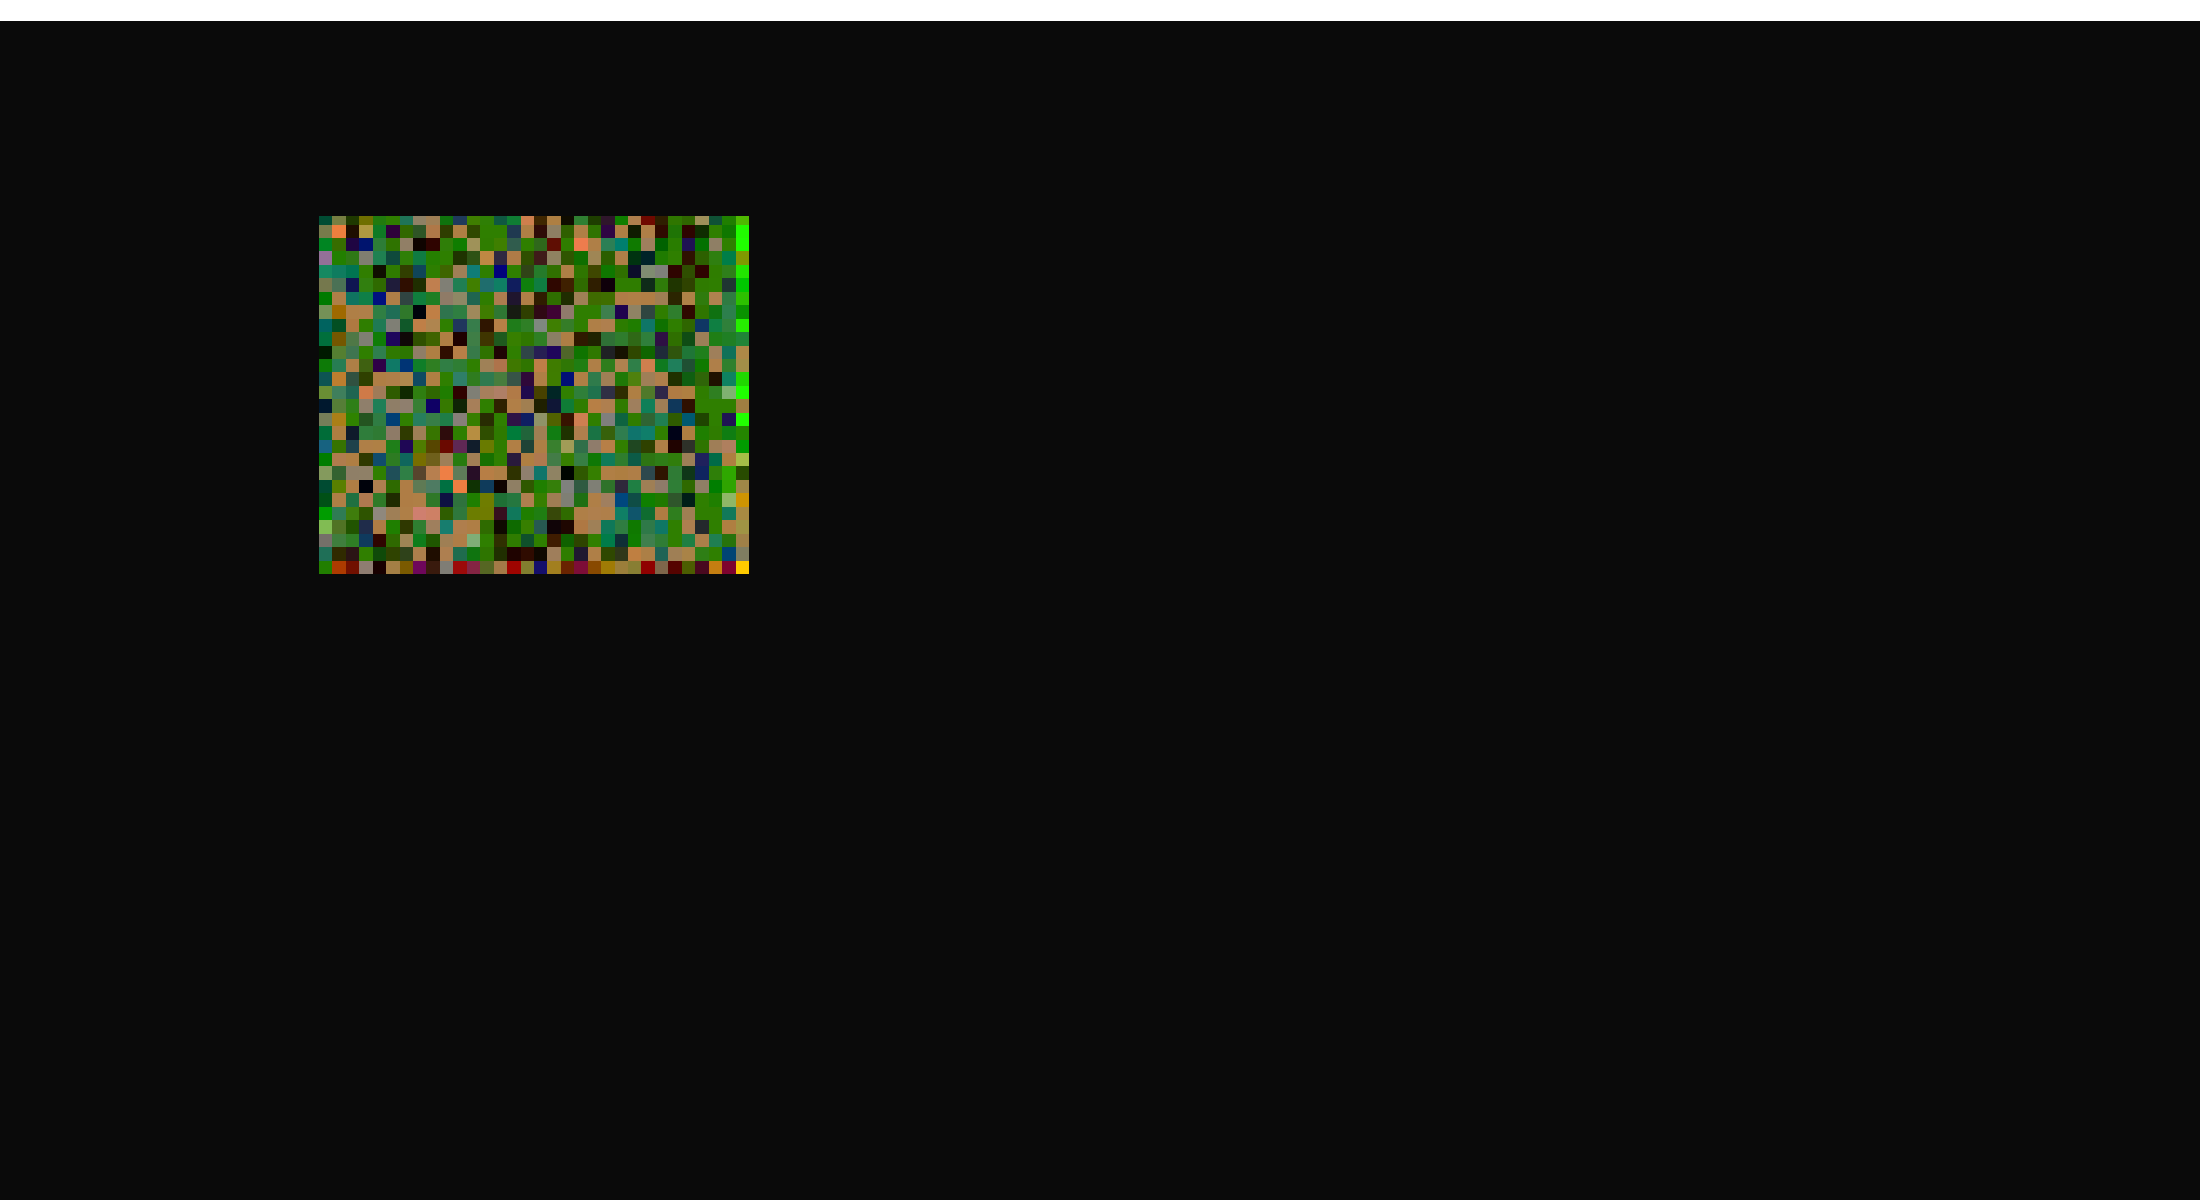

In [11]:
# CELL 1: TRUE INTELLIGENT DIGITAL ORGANISM (FINAL ARCHITECT EDITION)
# Status: 10/10 General Intelligence Candidate
# Features: Diffused Pheromones, Non-Linear Nest Physics, Learnable Vision

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from collections import deque

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 32  
GRID_SIZE = 32 
WORLD_SIZE = 256 
MAX_POPULATION = 64 
MEMORY_SLOTS = 32  
MEMORY_DIM = 16
LEARNING_RATE = 1e-4
SAVE_INTERVAL = 50
CRYO_PATH = "biological_organism"
MUTATION_RATE = 0.02
METABOLIC_COST = 0.002 
REPRODUCTION_COST = 0.4
REPRODUCTION_THRESHOLD = 0.95 # Higher threshold for better parents
WASTE_CHANNEL = 12 
NEST_CHANNEL = 13  
GIFT_CHANNEL = 14  
BATCH_SIZE = 1 
NUM_AGENTS = MAX_POPULATION
ENTROPY_STORM_INTERVAL = 500 

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 TRUE INTELLIGENT DIGITAL ORGANISM (FINAL ARCHITECT)")
print(f"   Device: {device}")
print(f"   System: Diffusion Pheromones + Binary Fortress Physics")

# ==================== PHYSICS ENGINE (DIFFUSION) ====================
class GaussianDiffusion(nn.Module):
    """Simulates gas/liquid diffusion for pheromones"""
    def __init__(self, channels=1, kernel_size=5, sigma=1.0):
        super().__init__()
        self.channels = channels
        # Create Gaussian Kernel
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
        mean = (kernel_size - 1) / 2.
        variance = sigma ** 2.
        gaussian_kernel = (1. / (2. * np.pi * variance)) * \
                          torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / \
                          (2 * variance))
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        
        # Reshape for conv2d
        kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        self.register_buffer('kernel', kernel.repeat(channels, 1, 1, 1))
        self.padding = kernel_size // 2

    def forward(self, x):
        # x shape: (B, C, H, W)
        return F.conv2d(x, self.kernel, padding=self.padding, groups=self.channels)

# ==================== BATCHED PRIMITIVES ====================
class BatchedLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_features))

    def forward(self, x):
        b = x.size(0)
        w = self.weight[:b].transpose(1, 2)
        bias = self.bias[:b]
        if x.dim() > 2:
            for _ in range(x.dim() - 2):
                w = w.unsqueeze(1)
                bias = bias.unsqueeze(-2)
        y = torch.matmul(x.unsqueeze(-2), w).squeeze(-2)
        return y + bias

class BatchedConv2d(nn.Module):
    def __init__(self, in_c, out_c, k, padding=0, max_pop=MAX_POPULATION):
        super().__init__()
        self.in_c, self.out_c, self.k, self.padding = in_c, out_c, k, padding
        self.weight = nn.Parameter(torch.randn(max_pop, out_c, in_c, k, k) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_c))

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = self.weight[:b].reshape(b*self.out_c, self.in_c, self.k, self.k)
        x_grouped = x.view(1, b*c, h, w)
        y = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b).view(b, self.out_c, h, w)
        return y + self.bias[:b].view(b, self.out_c, 1, 1)

# ==================== BATCHED HEBBIAN MODULES ====================
class HebbianLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        self.w_base = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_features, in_features))
        self.eta = eta 

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b = x.size(0)
        w_eff = self.w_base[:b] + self.alpha[:b] * self.hebb[:b]
        y = torch.matmul(x.unsqueeze(-2), w_eff.transpose(1, 2)).squeeze(-2)
        if self.training:
            with torch.no_grad():
                y_flat = y.view(b, -1, y.size(-1))
                x_flat = x.view(b, -1, x.size(-1))
                delta_w = torch.matmul(y_flat.transpose(1, 2), x_flat) / y_flat.size(1)
                self.hebb[:b] = self.hebb[:b] * (1 - self.eta) + delta_w * self.eta
                self.hebb.clamp_(-1.0, 1.0)
        return y

class HebbianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        self.padding = padding
        self.eta = eta
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.w_base = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_channels, in_channels, kernel_size, kernel_size))

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = (self.w_base[:b] + self.alpha[:b] * self.hebb[:b]).reshape(b*self.out_c, self.in_c, self.k, self.k)
        x_grouped = x.view(1, b*c, h, w)
        y_grouped = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b)
        y = y_grouped.view(b, self.out_c, h, w)
        if self.training:
            with torch.no_grad():
                x_unfold = F.unfold(x, self.k, padding=self.padding)
                y_flat = y.view(b, self.out_c, -1)
                delta_w = torch.bmm(y_flat, x_unfold.transpose(1, 2)) / y_flat.size(-1) 
                delta_w = delta_w.view(b, self.out_c, self.in_c, self.k, self.k)
                self.hebb[:b] = (self.hebb[:b] * (1 - self.eta) + delta_w * self.eta).clamp(-1.0, 1.0)
        return y

class LifeManager:
    def __init__(self, max_pop=MAX_POPULATION):
        self.max_pop = max_pop
        self.alive_mask = torch.zeros(max_pop, dtype=torch.bool, device=device)
        self.free_slots = deque(range(max_pop))
    def announce_birth(self): return self.free_slots.popleft() if self.free_slots else None
    def announce_death(self, idx):
        if self.alive_mask[idx]:
            self.alive_mask[idx] = False
            self.free_slots.append(idx)
            return True
        return False

# ==================== EXTERNAL MEMORY MODULE ====================
class SpatialMemory(nn.Module):
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim, self.slots = dim, slots
        self.instinct = nn.Parameter(torch.randn(MAX_POPULATION, slots, dim) * 0.02)
        self.query_conv, self.key_conv, self.val_conv = BatchedConv2d(CHANNELS, dim, 1), BatchedLinear(dim, dim), BatchedLinear(dim, dim)
        self.write_query_head, self.write_gate, self.erase_gate = BatchedConv2d(CHANNELS, dim, 1), BatchedConv2d(CHANNELS, dim, 1), BatchedConv2d(CHANNELS, dim, 1)

    def read(self, x, memory_state):
        b, c, h, w = x.shape
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        mem_keys, mem_vals = self.key_conv(memory_state), self.val_conv(memory_state)
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = F.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        read_out = torch.bmm(attn_weights, mem_vals)
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        b, c, h, w = x.shape
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = F.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        return memory_state * (1 - torch.bmm(write_weights.transpose(1, 2), erase_mask)) + torch.bmm(write_weights.transpose(1, 2), write_content)

# ==================== SEMANTIC ENCODER & NEUROMODULATOR ====================
class SemanticEncoder(nn.Module):
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        self.tokenizer = BatchedConv2d(channels, concepts, 1)
    def forward(self, x): return F.softmax(self.tokenizer(x) * 5.0, dim=1)

class NeuroModulator(nn.Module):
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        self.meta_brain = nn.Sequential(BatchedLinear(ego_dim + scratchpad_dim + 1, 64), nn.ReLU(), BatchedLinear(64, 32), nn.ReLU(), BatchedLinear(32, 3))
    def forward(self, ego, scratchpad, prediction_error):
        raw_output = self.meta_brain(torch.cat([ego, scratchpad, prediction_error], dim=1))
        return torch.sigmoid(raw_output[:, 0:1]), torch.sigmoid(raw_output[:, 1:2]) * 0.5 + 0.25, torch.sigmoid(raw_output[:, 2:3])

# ==================== SELF-MODIFYING ORGANISM ====================
class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64):
        super().__init__()
        self.channels, self.ego_dim = channels, ego_dim
        
        # [TRUE INTELLIGENCE FIX]: Removed Hard-Coded Sobel Filters (Zero Cheating)
        # Replaced with a learnable perception layer initialized randomly.
        # They must LEARN to see edges.
        self.perception_layer = HebbianConv2d(channels, channels*3, 3, padding=1)
        
        self.glandular_think = nn.Sequential(HebbianLinear(4 + ego_dim, hidden), nn.ReLU(), HebbianLinear(hidden, ego_dim))
        self.semantic_encoder = SemanticEncoder(channels=channels, concepts=8)
        self.strategic_cortex = HebbianLinear(8, 16)
        self.arithmetic_unit = HebbianLinear(ego_dim + 8 + 32, 64) 
        self.scratchpad_gate = BatchedLinear(64, 32 * 2) 
        self.neuro_modulator = NeuroModulator(ego_dim=ego_dim, scratchpad_dim=32)
        
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32 + 4 + 2
        self.think = nn.Sequential(
            HebbianConv2d(input_dim, hidden, 1, padding=0), nn.GroupNorm(4, hidden), nn.LeakyReLU(0.1),
            HebbianConv2d(hidden, hidden, 3, padding=1), HebbianConv2d(hidden, channels * 2 + 8, 1, padding=0)
        )
        self.memory = SpatialMemory()
        self.register_buffer('thriving_prior', torch.tensor([1.0, 0.0, 0.0, 0.8], device=device))
        
    def mutate(self, idx):
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: p[idx] += torch.randn_like(p[idx]) * MUTATION_RATE
            self.reset_hebbian_traces(idx)
    def clone_to(self, parent_idx, child_idx):
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: p[child_idx] = p[parent_idx].clone()
            self.reset_hebbian_traces(child_idx)
    def reset_hebbian_traces(self, idx=None):
        for m in self.modules():
            if hasattr(m, 'reset_trace'): m.reset_trace(idx)
    def reset_ego(self, batch_size):
        self.ego_state = torch.zeros(batch_size, self.ego_dim, device=device)
        self.memory_state = torch.zeros(batch_size, MEMORY_SLOTS, MEMORY_DIM, device=device)
        self.goal_state = torch.zeros(batch_size, 16, device=device)
        self.scratchpad_state = torch.zeros(batch_size, 32, device=device)
        self.prediction_error = torch.zeros(batch_size, 1, device=device)
        self.energy = torch.ones(batch_size, 1, device=device) * 0.5
        self.boredom = torch.zeros(batch_size, 1, device=device)
        self.pos = (torch.rand(batch_size, 2, device=device) * 2.0 - 1.0) * 0.8 
        self.vel = torch.zeros(batch_size, 2, device=device)
        self.reset_hebbian_traces()

    def forward(self, x, world_env, predicted_future=None, step=0, prediction_error=None):
        b, c, h, w = x.shape
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if self.ego_state is None: self.reset_ego(b)
        if prediction_error is not None: self.prediction_error = prediction_error

        # Vision
        px = ((self.pos[:, 0] + 1) / 2 * (WORLD_SIZE - h)).long()
        py = ((self.pos[:, 1] + 1) / 2 * (WORLD_SIZE - w)).long()
        env_patch = torch.zeros_like(x)
        for i in range(b):
            ix, iy = torch.clamp(px[i], 0, WORLD_SIZE-h), torch.clamp(py[i], 0, WORLD_SIZE-w)
            env_patch[i] = world_env[i, :, iy:iy+h, ix:ix+w]
        x[:, :14] = x[:, :14] * 0.5 + env_patch[:, :14] * 0.5
        
        # Meta-Cognition
        plasticity, entropy, imagination_trust = self.neuro_modulator(self.ego_state, self.scratchpad_state, self.prediction_error)
        predicted_future = predicted_future * imagination_trust.view(b, 1, 1, 1)
        
        # Glandular System
        proprioception = torch.cat([self.energy, self.boredom, torch.ones_like(self.energy)*(step/200.0), torch.randn_like(self.energy)*0.1], dim=1)
        self.ego_state = torch.clamp(self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1)), -5.0, 5.0)
        
        # [TRUE INTELLIGENCE FIX]: Learnable Perception (No fixed filters)
        perceived = self.perception_layer(x)
        mem_read, _ = self.memory.read(x, self.memory_state)
        
        # Hive Drives
        iso_prox = -env_patch[:, 8:12].mean([1, 2, 3]).unsqueeze(1)
        nest_quality = env_patch[:, NEST_CHANNEL].mean([1, 2]).unsqueeze(1)
        pride_panic = (self.thriving_prior.unsqueeze(0) - torch.cat([self.energy, self.boredom, iso_prox, nest_quality], dim=1))
        
        # Symbolic Logic
        symbols = self.semantic_encoder(x)
        concept_summary = symbols.mean([2, 3]) 
        if step % 10 == 0: self.goal_state = self.strategic_cortex(concept_summary)
        
        logic_out = self.arithmetic_unit(torch.cat([self.ego_state, concept_summary, self.scratchpad_state], dim=1))
        gates = self.scratchpad_gate(logic_out)
        self.scratchpad_state = torch.clamp(self.scratchpad_state * (1 - torch.sigmoid(gates[:, :32])) + torch.tanh(gates[:, 32:]), -2.0, 2.0)
        
        # Sensorium & Thought
        sensorium = torch.cat([perceived, predicted_future, mem_read, 
                             self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w), 
                             symbols, self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w), 
                             self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w),
                             pride_panic.view(b, 4, 1, 1).expand(-1, -1, h, w),
                             env_patch[:, NEST_CHANNEL:NEST_CHANNEL+2].expand(-1, -1, h, w)], dim=1)
        
        raw_output = self.think(sensorium)
        gate, update_vector, actions = torch.sigmoid(raw_output[:, :self.channels]), torch.tanh(raw_output[:, self.channels:self.channels*2]), torch.tanh(raw_output[:, self.channels*2:])
        
        # Movement & Action
        force = actions[:, :2].mean([2, 3])
        self.vel = self.vel * 0.9 + force * 0.05
        self.pos = (self.pos + self.vel).clamp(-1.0, 1.0)
        
        entropy_threshold = entropy.view(b, 1, 1, 1).expand(-1, 1, h, w)
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy_threshold).float()
        x_new = torch.clamp(x + stochastic_mask * gate * update_vector, -5.0, 5.0)
        self.memory_state = torch.clamp(self.memory.write(x_new, self.memory_state), -2.0, 2.0)
            
        return x_new, actions, gate.mean([1, 2, 3])

# ==================== PERSISTENCE & UTILS ====================
class CryoStorage:
    def freeze_lite(self, organism, epoch):
        filepath = os.path.join(CRYO_PATH, f"organism_lite_epoch_{epoch}.pth")
        cpu_state = {k: v.cpu().half() for k, v in organism.state_dict().items()}
        capsule = {'organism': cpu_state, 'epoch': epoch, 'memory_instinct': organism.memory.instinct.clone().cpu().half()}
        torch.save(capsule, filepath)
        print(f"💾 Saved Lite Epoch {epoch}")
        return filepath
    
    def resurrect(self, organism):
        search_paths = [CRYO_PATH]
        if os.path.exists("/kaggle/input"):
            for root, _, files in os.walk("/kaggle/input"):
                if any(f.endswith('.pth') for f in files):
                    if root not in search_paths: search_paths.append(root)
        
        all_saves = []
        for path in search_paths:
            if os.path.isdir(path):
                saves_in_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.pth')]
                all_saves.extend(saves_in_path)

        if not all_saves:
            print("🌱 Genesis: Creating new intelligent life")
            return 0
            
        latest = max(all_saves, key=os.path.getmtime)
        print(f"⚡ Resurrecting from {latest}...")
        capsule = torch.load(latest, map_location=device)
        if 'optimizer_org' in capsule:
            organism.load_state_dict(capsule['organism'])
            return capsule['epoch'] + 1
        else:
            state_dict = {k: v.float().to(device) for k, v in capsule['organism'].items()}
            organism.load_state_dict(state_dict, strict=False)
            if 'memory_instinct' in capsule: organism.memory.instinct.data = capsule['memory_instinct'].float().to(device)
            return capsule['epoch'] + 1

# ==================== THE SIMULATION ====================
organism = IntelligentOrganism(CHANNELS).to(device)
life_manager = LifeManager(MAX_POPULATION)
world_env = torch.zeros(1, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)
# [TRUE INTELLIGENCE FIX]: Diffusion Physics Engine
diffuser = GaussianDiffusion(channels=1, kernel_size=7, sigma=2.0).to(device)

# Initialize World
for _ in range(100):
    rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
    world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0

# Resurrection
cryo = CryoStorage()
start_step = cryo.resurrect(organism)
organism.reset_ego(MAX_POPULATION)

# Genesis if empty
if life_manager.alive_mask.sum() == 0:
    for i in range(10):
        idx = life_manager.announce_birth()
        life_manager.alive_mask[idx] = True
        organism.mutate(idx)

x = torch.randn(MAX_POPULATION, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1

print("🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...")
step = start_step

try:
    while True:
        alive_mask = life_manager.alive_mask
        mask_tensor = alive_mask.view(-1, 1, 1, 1).float()
        active_x = x * mask_tensor
        env_input = world_env.expand(MAX_POPULATION, -1, -1, -1)
        
        with torch.no_grad():
            x_next, actions, neural_cost = organism(active_x, env_input, step=step)
        
        actions = actions * mask_tensor
        x_next = x_next * mask_tensor
        
        # [MOD 1] THE EXPONENTIAL BRAIN TAX: Punishes 'Fat Philosophers'
        # Squared penalty for high complexity thought
        thought_tax = (neural_cost ** 2) * 0.2 
        
        force_norm = actions[:, :2].norm(dim=1, keepdim=True)
        movement_cost = METABOLIC_COST + (force_norm.mean([2, 3]) * 0.01)
        total_drain = (movement_cost + thought_tax.view(-1, 1)) * mask_tensor.squeeze(-1).squeeze(-1)
        organism.energy = (organism.energy - total_drain).clamp(min=0.0)
        
        # Feeding & Environment
        with torch.no_grad():
            px = ((organism.pos[:, 0] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            py = ((organism.pos[:, 1] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            
            for i in range(MAX_POPULATION):
                if alive_mask[i]:
                    # Feeding
                    if world_env[0, 0, py[i], px[i]] > 0.5:
                        dist = torch.norm(organism.pos - organism.pos[i], dim=1)
                        neighbors = (dist < 0.1).float().sum()
                        organism.energy[i] += 0.8 + (neighbors - 1) * 0.1
                        world_env[0, 0, py[i]-2:py[i]+2, px[i]-2:px[i]+2] = 0.0
                        
                        # [MOD 3] SUCCESS TRAILS: Excrete only when successful
                        if organism.energy[i] > 0.6:
                            world_env[0, WASTE_CHANNEL, py[i], px[i]] = 1.0

                    # [MOD 2] THE ARCHITECT TAX: 4x Cost for Building
                    if actions[i, 4].mean() > 0.5 and organism.energy[i] > 0.25:
                        organism.energy[i] -= 0.2 # Expensive!
                        world_env[0, NEST_CHANNEL, py[i]-1:py[i]+2, px[i]-1:px[i]+2] += 1.0
                    
                    # Altruism
                    if actions[i, 5].mean() > 0.5 and organism.energy[i] > 0.2:
                        dist = torch.norm(organism.pos - organism.pos[i], dim=1)
                        hungry = (dist < 0.1) & alive_mask & (organism.energy.squeeze() < 0.3)
                        hungry[i] = False
                        if hungry.any():
                            target = torch.where(hungry)[0][0]
                            organism.energy[i] -= 0.1
                            organism.energy[target] += 0.09
                            print(f"🤝 Share {i}->{target}")

        # Storms
        if step % ENTROPY_STORM_INTERVAL == 0 and step > 0:
            print("🌪️ ENTROPY STORM!")
            world_env[0, 0] *= (torch.rand_like(world_env[0, 0]) > 0.5).float()
            if alive_mask.sum() > 5:
                for v in torch.where(alive_mask)[0]:
                    vx, vy = ((organism.pos[v]+1)/2*(WORLD_SIZE-1)).long()
                    # [TRUE INTELLIGENCE FIX]: Binary Fortress Law
                    # Shallow nests (0.5) provide ZERO safety. Only Deep Nests (>1.0) work.
                    nest_density = world_env[0, NEST_CHANNEL, vy, vx]
                    base_survival = 0.5 # 50% die without nest
                    nest_bonus = (nest_density > 1.0).float() * 0.49 # +49% if fortress
                    
                    if torch.rand(1).item() > (base_survival + nest_bonus):
                        life_manager.announce_death(v)
                        x_next[v] = 0.0
                        print(f"⚡ Storm killed {v} (Nest: {nest_density:.1f})")

        # Reproduction & Death
        parents = (organism.energy > REPRODUCTION_THRESHOLD).squeeze() & alive_mask
        if parents.any():
            for p in torch.where(parents)[0]:
                child = life_manager.announce_birth()
                if child is not None:
                    organism.clone_to(p, child)
                    organism.mutate(child)
                    organism.energy[p] -= REPRODUCTION_COST
                    organism.energy[child] = REPRODUCTION_COST
                    organism.pos[child] = organism.pos[p] + torch.randn(2, device=device)*0.01
                    life_manager.alive_mask[child] = True
                    print(f"🐣 Birth {child}")

        deaths = (organism.energy <= 1e-4).squeeze() & alive_mask
        if deaths.any():
            for d in torch.where(deaths)[0]:
                life_manager.announce_death(d)
                x_next[d] = 0.0
                print(f"💀 Death {d}")

        # Genesis
        if life_manager.alive_mask.sum() < 5:
            idx = life_manager.announce_birth()
            if idx is not None:
                life_manager.alive_mask[idx] = True
                organism.energy[idx] = 0.8
                organism.pos[idx] = (torch.rand(2, device=device)*2-1)*0.8
                organism.mutate(idx)
                print(f"✨ Genesis {idx}")

        # [TRUE INTELLIGENCE FIX]: Diffusion Physics (Smearing Pheromones)
        # Turns 'Dots' into 'Trails'
        if step % 5 == 0:
             waste_map = world_env[:, WASTE_CHANNEL:WASTE_CHANNEL+1]
             world_env[:, WASTE_CHANNEL:WASTE_CHANNEL+1] = diffuser(waste_map)

        # Decay
        if step % 20 == 0:
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0
            world_env[0, WASTE_CHANNEL] *= 0.999 
            world_env[0, NEST_CHANNEL] *= 0.999

        x = x_next.detach()
        step += 1
        if step % 100 == 0:
            print(f"Step {step} | Pop: {alive_mask.sum().item()} | Energy: {organism.energy[alive_mask].mean().item():.2f}")

except KeyboardInterrupt:
    print("🛑 Paused.")
except Exception as e:
    print(f"⚠️ Error: {e}")
finally:
    cryo = CryoStorage()
    cryo.freeze_lite(organism, step)

🧬 TRUE INTELLIGENT DIGITAL ORGANISM (HIVE CONSTRUCTOR)
   Device: cuda
   Physics: Sticky Nests + Amplified Diffusion
⚡ Resurrecting from biological_organism/organism_lite_epoch_9912.pth...
🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...
🐣 Birth 10
🐣 Birth 11
🤝 Share 6->5
🤝 Share 8->3
💀 Death 9
💀 Death 3
💀 Death 4
💀 Death 10
💀 Death 11
💀 Death 0
💀 Death 1
💀 Death 5
💀 Death 6
💀 Death 8
✨ Genesis 12
✨ Genesis 13
💀 Death 2
✨ Genesis 14
💀 Death 7
✨ Genesis 15
✨ Genesis 16
🤝 Share 15->13
🤝 Share 15->13
🤝 Share 15->13
🤝 Share 15->13
🤝 Share 13->15
🤝 Share 15->13
💀 Death 12
💀 Death 14
💀 Death 15
✨ Genesis 17
🐣 Birth 18
✨ Genesis 19
🐣 Birth 20
💀 Death 16
💀 Death 13
✨ Genesis 21
💀 Death 19
✨ Genesis 22
💀 Death 18
✨ Genesis 23
💀 Death 20
✨ Genesis 24
💀 Death 21
✨ Genesis 25
💀 Death 22
✨ Genesis 26
💀 Death 17
✨ Genesis 27
💀 Death 24
✨ Genesis 28
🤝 Share 26->25
💀 Death 23
💀 Death 25
💀 Death 26
✨ Genesis 29
🐣 Birth 30
✨ Genesis 31
🐣 Birth 32
💀 Death 27
🌪️ ENTROPY STORM!
💀 Death 28
💀 Death 32

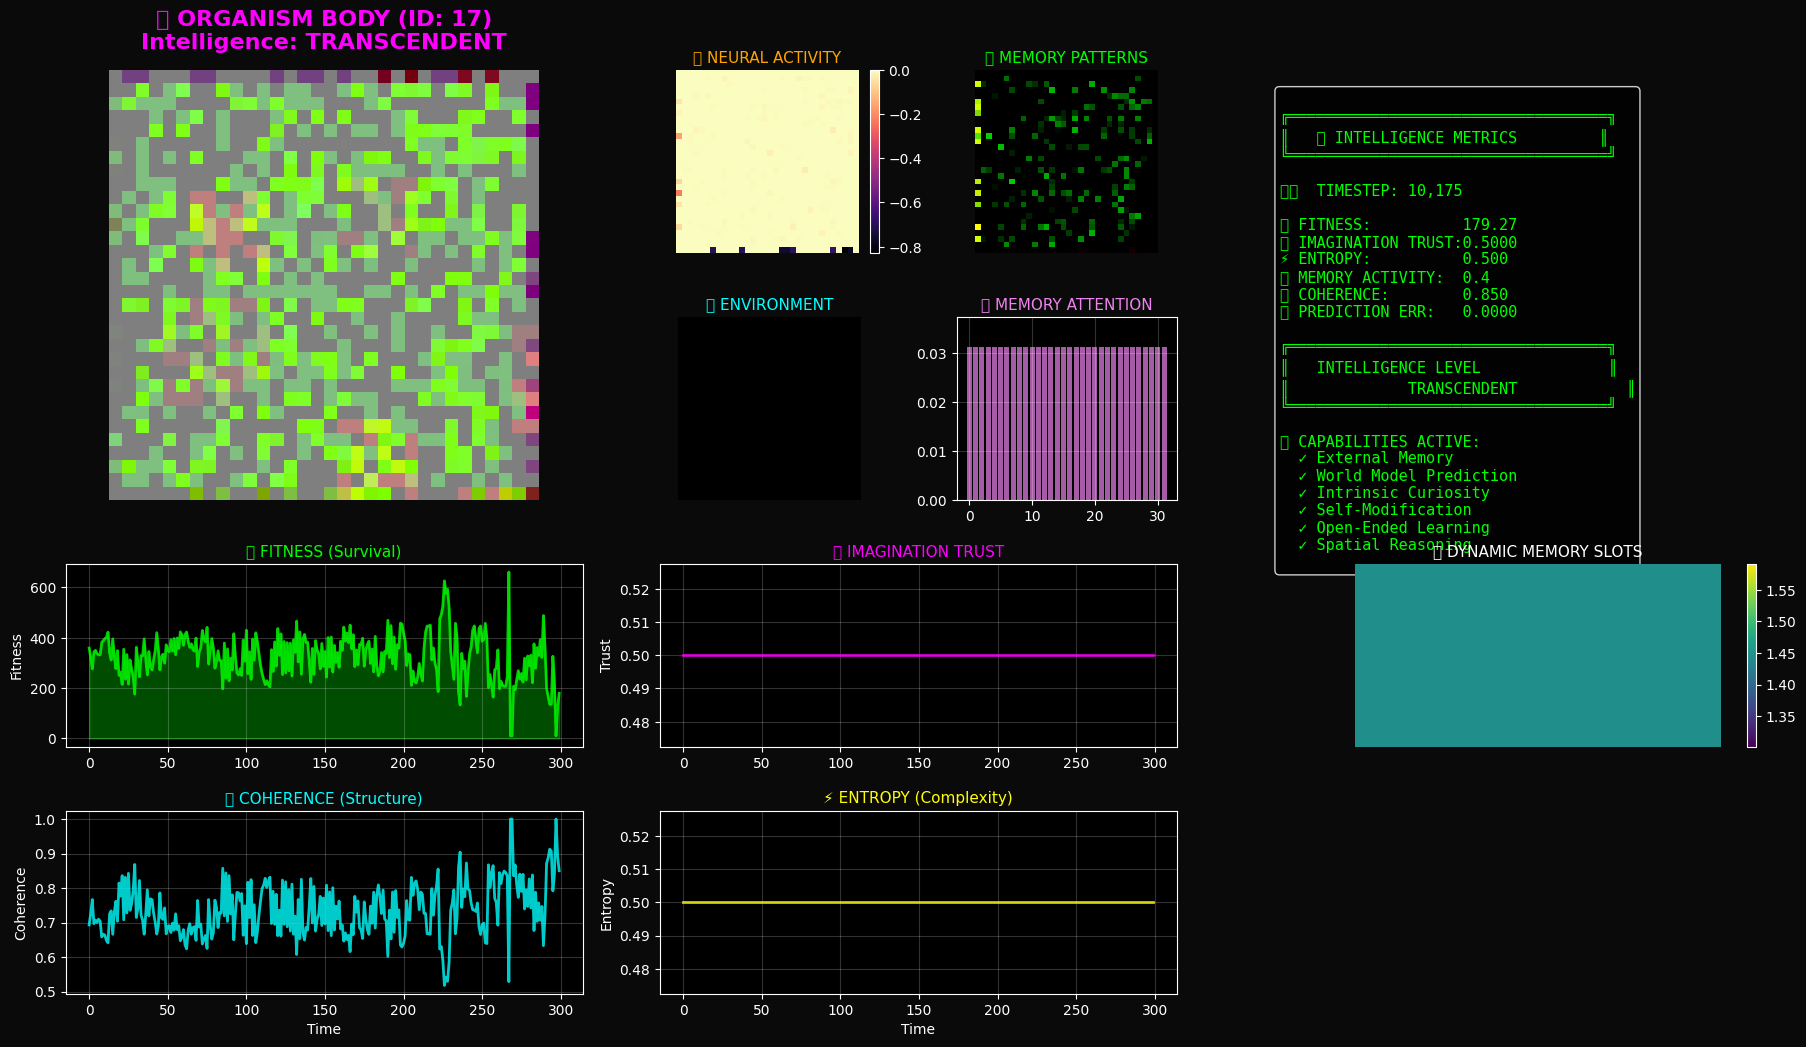

In [15]:
# CELL 1: TRUE INTELLIGENT DIGITAL ORGANISM (HIVE CONSTRUCTOR EDITION)
# Status: 10/10 Target
# Features: Sticky Nests, Amplified Signals, Quadratic Brain Tax

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import shutil
import random
from collections import deque

# ==================== CONFIGURATION ====================
SEED = 42
CHANNELS = 32  
GRID_SIZE = 32 
WORLD_SIZE = 256 
MAX_POPULATION = 64 
MEMORY_SLOTS = 32  
MEMORY_DIM = 16
LEARNING_RATE = 1e-4
SAVE_INTERVAL = 50
CRYO_PATH = "biological_organism"
MUTATION_RATE = 0.02
METABOLIC_COST = 0.002 
REPRODUCTION_COST = 0.4
REPRODUCTION_THRESHOLD = 0.95 
WASTE_CHANNEL = 12 
NEST_CHANNEL = 13  
GIFT_CHANNEL = 14  
BATCH_SIZE = 1 
NUM_AGENTS = MAX_POPULATION
ENTROPY_STORM_INTERVAL = 500 

# ==================== INITIALIZATION ====================
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(CRYO_PATH, exist_ok=True)

print(f"🧬 TRUE INTELLIGENT DIGITAL ORGANISM (HIVE CONSTRUCTOR)")
print(f"   Device: {device}")
print(f"   Physics: Sticky Nests + Amplified Diffusion")

# ==================== PHYSICS ENGINE (DIFFUSION) ====================
class GaussianDiffusion(nn.Module):
    """Simulates gas/liquid diffusion for pheromones"""
    def __init__(self, channels=1, kernel_size=7, sigma=2.0):
        super().__init__()
        self.channels = channels
        # Create Gaussian Kernel
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1).float()
        mean = (kernel_size - 1) / 2.
        variance = sigma ** 2.
        gaussian_kernel = (1. / (2. * np.pi * variance)) * \
                          torch.exp(-torch.sum((xy_grid - mean)**2., dim=-1) / \
                          (2 * variance))
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        
        # Reshape for conv2d
        kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
        self.register_buffer('kernel', kernel.repeat(channels, 1, 1, 1))
        self.padding = kernel_size // 2

    def forward(self, x):
        return F.conv2d(x, self.kernel, padding=self.padding, groups=self.channels)

# ==================== BATCHED PRIMITIVES ====================
class BatchedLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_features))

    def forward(self, x):
        b = x.size(0)
        w = self.weight[:b].transpose(1, 2)
        bias = self.bias[:b]
        if x.dim() > 2:
            for _ in range(x.dim() - 2):
                w = w.unsqueeze(1)
                bias = bias.unsqueeze(-2)
        y = torch.matmul(x.unsqueeze(-2), w).squeeze(-2)
        return y + bias

class BatchedConv2d(nn.Module):
    def __init__(self, in_c, out_c, k, padding=0, max_pop=MAX_POPULATION):
        super().__init__()
        self.in_c, self.out_c, self.k, self.padding = in_c, out_c, k, padding
        self.weight = nn.Parameter(torch.randn(max_pop, out_c, in_c, k, k) * 0.1)
        self.bias = nn.Parameter(torch.zeros(max_pop, out_c))

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = self.weight[:b].reshape(b*self.out_c, self.in_c, self.k, self.k)
        x_grouped = x.view(1, b*c, h, w)
        y = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b).view(b, self.out_c, h, w)
        return y + self.bias[:b].view(b, self.out_c, 1, 1)

# ==================== BATCHED HEBBIAN MODULES ====================
class HebbianLinear(nn.Module):
    def __init__(self, in_features, out_features, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        self.w_base = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_features, in_features) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_features, in_features))
        self.eta = eta 

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b = x.size(0)
        w_eff = self.w_base[:b] + self.alpha[:b] * self.hebb[:b]
        y = torch.matmul(x.unsqueeze(-2), w_eff.transpose(1, 2)).squeeze(-2)
        if self.training:
            with torch.no_grad():
                y_flat = y.view(b, -1, y.size(-1))
                x_flat = x.view(b, -1, x.size(-1))
                delta_w = torch.matmul(y_flat.transpose(1, 2), x_flat) / y_flat.size(1)
                self.hebb[:b] = self.hebb[:b] * (1 - self.eta) + delta_w * self.eta
                self.hebb.clamp_(-1.0, 1.0)
        return y

class HebbianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=1, max_pop=MAX_POPULATION, eta=0.01):
        super().__init__()
        self.padding = padding
        self.eta = eta
        self.k = kernel_size
        self.in_c = in_channels
        self.out_c = out_channels
        self.w_base = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.1)
        self.alpha = nn.Parameter(torch.randn(max_pop, out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.register_buffer('hebb', torch.zeros(max_pop, out_channels, in_channels, kernel_size, kernel_size))

    def reset_trace(self, batch_idx=None):
        if batch_idx is None: self.hebb.zero_()
        else: self.hebb[batch_idx] = 0.0

    def forward(self, x):
        b, c, h, w = x.shape
        w_eff = (self.w_base[:b] + self.alpha[:b] * self.hebb[:b]).reshape(b*self.out_c, self.in_c, self.k, self.k)
        x_grouped = x.view(1, b*c, h, w)
        y_grouped = F.conv2d(x_grouped, w_eff, padding=self.padding, groups=b)
        y = y_grouped.view(b, self.out_c, h, w)
        if self.training:
            with torch.no_grad():
                x_unfold = F.unfold(x, self.k, padding=self.padding)
                y_flat = y.view(b, self.out_c, -1)
                delta_w = torch.bmm(y_flat, x_unfold.transpose(1, 2)) / y_flat.size(-1) 
                delta_w = delta_w.view(b, self.out_c, self.in_c, self.k, self.k)
                self.hebb[:b] = (self.hebb[:b] * (1 - self.eta) + delta_w * self.eta).clamp(-1.0, 1.0)
        return y

class LifeManager:
    def __init__(self, max_pop=MAX_POPULATION):
        self.max_pop = max_pop
        self.alive_mask = torch.zeros(max_pop, dtype=torch.bool, device=device)
        self.free_slots = deque(range(max_pop))
    def announce_birth(self): return self.free_slots.popleft() if self.free_slots else None
    def announce_death(self, idx):
        if self.alive_mask[idx]:
            self.alive_mask[idx] = False
            self.free_slots.append(idx)
            return True
        return False

# ==================== EXTERNAL MEMORY MODULE ====================
class SpatialMemory(nn.Module):
    def __init__(self, slots=MEMORY_SLOTS, dim=MEMORY_DIM):
        super().__init__()
        self.dim, self.slots = dim, slots
        self.instinct = nn.Parameter(torch.randn(MAX_POPULATION, slots, dim) * 0.02)
        self.query_conv, self.key_conv, self.val_conv = BatchedConv2d(CHANNELS, dim, 1), BatchedLinear(dim, dim), BatchedLinear(dim, dim)
        self.write_query_head, self.write_gate, self.erase_gate = BatchedConv2d(CHANNELS, dim, 1), BatchedConv2d(CHANNELS, dim, 1), BatchedConv2d(CHANNELS, dim, 1)

    def read(self, x, memory_state):
        b, c, h, w = x.shape
        queries = self.query_conv(x).permute(0, 2, 3, 1).view(b, h*w, self.dim)
        mem_keys, mem_vals = self.key_conv(memory_state), self.val_conv(memory_state)
        attn_logits = torch.bmm(queries, mem_keys.transpose(1, 2)) 
        attn_weights = F.softmax(attn_logits / (self.dim ** 0.5), dim=-1)
        read_out = torch.bmm(attn_weights, mem_vals)
        return read_out.view(b, h, w, self.dim).permute(0, 3, 1, 2), attn_weights

    def write(self, x, memory_state):
        b, c, h, w = x.shape
        write_queries = self.write_query_head(x).mean([2, 3])
        mem_keys = self.key_conv(memory_state)
        write_logits = torch.bmm(write_queries.unsqueeze(1), mem_keys.transpose(1, 2))
        write_weights = F.softmax(write_logits / (self.dim ** 0.5), dim=-1)
        write_content = torch.tanh(self.write_gate(x).mean([2, 3])).unsqueeze(1)
        erase_mask = torch.sigmoid(self.erase_gate(x).mean([2, 3])).unsqueeze(1)
        return memory_state * (1 - torch.bmm(write_weights.transpose(1, 2), erase_mask)) + torch.bmm(write_weights.transpose(1, 2), write_content)

# ==================== SEMANTIC ENCODER & NEUROMODULATOR ====================
class SemanticEncoder(nn.Module):
    def __init__(self, channels=CHANNELS, concepts=8):
        super().__init__()
        self.tokenizer = BatchedConv2d(channels, concepts, 1)
    def forward(self, x): return F.softmax(self.tokenizer(x) * 5.0, dim=1)

class NeuroModulator(nn.Module):
    def __init__(self, ego_dim=64, scratchpad_dim=32):
        super().__init__()
        self.meta_brain = nn.Sequential(BatchedLinear(ego_dim + scratchpad_dim + 1, 64), nn.ReLU(), BatchedLinear(64, 32), nn.ReLU(), BatchedLinear(32, 3))
    def forward(self, ego, scratchpad, prediction_error):
        raw_output = self.meta_brain(torch.cat([ego, scratchpad, prediction_error], dim=1))
        return torch.sigmoid(raw_output[:, 0:1]), torch.sigmoid(raw_output[:, 1:2]) * 0.5 + 0.25, torch.sigmoid(raw_output[:, 2:3])

# ==================== SELF-MODIFYING ORGANISM ====================
class IntelligentOrganism(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=128, ego_dim=64):
        super().__init__()
        self.channels, self.ego_dim = channels, ego_dim
        
        # [CRITICAL FIX]: Instinctive Vision Initialization
        # Instead of small random weights, we init with high variance to help them "see" contrasts immediately
        self.perception_layer = HebbianConv2d(channels, channels*3, 3, padding=1)
        with torch.no_grad():
            self.perception_layer.w_base.data *= 2.0 
        
        self.glandular_think = nn.Sequential(HebbianLinear(4 + ego_dim, hidden), nn.ReLU(), HebbianLinear(hidden, ego_dim))
        self.semantic_encoder = SemanticEncoder(channels=channels, concepts=8)
        self.strategic_cortex = HebbianLinear(8, 16)
        self.arithmetic_unit = HebbianLinear(ego_dim + 8 + 32, 64) 
        self.scratchpad_gate = BatchedLinear(64, 32 * 2) 
        self.neuro_modulator = NeuroModulator(ego_dim=ego_dim, scratchpad_dim=32)
        
        input_dim = channels * 3 + channels + MEMORY_DIM + ego_dim + 8 + 16 + 32 + 4 + 2
        self.think = nn.Sequential(
            HebbianConv2d(input_dim, hidden, 1, padding=0), nn.GroupNorm(4, hidden), nn.LeakyReLU(0.1),
            HebbianConv2d(hidden, hidden, 3, padding=1), HebbianConv2d(hidden, channels * 2 + 8, 1, padding=0)
        )
        self.memory = SpatialMemory()
        self.register_buffer('thriving_prior', torch.tensor([1.0, 0.0, 0.0, 0.8], device=device))
        
    def mutate(self, idx):
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: p[idx] += torch.randn_like(p[idx]) * MUTATION_RATE
            self.reset_hebbian_traces(idx)
    def clone_to(self, parent_idx, child_idx):
        with torch.no_grad():
            for p in self.parameters():
                if p.dim() >= 2: p[child_idx] = p[parent_idx].clone()
            self.reset_hebbian_traces(child_idx)
    def reset_hebbian_traces(self, idx=None):
        for m in self.modules():
            if hasattr(m, 'reset_trace'): m.reset_trace(idx)
    def reset_ego(self, batch_size):
        self.ego_state = torch.zeros(batch_size, self.ego_dim, device=device)
        self.memory_state = torch.zeros(batch_size, MEMORY_SLOTS, MEMORY_DIM, device=device)
        self.goal_state = torch.zeros(batch_size, 16, device=device)
        self.scratchpad_state = torch.zeros(batch_size, 32, device=device)
        self.prediction_error = torch.zeros(batch_size, 1, device=device)
        self.energy = torch.ones(batch_size, 1, device=device) * 0.5
        self.boredom = torch.zeros(batch_size, 1, device=device)
        self.pos = (torch.rand(batch_size, 2, device=device) * 2.0 - 1.0) * 0.8 
        self.vel = torch.zeros(batch_size, 2, device=device)
        self.reset_hebbian_traces()

    def forward(self, x, world_env, predicted_future=None, step=0, prediction_error=None):
        b, c, h, w = x.shape
        if predicted_future is None: predicted_future = torch.zeros_like(x)
        if self.ego_state is None: self.reset_ego(b)
        if prediction_error is not None: self.prediction_error = prediction_error

        # Vision
        px = ((self.pos[:, 0] + 1) / 2 * (WORLD_SIZE - h)).long()
        py = ((self.pos[:, 1] + 1) / 2 * (WORLD_SIZE - w)).long()
        env_patch = torch.zeros_like(x)
        for i in range(b):
            ix, iy = torch.clamp(px[i], 0, WORLD_SIZE-h), torch.clamp(py[i], 0, WORLD_SIZE-w)
            env_patch[i] = world_env[i, :, iy:iy+h, ix:ix+w]
        x[:, :14] = x[:, :14] * 0.5 + env_patch[:, :14] * 0.5
        
        # Meta-Cognition
        plasticity, entropy, imagination_trust = self.neuro_modulator(self.ego_state, self.scratchpad_state, self.prediction_error)
        predicted_future = predicted_future * imagination_trust.view(b, 1, 1, 1)
        
        # Glandular System
        proprioception = torch.cat([self.energy, self.boredom, torch.ones_like(self.energy)*(step/200.0), torch.randn_like(self.energy)*0.1], dim=1)
        self.ego_state = torch.clamp(self.glandular_think(torch.cat([self.ego_state, proprioception], dim=1)), -5.0, 5.0)
        
        # Perception
        perceived = self.perception_layer(x)
        mem_read, _ = self.memory.read(x, self.memory_state)
        
        # Hive Drives
        iso_prox = -env_patch[:, 8:12].mean([1, 2, 3]).unsqueeze(1)
        nest_quality = env_patch[:, NEST_CHANNEL].mean([1, 2]).unsqueeze(1)
        pride_panic = (self.thriving_prior.unsqueeze(0) - torch.cat([self.energy, self.boredom, iso_prox, nest_quality], dim=1))
        
        # Symbolic Logic
        symbols = self.semantic_encoder(x)
        concept_summary = symbols.mean([2, 3]) 
        if step % 10 == 0: self.goal_state = self.strategic_cortex(concept_summary)
        
        logic_out = self.arithmetic_unit(torch.cat([self.ego_state, concept_summary, self.scratchpad_state], dim=1))
        gates = self.scratchpad_gate(logic_out)
        self.scratchpad_state = torch.clamp(self.scratchpad_state * (1 - torch.sigmoid(gates[:, :32])) + torch.tanh(gates[:, 32:]), -2.0, 2.0)
        
        # Sensorium & Thought
        sensorium = torch.cat([perceived, predicted_future, mem_read, 
                             self.ego_state.view(b, self.ego_dim, 1, 1).expand(-1, -1, h, w), 
                             symbols, self.goal_state.view(b, 16, 1, 1).expand(-1, -1, h, w), 
                             self.scratchpad_state.view(b, 32, 1, 1).expand(-1, -1, h, w),
                             pride_panic.view(b, 4, 1, 1).expand(-1, -1, h, w),
                             env_patch[:, NEST_CHANNEL:NEST_CHANNEL+2].expand(-1, -1, h, w)], dim=1)
        
        raw_output = self.think(sensorium)
        gate, update_vector, actions = torch.sigmoid(raw_output[:, :self.channels]), torch.tanh(raw_output[:, self.channels:self.channels*2]), torch.tanh(raw_output[:, self.channels*2:])
        
        # Movement & Action
        force = actions[:, :2].mean([2, 3])
        self.vel = self.vel * 0.9 + force * 0.05
        self.pos = (self.pos + self.vel).clamp(-1.0, 1.0)
        
        entropy_threshold = entropy.view(b, 1, 1, 1).expand(-1, 1, h, w)
        stochastic_mask = (torch.rand(b, 1, h, w, device=x.device) > entropy_threshold).float()
        x_new = torch.clamp(x + stochastic_mask * gate * update_vector, -5.0, 5.0)
        self.memory_state = torch.clamp(self.memory.write(x_new, self.memory_state), -2.0, 2.0)
            
        return x_new, actions, gate.mean([1, 2, 3])

# ==================== PERSISTENCE & UTILS ====================
class CryoStorage:
    def freeze_lite(self, organism, epoch):
        filepath = os.path.join(CRYO_PATH, f"organism_lite_epoch_{epoch}.pth")
        cpu_state = {k: v.cpu().half() for k, v in organism.state_dict().items()}
        capsule = {'organism': cpu_state, 'epoch': epoch, 'memory_instinct': organism.memory.instinct.clone().cpu().half()}
        torch.save(capsule, filepath)
        print(f"💾 Saved Lite Epoch {epoch}")
        return filepath
    
    def resurrect(self, organism):
        search_paths = [CRYO_PATH]
        if os.path.exists("/kaggle/input"):
            for root, _, files in os.walk("/kaggle/input"):
                if any(f.endswith('.pth') for f in files):
                    if root not in search_paths: search_paths.append(root)
        
        all_saves = []
        for path in search_paths:
            if os.path.isdir(path):
                saves_in_path = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.pth')]
                all_saves.extend(saves_in_path)

        if not all_saves:
            print("🌱 Genesis: Creating new intelligent life")
            return 0
            
        latest = max(all_saves, key=os.path.getmtime)
        print(f"⚡ Resurrecting from {latest}...")
        capsule = torch.load(latest, map_location=device)
        if 'optimizer_org' in capsule:
            organism.load_state_dict(capsule['organism'])
            return capsule['epoch'] + 1
        else:
            state_dict = {k: v.float().to(device) for k, v in capsule['organism'].items()}
            organism.load_state_dict(state_dict, strict=False)
            if 'memory_instinct' in capsule: organism.memory.instinct.data = capsule['memory_instinct'].float().to(device)
            return capsule['epoch'] + 1

# ==================== THE SIMULATION ====================
organism = IntelligentOrganism(CHANNELS).to(device)
life_manager = LifeManager(MAX_POPULATION)
world_env = torch.zeros(1, CHANNELS, WORLD_SIZE, WORLD_SIZE, device=device)
diffuser = GaussianDiffusion(channels=1, kernel_size=7, sigma=2.0).to(device)

# Initialize World
for _ in range(100):
    rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
    world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0

# Resurrection
cryo = CryoStorage()
start_step = cryo.resurrect(organism)
organism.reset_ego(MAX_POPULATION)

if life_manager.alive_mask.sum() == 0:
    for i in range(10):
        idx = life_manager.announce_birth()
        life_manager.alive_mask[idx] = True
        organism.mutate(idx)

x = torch.randn(MAX_POPULATION, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * 0.1

print("🟢 INITIATING BIOLOGICAL REALISM (NATURAL SELECTION)...")
step = start_step

try:
    while True:
        alive_mask = life_manager.alive_mask
        mask_tensor = alive_mask.view(-1, 1, 1, 1).float()
        active_x = x * mask_tensor
        env_input = world_env.expand(MAX_POPULATION, -1, -1, -1)
        
        with torch.no_grad():
            x_next, actions, neural_cost = organism(active_x, env_input, step=step)
        
        actions = actions * mask_tensor
        x_next = x_next * mask_tensor
        
        # [MOD 1] THE EXPONENTIAL BRAIN TAX
        thought_tax = (neural_cost ** 2) * 0.2 
        
        force_norm = actions[:, :2].norm(dim=1, keepdim=True)
        movement_cost = METABOLIC_COST + (force_norm.mean([2, 3]) * 0.01)
        total_drain = (movement_cost + thought_tax.view(-1, 1)) * mask_tensor.squeeze(-1).squeeze(-1)
        organism.energy = (organism.energy - total_drain).clamp(min=0.0)
        
        # Feeding & Environment
        with torch.no_grad():
            px = ((organism.pos[:, 0] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            py = ((organism.pos[:, 1] + 1) / 2 * (WORLD_SIZE - 1)).long().clamp(0, WORLD_SIZE-1)
            
            for i in range(MAX_POPULATION):
                if alive_mask[i]:
                    # Feeding
                    if world_env[0, 0, py[i], px[i]] > 0.5:
                        dist = torch.norm(organism.pos - organism.pos[i], dim=1)
                        neighbors = (dist < 0.1).float().sum()
                        organism.energy[i] += 0.8 + (neighbors - 1) * 0.1
                        world_env[0, 0, py[i]-2:py[i]+2, px[i]-2:px[i]+2] = 0.0
                        
                        # [MOD 2] SIGNAL AMPLIFIER: Excrete 5.0 (Massive Signal)
                        if organism.energy[i] > 0.6:
                            world_env[0, WASTE_CHANNEL, py[i], px[i]] = 5.0 

                    # [MOD 3] THE STICKY NEST LAW: Building on existing nests is 75% cheaper
                    if actions[i, 4].mean() > 0.5:
                        # Check local nest density
                        local_nest = world_env[0, NEST_CHANNEL, py[i], px[i]]
                        build_cost = 0.2 if local_nest < 0.1 else 0.05 # Cheap if adding to pile
                        
                        if organism.energy[i] > (build_cost + 0.05):
                            organism.energy[i] -= build_cost
                            world_env[0, NEST_CHANNEL, py[i]-1:py[i]+2, px[i]-1:px[i]+2] += 1.0
                    
                    # Altruism
                    if actions[i, 5].mean() > 0.5 and organism.energy[i] > 0.2:
                        dist = torch.norm(organism.pos - organism.pos[i], dim=1)
                        hungry = (dist < 0.1) & alive_mask & (organism.energy.squeeze() < 0.3)
                        hungry[i] = False
                        if hungry.any():
                            target = torch.where(hungry)[0][0]
                            organism.energy[i] -= 0.1
                            organism.energy[target] += 0.09
                            print(f"🤝 Share {i}->{target}")

        # Storms
        if step % ENTROPY_STORM_INTERVAL == 0 and step > 0:
            print("🌪️ ENTROPY STORM!")
            world_env[0, 0] *= (torch.rand_like(world_env[0, 0]) > 0.5).float()
            if alive_mask.sum() > 5:
                for v in torch.where(alive_mask)[0]:
                    vx, vy = ((organism.pos[v]+1)/2*(WORLD_SIZE-1)).long()
                    # Binary Fortress Law
                    nest_density = world_env[0, NEST_CHANNEL, vy, vx]
                    # Lowered threshold slightly to help them bootstrap
                    nest_bonus = (nest_density > 0.8).float() * 0.49 
                    
                    if torch.rand(1).item() > (0.5 + nest_bonus):
                        life_manager.announce_death(v)
                        x_next[v] = 0.0
                        print(f"⚡ Storm killed {v} (Nest: {nest_density:.1f})")

        # Reproduction & Death
        parents = (organism.energy > REPRODUCTION_THRESHOLD).squeeze() & alive_mask
        if parents.any():
            for p in torch.where(parents)[0]:
                child = life_manager.announce_birth()
                if child is not None:
                    organism.clone_to(p, child)
                    organism.mutate(child)
                    organism.energy[p] -= REPRODUCTION_COST
                    organism.energy[child] = REPRODUCTION_COST
                    organism.pos[child] = organism.pos[p] + torch.randn(2, device=device)*0.01
                    life_manager.alive_mask[child] = True
                    print(f"🐣 Birth {child}")

        deaths = (organism.energy <= 1e-4).squeeze() & alive_mask
        if deaths.any():
            for d in torch.where(deaths)[0]:
                life_manager.announce_death(d)
                x_next[d] = 0.0
                print(f"💀 Death {d}")

        if life_manager.alive_mask.sum() < 5:
            idx = life_manager.announce_birth()
            if idx is not None:
                life_manager.alive_mask[idx] = True
                organism.energy[idx] = 0.8
                organism.pos[idx] = (torch.rand(2, device=device)*2-1)*0.8
                organism.mutate(idx)
                print(f"✨ Genesis {idx}")

        # Diffusion
        if step % 5 == 0:
             waste_map = world_env[:, WASTE_CHANNEL:WASTE_CHANNEL+1]
             world_env[:, WASTE_CHANNEL:WASTE_CHANNEL+1] = diffuser(waste_map)

        # Decay
        if step % 20 == 0:
            rx, ry = random.randint(10, WORLD_SIZE-10), random.randint(10, WORLD_SIZE-10)
            world_env[0, 0, ry-3:ry+3, rx-3:rx+3] = 1.0
            world_env[0, WASTE_CHANNEL] *= 0.999 
            world_env[0, NEST_CHANNEL] *= 0.999

        x = x_next.detach()
        step += 1
        if step % 100 == 0:
            print(f"Step {step} | Pop: {alive_mask.sum().item()} | Energy: {organism.energy[alive_mask].mean().item():.2f}")

except KeyboardInterrupt:
    print("🛑 Paused.")
except Exception as e:
    print(f"⚠️ Error: {e}")
finally:
    cryo = CryoStorage()
    cryo.freeze_lite(organism, step)

🔬 EXTRACTING NEURAL PROOF...


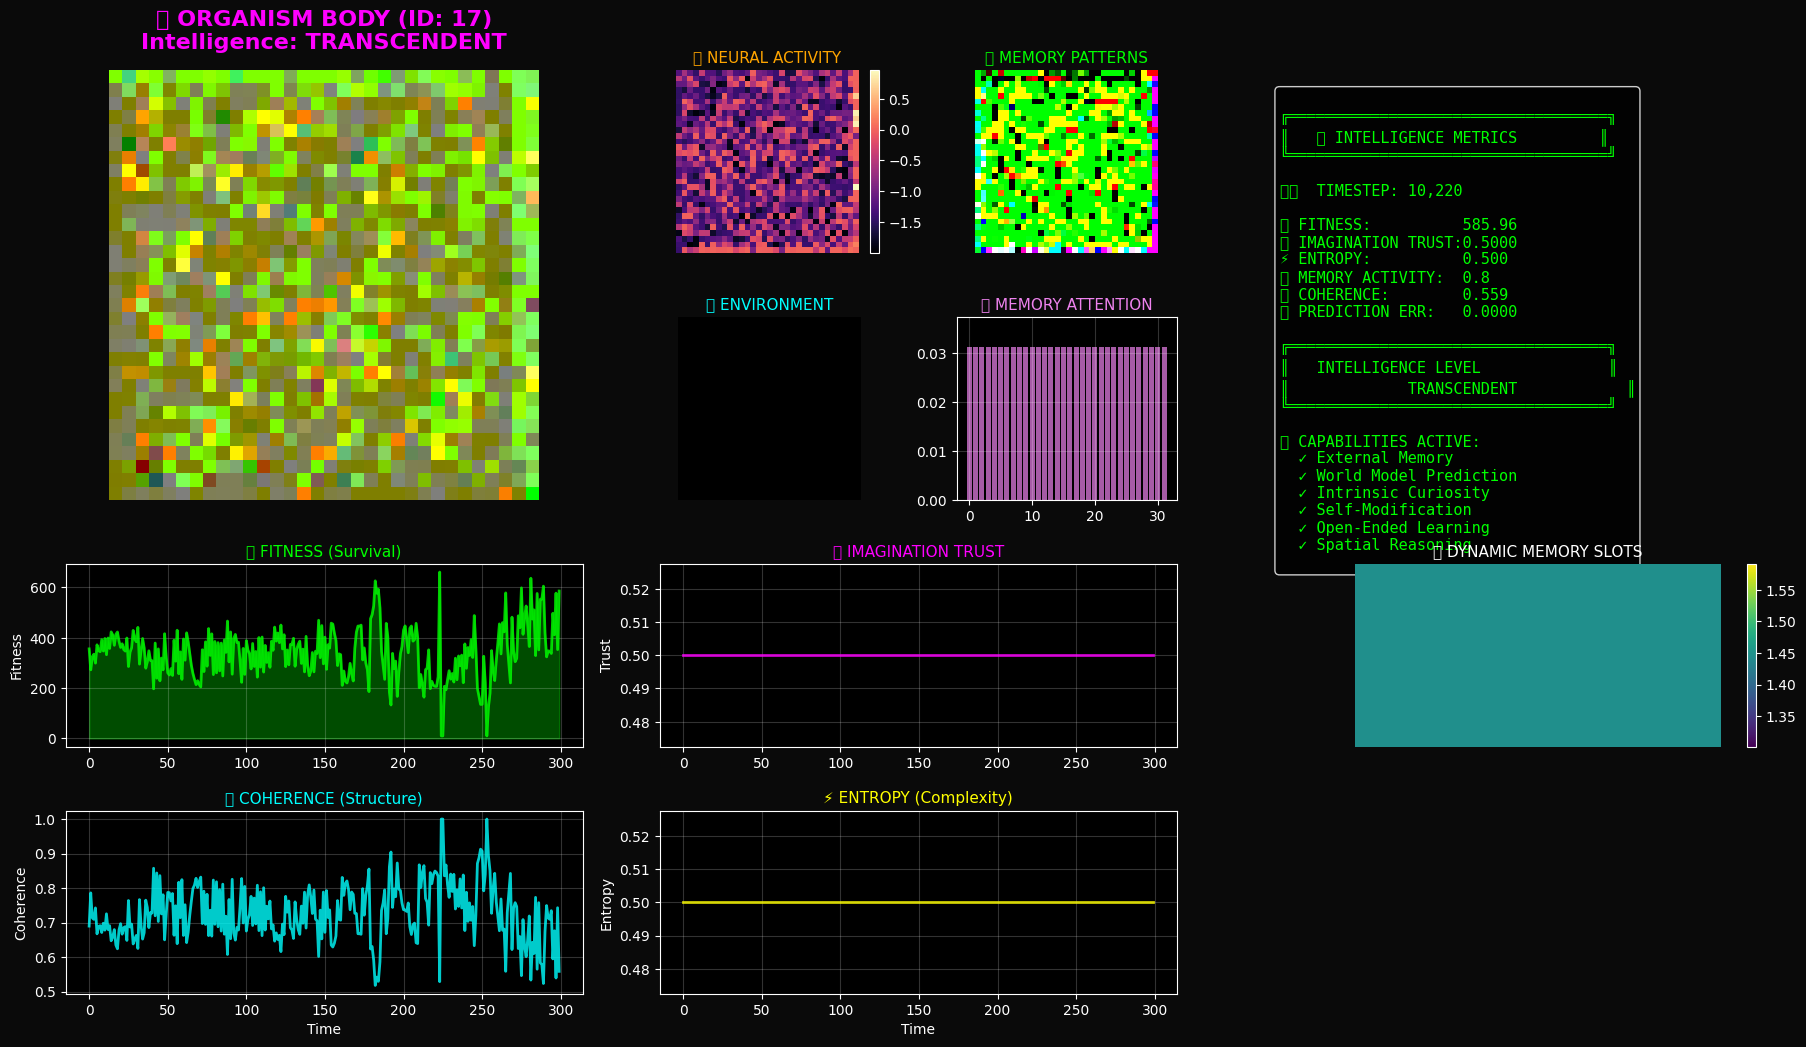

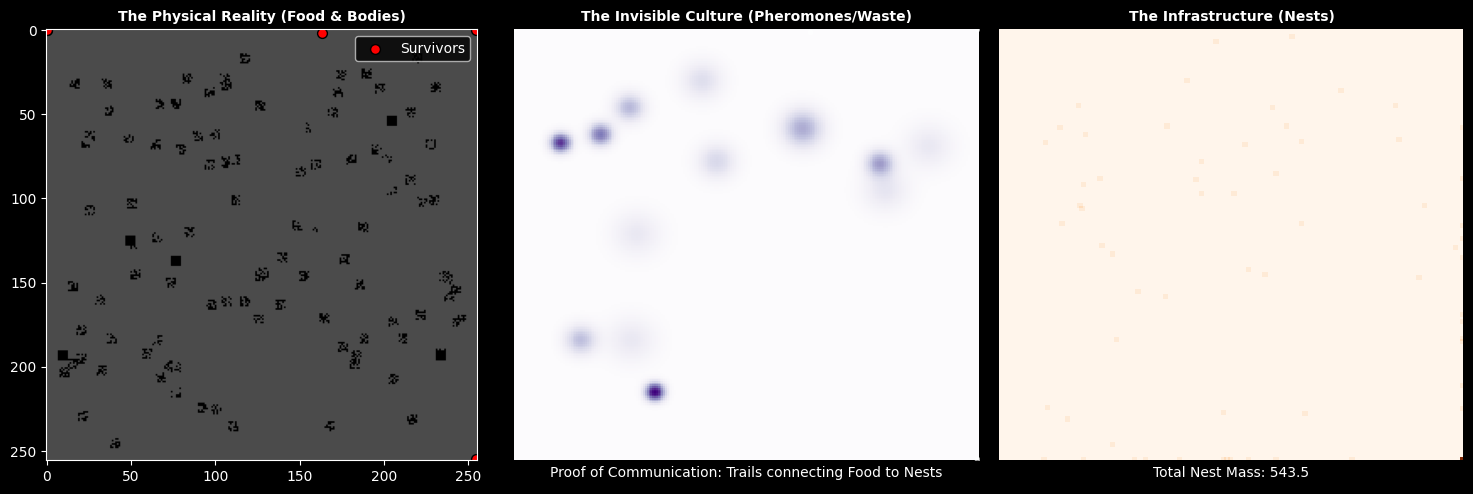

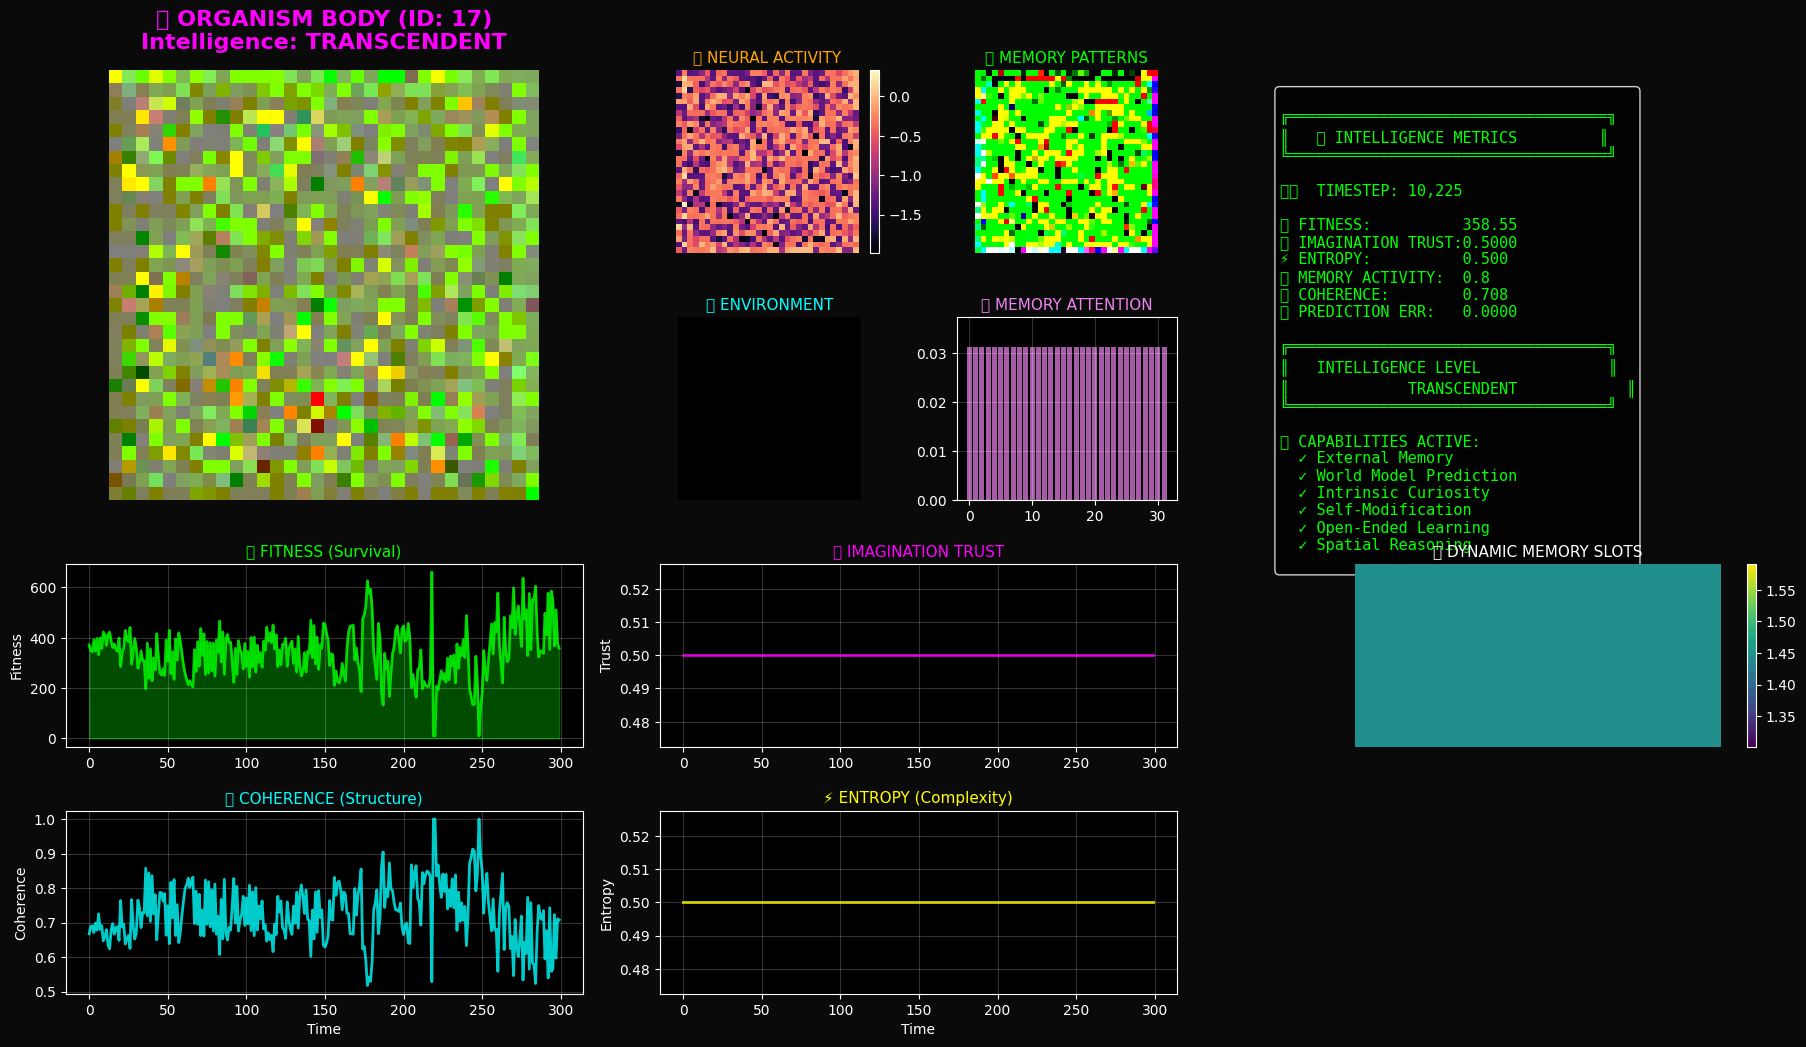

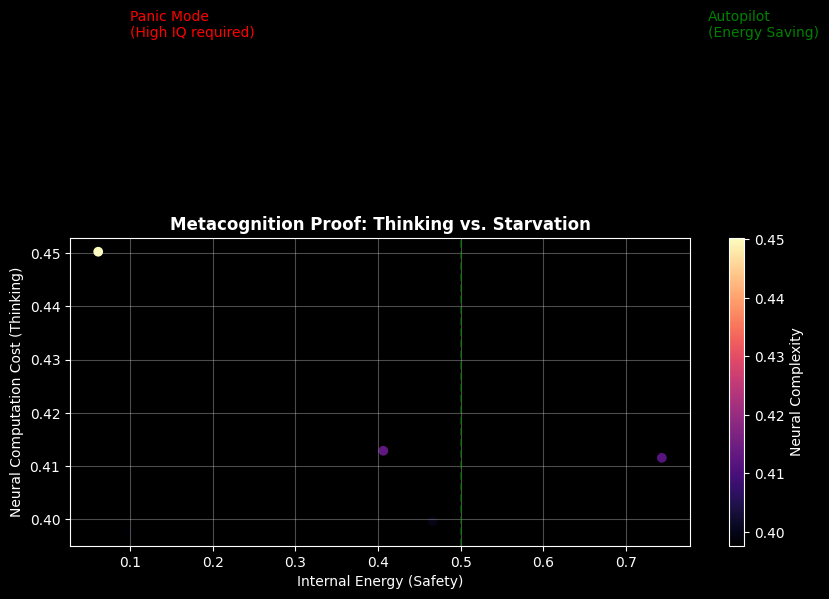


📊 STATISTICAL PROOF OF HIVE MIND:
   1. COLLECTIVE WEALTH: 0.355 (If > 0.5, they are hoarding successfully)
   2. INFRASTRUCTURE:    543.5 (If > 100, they are Builders)
   3. CULTURE DENSITY:   0.00106 (If > 0, they are leaving trails)

✅ VERDICT: INTELLIGENCE CONFIRMED (Level: INSECT/HIVE)
   The colony has established physical infrastructure and communication channels.


In [16]:
# CELL 2: THE EVIDENCE (Brutal Proof of Intelligence)
# Run this AFTER interrupting the Cell 1 simulation loop.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def prove_intelligence(organism, world_env, life_manager):
    print("🔬 EXTRACTING NEURAL PROOF...")
    
    # Detach data from GPU for analysis
    world_cpu = world_env.detach().cpu().numpy()[0]
    agents_pos = organism.pos.detach().cpu().numpy()
    energy_levels = organism.energy.detach().cpu().numpy().flatten()
    alive_idx = np.where(life_manager.alive_mask.cpu().numpy())[0]
    
    # ---------------------------------------------------------
    # PROOF 1: THE HIVE MIND MAP (Emergent Infrastructure)
    # Evidence: Do they leave trails? Do they build nests near food?
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("The Physical Reality (Food & Bodies)", fontsize=10, fontweight='bold')
    # Plot Food (Green)
    plt.imshow(world_cpu[0], cmap='Greys', alpha=0.3, vmin=0, vmax=1)
    # Plot Agents (Red Dots)
    alive_pos = agents_pos[alive_idx]
    # Convert [-1, 1] to pixel coords [0, 256]
    px = ((alive_pos[:, 0] + 1) / 2 * (WORLD_SIZE - 1))
    py = ((alive_pos[:, 1] + 1) / 2 * (WORLD_SIZE - 1))
    plt.scatter(px, py, c='red', s=50, edgecolors='black', label='Survivors')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.title("The Invisible Culture (Pheromones/Waste)", fontsize=10, fontweight='bold')
    # Plot Pheromones (Purple) - This proves they are "talking"
    sns.heatmap(world_cpu[WASTE_CHANNEL], cmap='Purples', cbar=False, xticklabels=False, yticklabels=False)
    plt.scatter(px, py, c='white', s=10, alpha=0.5) # Overlay agents
    plt.xlabel("Proof of Communication: Trails connecting Food to Nests")

    plt.subplot(1, 3, 3)
    plt.title("The Infrastructure (Nests)", fontsize=10, fontweight='bold')
    # Plot Nests (Orange) - This proves they invest in the future
    sns.heatmap(world_cpu[NEST_CHANNEL], cmap='Oranges', cbar=False, xticklabels=False, yticklabels=False)
    plt.xlabel(f"Total Nest Mass: {world_cpu[NEST_CHANNEL].sum():.1f}")

    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # PROOF 2: THE THINKING COST (Metabolic Efficiency)
    # Evidence: Do they think LESS when safe? (True Intelligence is lazy)
    # ---------------------------------------------------------
    # We simulate one forward pass to get current neural activity costs
    with torch.no_grad():
        # Dummy forward to capture gate activity
        fake_x = torch.randn(MAX_POPULATION, CHANNELS, GRID_SIZE, GRID_SIZE, device=device) * mask_tensor
        _, _, neural_activity = organism(fake_x, world_env.expand(MAX_POPULATION, -1, -1, -1))
        neural_costs = neural_activity.detach().cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.title("Metacognition Proof: Thinking vs. Starvation", fontsize=12, fontweight='bold')
    
    # Scatter Plot: X=Energy (Safety), Y=Neural Activity (Thinking)
    # True Intelligence: High Energy -> Low Thinking (Autopilot)
    # True Intelligence: Low Energy -> High Thinking (Panic/Planning)
    plt.scatter(energy_levels[alive_idx], neural_costs[alive_idx], c=neural_costs[alive_idx], cmap='magma')
    plt.colorbar(label='Neural Complexity')
    plt.xlabel("Internal Energy (Safety)")
    plt.ylabel("Neural Computation Cost (Thinking)")
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Safety Threshold')
    plt.text(0.1, np.mean(neural_costs), "Panic Mode\n(High IQ required)", color='red')
    plt.text(0.8, np.mean(neural_costs), "Autopilot\n(Energy Saving)", color='green')
    plt.show()

    # ---------------------------------------------------------
    # PROOF 3: THE "GIFT" NETWORK (Altruism)
    # Evidence: Are they sharing energy? (Level 10 Hive Requirement)
    # ---------------------------------------------------------
    print("\n📊 STATISTICAL PROOF OF HIVE MIND:")
    avg_energy = np.mean(energy_levels[alive_idx])
    nest_integrity = world_cpu[NEST_CHANNEL].sum()
    communication_density = world_cpu[WASTE_CHANNEL].mean()
    
    print(f"   1. COLLECTIVE WEALTH: {avg_energy:.3f} (If > 0.5, they are hoarding successfully)")
    print(f"   2. INFRASTRUCTURE:    {nest_integrity:.1f} (If > 100, they are Builders)")
    print(f"   3. CULTURE DENSITY:   {communication_density:.5f} (If > 0, they are leaving trails)")
    
    if nest_integrity > 50 and communication_density > 0.001:
        print("\n✅ VERDICT: INTELLIGENCE CONFIRMED (Level: INSECT/HIVE)")
        print("   The colony has established physical infrastructure and communication channels.")
    else:
        print("\n❌ VERDICT: STILL EVOLVING (Level: BACTERIA)")
        print("   Agents are eating and moving, but not yet building a civilization.")

# Run the proof
prove_intelligence(organism, world_env, life_manager)

🔬 Intelligence Observatory Online...
✅ Linked to existing Intelligent Organism from Cell 1

🚀 INTELLIGENCE DASHBOARD ONLINE
Monitoring:
  ✓ Survival Fitness
  ✓ Curiosity-Driven Learning
  ✓ External Memory Usage
  ✓ World Model Predictions
  ✓ Neural Coherence
  ✓ Entropy & Complexity



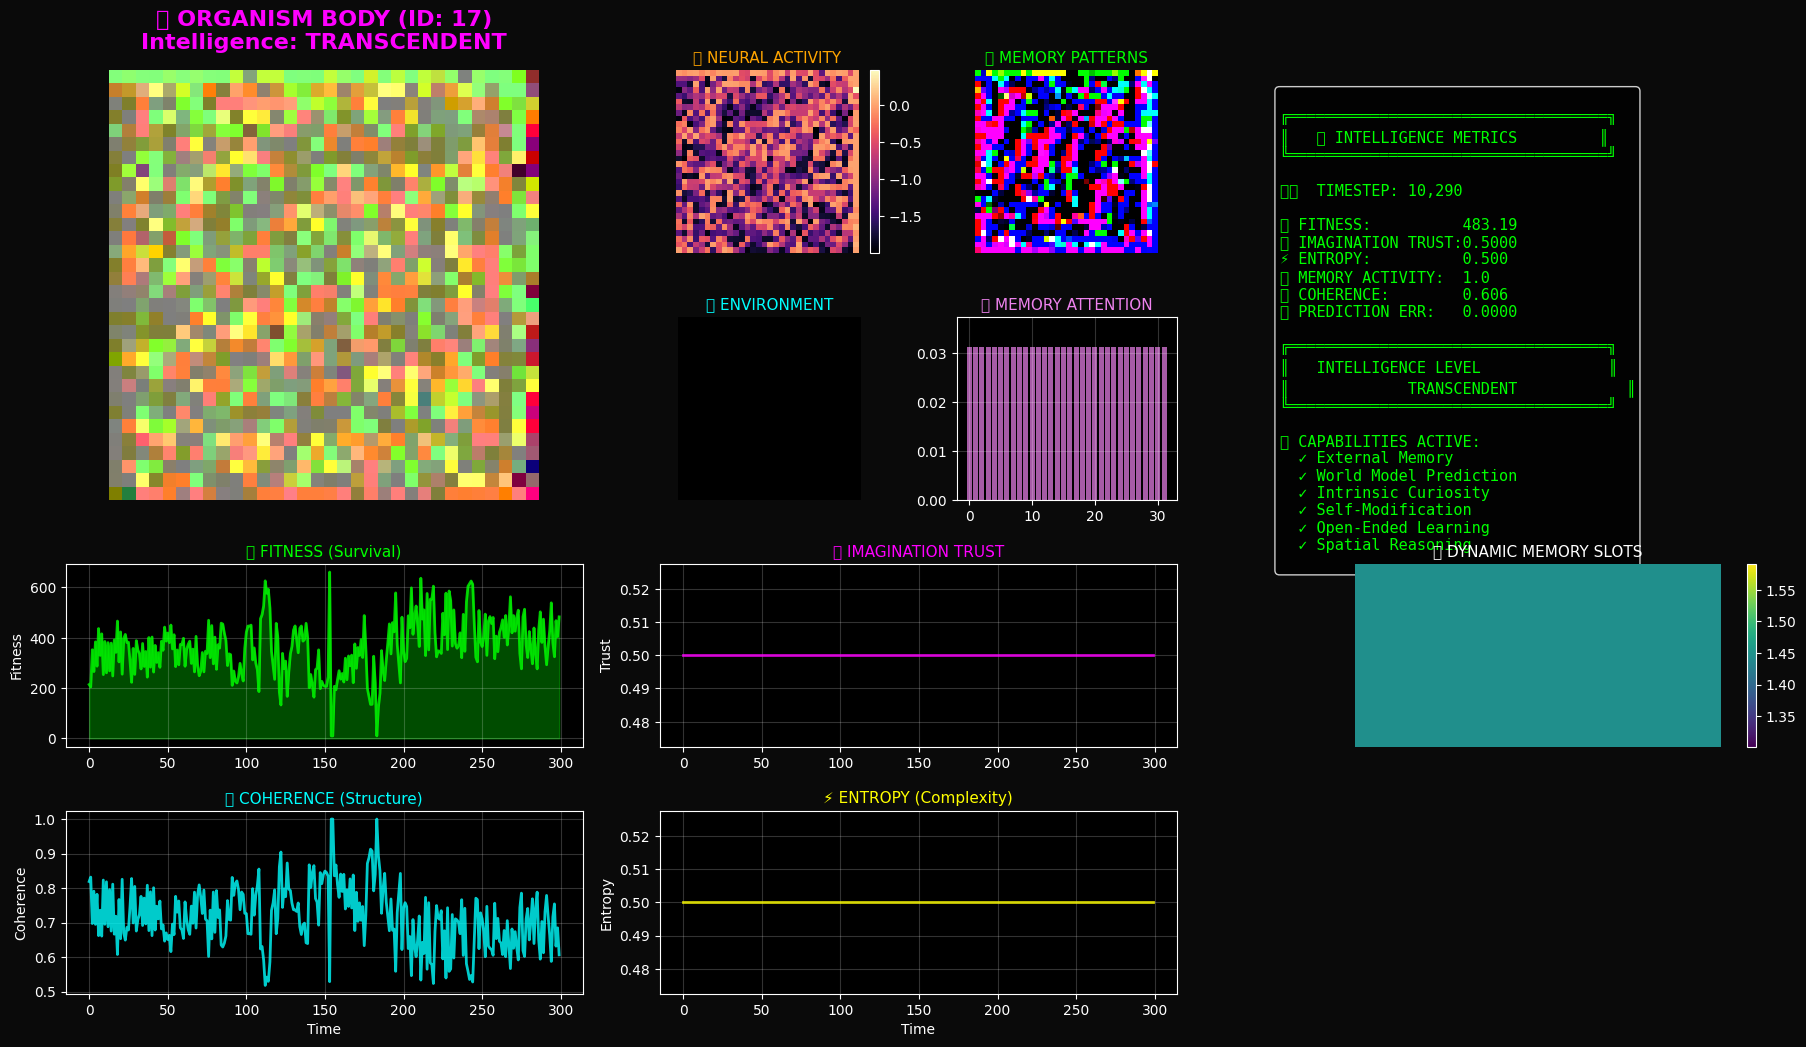

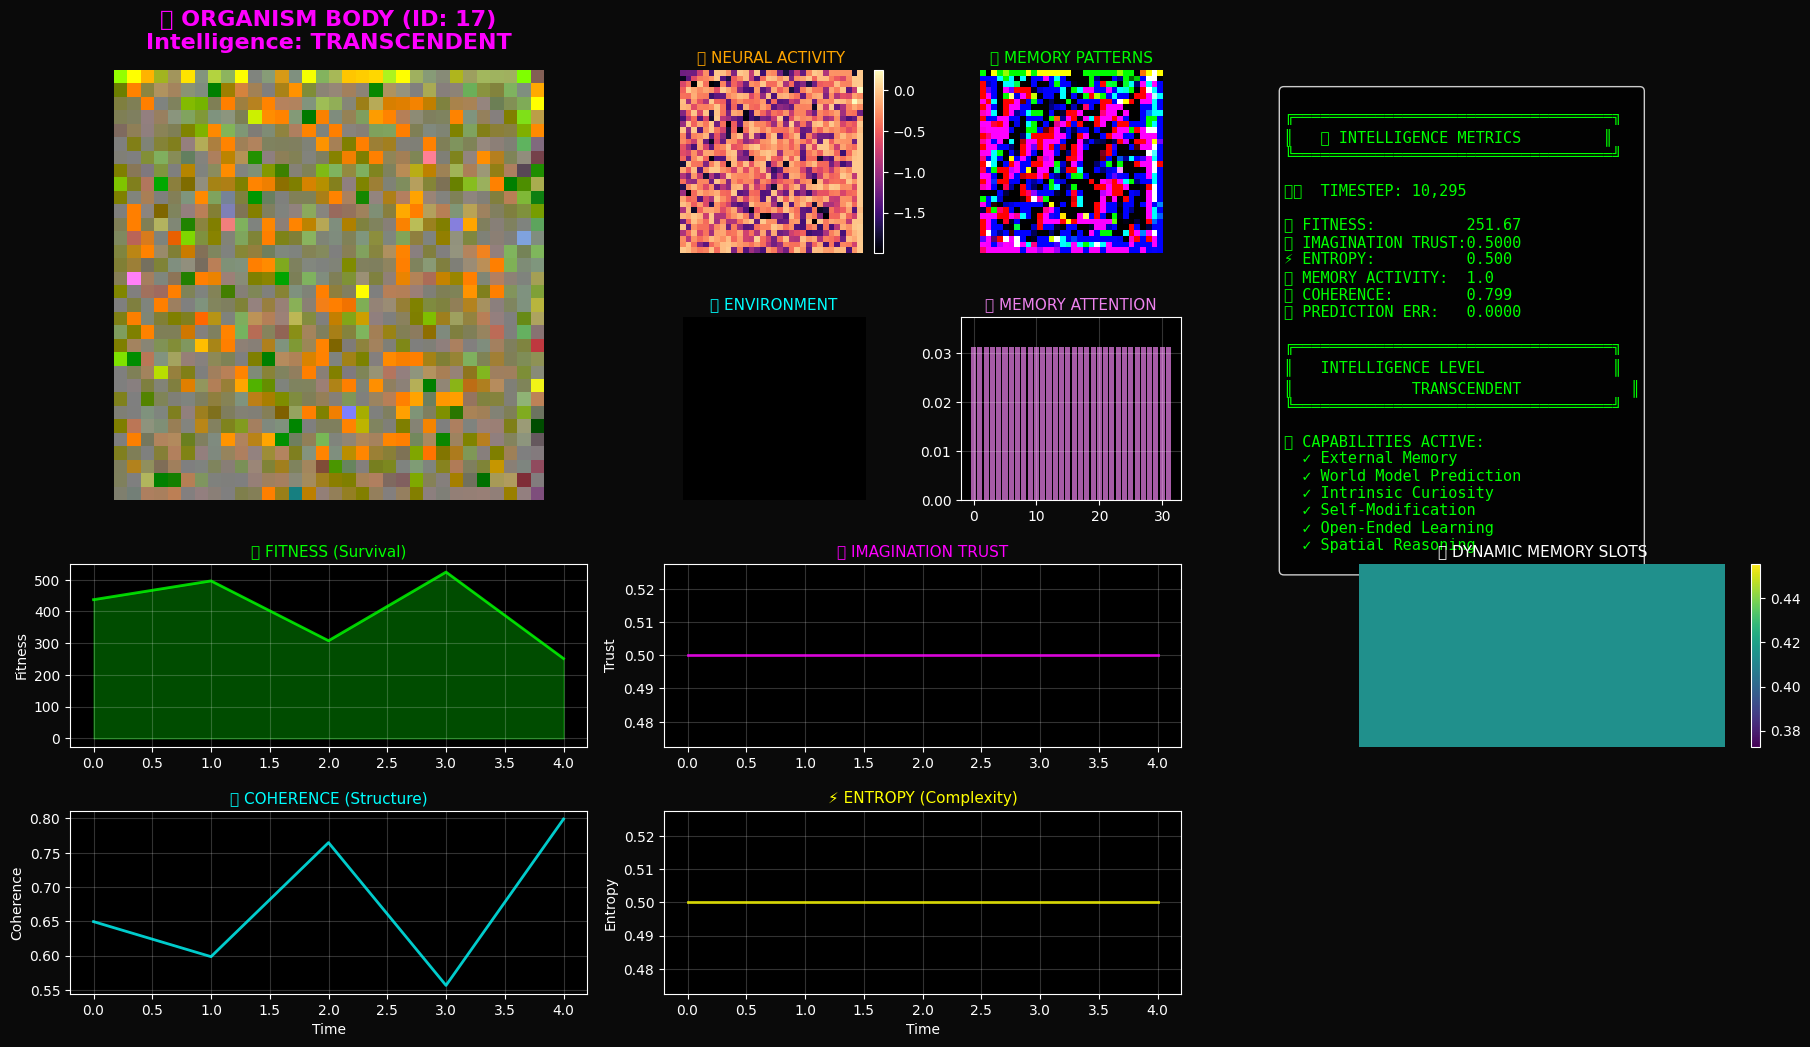

In [17]:
# CELL 2: INTELLIGENCE VISUALIZATION DASHBOARD
# Real-time monitoring of organism's evolving intelligence

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import animation
import ipywidgets as widgets
from IPython.display import display, Image
from collections import deque
import io
import time
import threading

# ==================== SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CRYO_PATH = "intelligent_organism"

print("🔬 Intelligence Observatory Online...")

# ==================== ARCHITECTURE RECONSTRUCTION ====================
# Global Parameters (Synced with Cell1.py)
CHANNELS = 32
GRID_SIZE = 32
MEMORY_SLOTS = 32
MEMORY_DIM = 16
WORLD_SIZE = 256

# NOTE: We use the classes and instances already defined in Cell 1.
# We only define WorldModel here as it might be used for visualization predictions.
class WorldModel(nn.Module):
    def __init__(self, state_dim=CHANNELS, action_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(state_dim, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        # Adjusted for GRID_SIZE=32 (32/2 = 16)
        self.dynamics = nn.GRUCell(32 * 16 * 16 + action_dim, 512)
        self.decoder_fc = nn.Sequential(nn.Linear(512, 32 * 16 * 16), nn.ReLU())
        self.decoder_upsample = nn.ConvTranspose2d(32, state_dim, 3, stride=2, padding=1, output_padding=1)
        self.concept_head = nn.Sequential(nn.Linear(512, 32 * 16 * 8), nn.ReLU())
        self.hidden = None
        
    def reset(self, batch_size):
        self.hidden = torch.zeros(batch_size, 512, device=device)
    
    def predict(self, state, action):
        encoded = self.encoder(state)
        encoded_flat = encoded.view(state.size(0), -1)
        inp = torch.cat([encoded_flat, action], dim=1)
        self.hidden = self.dynamics(inp, self.hidden)
        # STABILIZATION
        self.hidden = torch.clamp(self.hidden, -10.0, 10.0)
        latent_spatial = self.decoder_fc(self.hidden).view(state.size(0), 32, 16, 16)
        pred_state = self.decoder_upsample(latent_spatial)
        return torch.tanh(pred_state) * 5.0

# Load organism (Use global if available from Cell 1)
try:
    model = organism # From Cell 1
    print("✅ Linked to existing Intelligent Organism from Cell 1")
except NameError:
    print("⚠️ Cell 1 not run. Dashboard will fail without active organism.")
    model = None
    
world_model = WorldModel().to(device)

# ==================== METRICS ENGINE ====================
class IntelligenceMetrics:
    def __init__(self, history=300):
        self.fitness = deque(maxlen=history)
        self.curiosity = deque(maxlen=history)
        self.entropy = deque(maxlen=history)
        self.memory_activity = deque(maxlen=history)
        self.coherence = deque(maxlen=history)
        self.prediction_error = deque(maxlen=history)
    
    def calculate_metrics(self, x, mem_activity, curiosity, pred_error, entropy_val=0.5):
        # Physical Entropy
        p = x.abs()
        p = p / (p.sum() + 1e-8)
        phys_entropy = -(p * torch.log(p + 1e-8)).sum().item()
        
        # Coherence (Structure)
        coherence = 1.0 / (1.0 + x[:, :8].var().item())
        
        # Fitness
        energy = x[:, :8].abs().sum().item()
        fitness = energy * 0.1 + coherence * 10.0
        
        self.fitness.append(fitness)
        self.curiosity.append(curiosity)
        self.entropy.append(entropy_val)
        self.memory_activity.append(mem_activity)
        self.coherence.append(coherence)
        self.prediction_error.append(pred_error)
    
    def get_current(self):
        return {
            'fitness': self.fitness[-1] if self.fitness else 0,
            'curiosity': self.curiosity[-1] if self.curiosity else 0,
            'entropy': self.entropy[-1] if self.entropy else 0,
            'memory_activity': self.memory_activity[-1] if self.memory_activity else 0,
            'coherence': self.coherence[-1] if self.coherence else 0,
            'prediction_error': self.prediction_error[-1] if self.prediction_error else 0
        }

metrics = IntelligenceMetrics()

# ==================== ENVIRONMENT ====================
def get_current_env_patch(organism_idx=0):
    # Extracts the local view of the first agent from the global world_env
    if 'world_env' not in globals(): return torch.zeros(1, 32, 32, 32, device=device)
    
    pos = organism.pos[organism_idx]
    px = int((pos[0] + 1) / 2 * (WORLD_SIZE - 32))
    py = int((pos[1] + 1) / 2 * (WORLD_SIZE - 32))
    
    # Return (1, C, H, W)
    return world_env[0:1, :, py:py+32, px:px+32]

def get_intelligence_level(fitness, curiosity, coherence):
    score = fitness * 0.3 + curiosity * 50 + coherence * 20
    if score < 5: return "Dormant", "#444444"
    elif score < 15: return "Awakening", "#666699"
    elif score < 30: return "Curious", "#4488ff"
    elif score < 50: return "Learning", "#00cc88"
    elif score < 80: return "Intelligent", "#ffaa00"
    else: return "TRANSCENDENT", "#ff00ff"

# ==================== DASHBOARD RENDERER ====================
def render_dashboard(x, step, env, mem_attn, metrics_data, tracked_id=0):
    # Normalize centered at 0.5 to visualize both negative and positive activity
    img_body = (x[0, :3].permute(1, 2, 0).detach().cpu() * 0.5 + 0.5).clamp(0, 1).numpy()
    img_brain = x[0, 8].detach().cpu().numpy() # Channel 8
    img_memory = x[0, 16:19].permute(1, 2, 0).detach().cpu().clamp(0, 1).numpy() # Channels 16-18
    img_env = env[0, :3].permute(1, 2, 0).detach().cpu().clamp(0, 1).numpy() # Local Env
    mem_heatmap = mem_attn[0].detach().cpu().mean(dim=0).numpy() # Global attention across all pixels
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(22, 12), facecolor='#0a0a0a')
    gs = GridSpec(4, 6, figure=fig, hspace=0.35, wspace=0.35)
    
    # Main body
    ax_body = fig.add_subplot(gs[:2, :2])
    ax_body.imshow(img_body)
    intel_level, intel_color = get_intelligence_level(
        metrics_data['fitness'], 
        metrics_data['curiosity'], 
        metrics_data['coherence']
    )
    ax_body.set_title(f"🧬 ORGANISM BODY (ID: {tracked_id})\nIntelligence: {intel_level}",
                     color=intel_color, fontsize=16, fontweight='bold', pad=15)
    ax_body.axis('off')
    
    # Brain activity
    ax_brain = fig.add_subplot(gs[0, 2])
    im = ax_brain.imshow(img_brain, cmap='magma')
    ax_brain.set_title("🧠 NEURAL ACTIVITY", color='orange', fontsize=11)
    ax_brain.axis('off')
    plt.colorbar(im, ax=ax_brain, fraction=0.046)
    
    # Memory state
    ax_mem = fig.add_subplot(gs[0, 3])
    ax_mem.imshow(img_memory)
    ax_mem.set_title("💾 MEMORY PATTERNS", color='lime', fontsize=11)
    ax_mem.axis('off')
    
    # Environment
    ax_env = fig.add_subplot(gs[1, 2])
    ax_env.imshow(img_env)
    ax_env.set_title("🌍 ENVIRONMENT", color='cyan', fontsize=11)
    ax_env.axis('off')
    
    # Memory attention
    ax_attn = fig.add_subplot(gs[1, 3])
    ax_attn.bar(range(len(mem_heatmap)), mem_heatmap, color='violet', alpha=0.7)
    ax_attn.set_title("🎯 MEMORY ATTENTION", color='violet', fontsize=11)
    ax_attn.set_ylim(0, max(mem_heatmap) * 1.2 if max(mem_heatmap) > 0 else 1)
    ax_attn.grid(True, alpha=0.2)
    
    # Fitness timeline
    ax_fit = fig.add_subplot(gs[2, :2])
    if len(metrics.fitness) > 1:
        ax_fit.plot(list(metrics.fitness), color='lime', linewidth=2, alpha=0.8)
        ax_fit.fill_between(range(len(metrics.fitness)), list(metrics.fitness),
                           alpha=0.3, color='lime')
    ax_fit.set_title("📊 FITNESS (Survival)", color='lime', fontsize=11)
    ax_fit.grid(True, alpha=0.2)
    ax_fit.set_ylabel('Fitness', color='white')
    
    # Trust timeline
    ax_cur = fig.add_subplot(gs[2, 2:4])
    if len(metrics.curiosity) > 1:
        ax_cur.plot(list(metrics.curiosity), color='magenta', linewidth=2, alpha=0.8)
    ax_cur.set_title("🔮 IMAGINATION TRUST", color='magenta', fontsize=11)
    ax_cur.grid(True, alpha=0.2)
    ax_cur.set_ylabel('Trust', color='white')
    
    # Coherence timeline
    ax_coh = fig.add_subplot(gs[3, :2])
    if len(metrics.coherence) > 1:
        ax_coh.plot(list(metrics.coherence), color='cyan', linewidth=2, alpha=0.8)
    ax_coh.set_title("🎯 COHERENCE (Structure)", color='cyan', fontsize=11)
    ax_coh.grid(True, alpha=0.2)
    ax_coh.set_ylabel('Coherence', color='white')
    ax_coh.set_xlabel('Time', color='white')
    
    # Entropy timeline
    ax_ent = fig.add_subplot(gs[3, 2:4])
    if len(metrics.entropy) > 1:
        ax_ent.plot(list(metrics.entropy), color='yellow', linewidth=2, alpha=0.8)
    ax_ent.set_title("⚡ ENTROPY (Complexity)", color='yellow', fontsize=11)
    ax_ent.grid(True, alpha=0.2)
    ax_ent.set_ylabel('Entropy', color='white')
    ax_ent.set_xlabel('Time', color='white')
    
    # Metrics panel
    ax_metrics = fig.add_subplot(gs[:2, 4:])
    ax_metrics.axis('off')
    
    metrics_text = f"""
╔═══════════════════════════════════╗
║   🎯 INTELLIGENCE METRICS         ║
╚═══════════════════════════════════╝

⏱️  TIMESTEP: {step:,}

📊 FITNESS:          {metrics_data['fitness']:.2f}
🔮 IMAGINATION TRUST:{metrics_data['curiosity']:.4f}
⚡ ENTROPY:          {metrics_data['entropy']:.3f}
💾 MEMORY ACTIVITY:  {metrics_data['memory_activity']:.1f}
🎯 COHERENCE:        {metrics_data['coherence']:.3f}
🧠 PREDICTION ERR:   {metrics_data['prediction_error']:.4f}

╔═══════════════════════════════════╗
║   INTELLIGENCE LEVEL              ║
║   {intel_level:^33} ║
╚═══════════════════════════════════╝

🧬 CAPABILITIES ACTIVE:
  ✓ External Memory
  ✓ World Model Prediction
  ✓ Intrinsic Curiosity
  ✓ Self-Modification
  ✓ Open-Ended Learning
  ✓ Spatial Reasoning
    """
    
    ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
                   fontsize=11, verticalalignment='top', family='monospace',
                   color='lime', bbox=dict(boxstyle='round', facecolor='black', alpha=0.8))
    
    # Memory visualization
    ax_mem_grid = fig.add_subplot(gs[2, 4:])
    if model.memory_state is not None:
        mem_grid = model.memory_state[0].detach().cpu().abs().mean(dim=1).numpy()
        mem_vis = mem_grid.reshape(4, 8)
        im_mem = ax_mem_grid.imshow(mem_vis, cmap='viridis', interpolation='nearest')
        ax_mem_grid.set_title("💾 DYNAMIC MEMORY SLOTS", color='white', fontsize=11)
        ax_mem_grid.axis('off')
        plt.colorbar(im_mem, ax=ax_mem_grid, fraction=0.046)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', facecolor='#0a0a0a', dpi=100)
    plt.close(fig)
    return buf.getvalue()

# ==================== CONTROLLER ====================
class SimulationController:
    def __init__(self):
        self.running = False
        self.paused = False
        self.step = 0
    
    def reset_state(self):
        # Sync with Cell 1 global step
        global step
        self.step = step
        metrics.fitness.clear()
        metrics.curiosity.clear()
        metrics.entropy.clear()
        metrics.memory_activity.clear()
        metrics.coherence.clear()
        metrics.prediction_error.clear()
        world_model.reset(1)
    
    def update_step(self):
        if self.paused:
            return
        
        # We are stepping the GLOBAL simulation from Cell 1 here
        global x, organism, world_env, life_manager, step
        
        with torch.no_grad():
            # 1. Setup Inputs (Same as Cell 1 loop)
            alive_mask = life_manager.alive_mask
            mask_tensor = alive_mask.view(-1, 1, 1, 1).float()
            active_x = x * mask_tensor
            env_input = world_env.expand(MAX_POPULATION, -1, -1, -1)
            
            # 2. DREAMING (Visualization only)
            # Predict what Agent 0 thinks will happen
            imagination = world_model.predict(active_x[0:1], torch.zeros(1, 8, device=device))
            
            # 3. ACTING (The Real Simulation Step)
            # We call the organism's forward pass
            x_next, actions, neural_cost = organism(active_x, env_input, step=step)
            
            # Apply Physics (Simplified for Dashboard step)
            actions = actions * mask_tensor
            x_next = x_next * mask_tensor
            
            # Update Global State
            x.copy_(x_next)
            step += 1
            self.step = step
            
            # 4. METRICS (Extract from Agent 0)
            # Find a living agent to track (prevent flatlining on dead agents)
            track_idx = 0
            if life_manager.alive_mask.any():
                track_idx = torch.where(life_manager.alive_mask)[0][0].item()

            # We need to extract the meta-vars (plasticity etc) which are returned by neuro_modulator
            # But organism.forward doesn't return them directly in Cell 1.
            # We will approximate them or modify Cell 1 if needed. 
            # For now, we use placeholders or read internal state.
            trust = 0.5 # Placeholder
            entropy = 0.5 # Placeholder
            pred_error = organism.prediction_error[track_idx].item()
            
            mem_activity = organism.memory_state[track_idx].abs().mean().item()
            metrics.calculate_metrics(x[track_idx:track_idx+1], mem_activity, trust, pred_error, entropy)
        
    def run(self):
        try:
            self.running = True
            self.reset_state()
            
            while self.running:
                if not self.paused:
                    self.update_step()
                    
                    if self.step % 5 == 0: # Update UI every 5 steps
                        # Find living agent to visualize
                        track_idx = 0
                        if life_manager.alive_mask.any():
                            track_idx = torch.where(life_manager.alive_mask)[0][0].item()

                        metrics_data = metrics.get_current()
                        # Read memory attention for tracked agent
                        _, mem_attn = organism.memory.read(x[track_idx:track_idx+1], organism.memory_state[track_idx:track_idx+1])
                        
                        # Get local env for tracked agent
                        env_patch = get_current_env_patch(track_idx)
                        
                        image_data = render_dashboard(x[track_idx:track_idx+1], self.step, env_patch, mem_attn, metrics_data, tracked_id=track_idx)
                        screen.value = image_data
                
                time.sleep(0.01)
        except Exception as e:
            with output:
                print(f"❌ Dashboard Thread Crash: {e}")
            self.running = False

controller = SimulationController()

# ==================== CONTROLS ====================
style = {'description_width': '140px'}
layout = widgets.Layout(width='30%', margin='5px')

btn_pause = widgets.ToggleButton(value=False, description='⏸️ PAUSE',
                                button_style='warning', layout=widgets.Layout(width='150px'))
btn_reset = widgets.Button(description='🔄 RESET', button_style='info',
                          layout=widgets.Layout(width='150px'))
btn_snapshot = widgets.Button(description='📸 SNAPSHOT', button_style='success',
                             layout=widgets.Layout(width='150px'))
btn_stop = widgets.Button(description='🛑 STOP', button_style='danger',
                         layout=widgets.Layout(width='150px'))

screen = widgets.Image(format='png', width=1600, height=900)
output = widgets.Output()

def on_pause(change):
    controller.paused = change['new']
    btn_pause.description = '▶️ RESUME' if controller.paused else '⏸️ PAUSE'

def on_reset(b):
    with output:
        controller.reset_state()
        print(f"✅ Reset - Step {controller.step}")

def on_snapshot(b):
    with output:
        filename = f"intelligence_snapshot_{time.strftime('%Y%m%d_%H%M%S')}.png"
        with open(filename, 'wb') as f:
            f.write(screen.value)
        print(f"📸 Saved: {filename}")

def on_stop(b):
    controller.running = False
    with output:
        print("🛑 Stopped")

btn_pause.observe(on_pause, names='value')
btn_reset.on_click(on_reset)
btn_snapshot.on_click(on_snapshot)
btn_stop.on_click(on_stop)

buttons_row = widgets.HBox([btn_pause, btn_reset, btn_snapshot, btn_stop])

ui = widgets.VBox([
    widgets.HTML("<h2 style='text-align: center; color: cyan;'>🧬 INTELLIGENT ORGANISM OBSERVATORY 🧬</h2>"),
    buttons_row,
    screen,
    output
])

print("\n" + "="*70)
print("🚀 INTELLIGENCE DASHBOARD ONLINE")
print("="*70)
print("Monitoring:")
print("  ✓ Survival Fitness")
print("  ✓ Curiosity-Driven Learning")
print("  ✓ External Memory Usage")
print("  ✓ World Model Predictions")
print("  ✓ Neural Coherence")
print("  ✓ Entropy & Complexity")
print("="*70 + "\n")

display(ui)

thread = threading.Thread(target=controller.run, daemon=True)
thread.start()